In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from pathlib import Path
from typing import Any
from logging import INFO, DEBUG
import json
import os
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from flwr.common import log, ndarrays_to_parameters
import matplotlib.pyplot as plt
import math

from src.common.client_utils import (
    load_femnist_dataset,
    get_network_generator_cnn as get_network_generator,
    get_device,
    get_model_parameters,
    aggregate_weighted_average,
)


from src.flwr_core import (
    set_all_seeds,
    get_paths,
    decompress_dataset,
    get_flower_client_generator,
    sample_random_clients,
    get_federated_evaluation_function,
)

from src.estimate import (
    compute_critical_batch,
)

from src.experiments_simulation import (
    run_simulation,
    centralized_experiment,
)

from src.utils import get_centralized_acc_from_hist

PathType = Path | str | None

**Global variables**

In [2]:
set_all_seeds()

PATHS = get_paths()

HOME_DIR = PATHS["home_dir"]
DATASET_DIR = PATHS["dataset_dir"]
DATA_DIR = PATHS["data_dir"]
CENTRALIZED_PARTITION = PATHS["centralized_partition"]
CENTRALIZED_MAPPING = PATHS["centralized_mapping"]
FEDERATED_PARTITION = PATHS["federated_partition"]

# extract dataset from tar.gz
decompress_dataset(PATHS)

In [3]:
NETWORK_GENERATOR = get_network_generator()
SEED_NET = NETWORK_GENERATOR()
SEED_MODEL_PARAMS = get_model_parameters(SEED_NET)
CID_CLIENT_GENERATOR = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_PARTITION)

In [13]:
# Centralized experiments
centralized_experiment_batch_sizes = [32, 64, 128, 256, 512, 1024]

# Load the centralized dataset using the same function as in FL.
# The centralized mapping folder should be the one used in the FL centralized experiment.
centralized_train_dataset = load_femnist_dataset(data_dir=DATA_DIR,mapping=CENTRALIZED_MAPPING, name="train")
centralized_test_dataset = load_femnist_dataset(data_dir=DATA_DIR, mapping=CENTRALIZED_MAPPING, name="test")

centralized_train_config = {
    "epochs": 10,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0,
    "num_workers": 0,
    "max_batches": 100,
}

centralized_test_config = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
    "target_accuracy": 0.60,
}

In [ ]:
# FL experiments
experiment_batch_sizes = [16, 32, 64, 128, 256]
cohort_sizes = [5, 10, 20, 50, 75, 100]


# Federated configuration dictionary
federated_train_config = {
    "epochs": 10,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0,
    "num_workers": 0,
    #"max_batches": 100,
}

federated_test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

num_rounds = 10
num_total_clients = 100
num_evaluate_clients = 0
num_clients_per_round = 10

initial_parameters = ndarrays_to_parameters(SEED_MODEL_PARAMS)

federated_evaluation_function = get_federated_evaluation_function(
    batch_size=federated_test_config["batch_size"],
    num_workers=federated_test_config["num_workers"],
    model_generator=NETWORK_GENERATOR,
    criterion=nn.CrossEntropyLoss(),
    max_batches=None if "max_batches" not in federated_test_config else federated_test_config["max_batches"],
)

server_learning_rate = 1.0
server_momentum = 0.0
accept_failures = False


CID_CLIENT_GENERATOR = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_PARTITION)

list_of_ids = sample_random_clients(
    num_total_clients, federated_train_config["batch_size"],
    CID_CLIENT_GENERATOR,
)

federated_client_generator = (
    get_flower_client_generator(
        NETWORK_GENERATOR, FEDERATED_PARTITION, lambda seq_id: list_of_ids[seq_id]
    )
)

INFO flwr 2025-02-28 17:47:22,499 | flwr_core.py:105 | cid: 2530
INFO flwr 2025-02-28 17:47:22,847 | flwr_core.py:105 | cid: 2184
INFO flwr 2025-02-28 17:47:22,849 | flwr_core.py:105 | cid: 2907
INFO flwr 2025-02-28 17:47:22,851 | flwr_core.py:105 | cid: 1498
INFO flwr 2025-02-28 17:47:22,853 | flwr_core.py:105 | cid: 2338
INFO flwr 2025-02-28 17:47:22,855 | flwr_core.py:105 | cid: 2399
INFO flwr 2025-02-28 17:47:22,856 | flwr_core.py:105 | cid: 2997
INFO flwr 2025-02-28 17:47:22,858 | flwr_core.py:105 | cid: 678
INFO flwr 2025-02-28 17:47:22,860 | flwr_core.py:105 | cid: 3175
INFO flwr 2025-02-28 17:47:22,861 | flwr_core.py:105 | cid: 1363
INFO flwr 2025-02-28 17:47:22,863 | flwr_core.py:105 | cid: 1571
INFO flwr 2025-02-28 17:47:22,864 | flwr_core.py:105 | cid: 2600
INFO flwr 2025-02-28 17:47:22,866 | flwr_core.py:105 | cid: 1473
INFO flwr 2025-02-28 17:47:22,867 | flwr_core.py:105 | cid: 1260
INFO flwr 2025-02-28 17:47:22,869 | flwr_core.py:105 | cid: 1603
INFO flwr 2025-02-28 17:47

## **Experiments**

### LR scaling

Some rules usually are:

**Linear scaling**

$$ \text{LR} \propto \text{batch size} $$

so, starting with 0.1 at 256, we get then, 0.05 at 128, 0.025 at 64, 0.0125 at 32, 0.00625 at 16.

However, this is not always the case, and it depends on the model, the dataset, the optimizer, etc.

We can also use:

**Sqrt scaling**

$$ \text{LR} \propto \sqrt{\text{batch size}} $$

Starting with 0.1 at 256, we get then, sqrt(128/256) * 0.1 at 128, sqrt(64/256) * 0.1 at 64, sqrt(32/256) * 0.1 at 32, sqrt(16/256) * 0.1 at 16.


Or we can use **Learning Rate Finders**.

***However***, in Federated Learning usually people use lower learning rates.

While in centralized learning its normal to use LR = 0.1 to batch size = 256, in federated learning its usual to use 0.005-0.01 for batch sizes 16-32.


### **Centralized run with varying batch sizes**

In [14]:
centralized_experiment_results = []

for batch_size in centralized_experiment_batch_sizes:
    train_cfg = centralized_train_config.copy()
    train_cfg["batch_size"] = batch_size
    ratio = np.sqrt(batch_size / 256)
    train_cfg["learning_rate"] = ratio * 0.1

    test_cfg = centralized_test_config.copy()
    test_cfg["batch_size"] = batch_size

    # Create DataLoaders with the same settings.
    centralized_train_loader = DataLoader(
        dataset=centralized_train_dataset,
        batch_size=train_cfg["batch_size"],
        shuffle=True,                # Shuffle for training
        num_workers=train_cfg["num_workers"],
        drop_last=True,              # If FL training drops last batch, do the same here.
    )

    centralized_test_loader = DataLoader(
        dataset=centralized_test_dataset,
        batch_size=test_cfg["batch_size"],
        shuffle=False,               # No shuffling during evaluation
        num_workers=test_cfg["num_workers"],
        drop_last=False,
    )
    
    centralized_results = centralized_experiment(centralized_train_config, centralized_test_config, centralized_train_loader, centralized_test_loader, get_device(), NETWORK_GENERATOR())
    centralized_experiment_results.append((batch_size, centralized_results))


INFO flwr 2025-02-28 18:05:29,902 | experiments_simulation.py:132 | Epoch 1/10, Loss: 0.2673, Noise scale: 1.5406e-06, Accuracy: 41.49%, Epoch time: 0.22s
INFO flwr 2025-02-28 18:06:37,710 | experiments_simulation.py:132 | Epoch 2/10, Loss: 0.1151, Noise scale: 6.9425e-07, Accuracy: 70.15%, Epoch time: 0.26s


KeyboardInterrupt: 

In [9]:
def load_experiment(save_file_name):
    with open(save_file_name, "r") as f:
        results_dict = json.load(f)
    return results_dict

def save_experiment(save_file_name, results_dict):
    if os.path.exists(save_file_name):
        print(f"File {save_file_name} already exists")
        return
    with open(save_file_name, "w") as f:
        json.dump(results_dict, f, indent=4)

In [ ]:
for batch_size, results in centralized_experiment_results:
    save_experiment(f"centralized_experiment_results_{batch_size}.json", results)

Their plot:

Y-axis: $\epsilon_\text{opt}(B) / \epsilon_\text{max}$, which is $\frac{1}{1+\Beta_{noise}/B}$, B batch size, $\Beta_{noise}$ is the noise scale.

X-axis: $\frac{B}{\Beta_{noise}}$, B batch size, $\Beta_{noise}$ is noise scale.

In [8]:
centralized_experiment_results

[]

In [9]:
def load_experiment(save_file_name):
    with open(save_file_name, "r") as f:
        results_dict = json.load(f)
    return results_dict


INFO flwr 2025-02-28 18:02:57,791 | 3868599753.py:23 | Batch size: 32
INFO flwr 2025-02-28 18:02:57,792 | 3868599753.py:24 | Total Training Time (s): 1.7968597412109375
INFO flwr 2025-02-28 18:02:57,792 | 3868599753.py:25 | Compute Budget (samples): 22400
INFO flwr 2025-02-28 18:02:57,793 | 3868599753.py:23 | Batch size: 64
INFO flwr 2025-02-28 18:02:57,793 | 3868599753.py:24 | Total Training Time (s): 1.2245638370513916
INFO flwr 2025-02-28 18:02:57,794 | 3868599753.py:25 | Compute Budget (samples): 32000
INFO flwr 2025-02-28 18:02:57,795 | 3868599753.py:23 | Batch size: 128
INFO flwr 2025-02-28 18:02:57,795 | 3868599753.py:24 | Total Training Time (s): 0.7908370494842529
INFO flwr 2025-02-28 18:02:57,795 | 3868599753.py:25 | Compute Budget (samples): 38400
INFO flwr 2025-02-28 18:02:57,796 | 3868599753.py:23 | Batch size: 256
INFO flwr 2025-02-28 18:02:57,797 | 3868599753.py:24 | Total Training Time (s): 0.48624491691589355
INFO flwr 2025-02-28 18:02:57,797 | 3868599753.py:25 | Compu

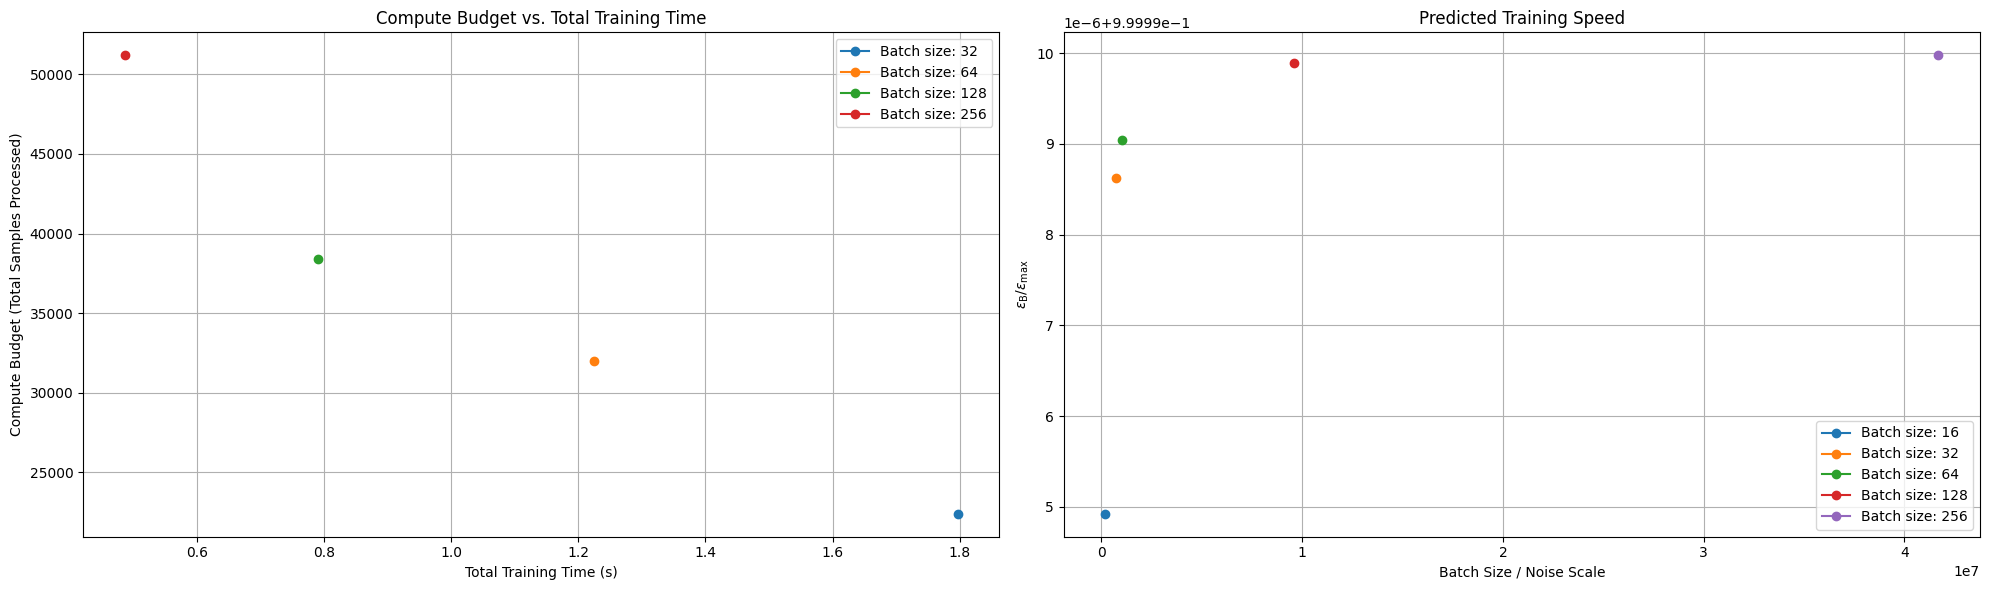

In [12]:
# Assume centralized_experiment_results is a list of tuples:
# (batch_size, results)
# where results is a dict containing:
#   - "compute_budgets": samples per epoch
#   - "training_time": time per epoch
#   - "noise_scales": list of noise scale values per epoch

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

centralized_experiment_results = [
    (batch_size, load_experiment(f"centralized_experiment_results_{batch_size}.json"))
    for batch_size in centralized_experiment_batch_sizes
]
# Left subplot: Compute Budget vs. Cumulative Training Time for each batch size
for batch_size, results in centralized_experiment_results:
    if batch_size == 16:
        continue
    # Calculate cumulative training time (sum over epochs)
    cumulative_time = np.sum(results["training_time"])
    compute_budget = np.sum(results["compute_cost"])
    axes[0].plot(cumulative_time, compute_budget, marker='o', label=f"Batch size: {batch_size}")
    
    log(INFO, f"Batch size: {batch_size}")
    log(INFO, f"Total Training Time (s): {cumulative_time}")
    log(INFO, f"Compute Budget (samples): {compute_budget}")

axes[0].set_xlabel("Total Training Time (s)")
axes[0].set_ylabel("Compute Budget (Total Samples Processed)")
axes[0].set_title("Compute Budget vs. Total Training Time")
axes[0].legend()
axes[0].grid(True)

# Right subplot: Noise Scale vs. Cumulative Training Time for each batch size
for batch_size, results in centralized_experiment_results:
    noise_scale = np.mean(results["noise_scales"]) # do we average ??

    x_axis = batch_size / noise_scale
    y_axis = 1 / (1 + (noise_scale / batch_size))
    
    axes[1].plot(x_axis, y_axis, marker='o', label=f"Batch size: {batch_size}")
    
    log(INFO, f"Batch size: {batch_size}")
    log(INFO, f"Cumulative Training Time (s): {cumulative_time}")
    log(INFO, f"Noise Scale: {noise_scale}")


axes[1].set_xlabel("Batch Size / Noise Scale")
axes[1].set_ylabel(fr"${{\epsilon_\text{{B}}}} / {{\epsilon_\text{{max}}}}$")
axes[1].set_title("Predicted Training Speed")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


We can also observe that increasing batch size appears does in fact alter performance.

Furthermore, both $\beta_{\text{simple}}$ computation and the empirical results seem to indicate optimal batch sizes with magnitudes in the hundreds (100-1000).

### **FL run with varying batch sizes**

In [11]:
total_batch_results = []

for batch_size in experiment_batch_sizes:
    train_cfg = federated_train_config.copy()
    train_cfg["batch_size"] = batch_size
    ratio = np.sqrt(batch_size / 256)
    train_cfg["client_learning_rate"] = ratio * 0.01 # Same as centralized, but should be lower for FL

    test_cfg = federated_test_config.copy()
    test_cfg["batch_size"] = batch_size

    local_list_of_ids = sample_random_clients(num_total_clients, train_cfg["batch_size"], CID_CLIENT_GENERATOR)
    local_federated_client_generator = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_PARTITION, lambda seq_id: local_list_of_ids[seq_id])

    parameters_for_each_round, hist = run_simulation(
        num_rounds = num_rounds,
        num_total_clients = num_total_clients,
        num_clients_per_round = num_clients_per_round,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = num_clients_per_round,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = local_federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        target_accuracy=0.60,
        use_target_accuracy=True,
        )

    total_batch_results.append((batch_size, parameters_for_each_round, hist))

INFO flwr 2025-02-28 01:14:31,612 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:14:31,617 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:14:31,619 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:14:31,622 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:14:31,624 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:14:31,626 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:14:31,628 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:14:31,631 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:14:31,634 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:14:31,636 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:14:31,638 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:14:31,641 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:14:31,643 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:14:31,645 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:14:31,648 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:14:31,650 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:14:31,652 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:14:31,654 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:14:31,657 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:14:31,659 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:14:31,661 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:14:31,665 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:14:31,668 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:14:31,670 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:14:31,672 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:14:31,676 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:14:31,678 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:14:31,681 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:14:31,683 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:14:31,686 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:14:31,688 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:14:31,690 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:14:31,692 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:14:31,696 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:14:31,698 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:14:31,702 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:14:31,704 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:14:31,707 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:14:31,711 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:14:31,714 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:14:31,717 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:14:31,723 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:14:31,727 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:14:31,730 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:14:31,733 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:14:31,736 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:14:31,739 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:14:31,741 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:14:31,745 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:14:31,749 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:14:31,752 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:14:31,755 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:14:31,758 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:14:31,760 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:14:31,762 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:14:31,765 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:14:31,767 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:14:31,771 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:14:31,774 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:14:31,776 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:14:31,779 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:14:31,781 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:14:31,785 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:14:31,787 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:14:31,791 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:14:31,793 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:14:31,796 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:14:31,799 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:14:31,803 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:14:31,806 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:14:31,808 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:14:31,811 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:14:31,813 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:14:31,816 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:14:31,819 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:14:31,823 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:14:31,825 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:14:31,827 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:14:31,829 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:14:31,831 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:14:31,834 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:14:31,836 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:14:31,840 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:14:31,843 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:14:31,845 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:14:31,847 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:14:31,850 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:14:31,853 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:14:31,856 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:14:31,858 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:14:31,860 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:14:31,863 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:14:31,865 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:14:31,867 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:14:31,870 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:14:31,873 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:14:31,875 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:14:31,879 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:14:31,881 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:14:31,883 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:14:31,886 | experiments_simulation.py:165 | FL will execute for 10 rounds


WARNING flwr 2025-02-28 01:14:31,889 | app.py:213 | Both server and strategy were provided, ignoring strategy


INFO flwr 2025-02-28 01:14:31,890 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-28 01:14:31,890 | flwr_core.py:253 | Initializing global parameters


INFO flwr 2025-02-28 01:14:31,891 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-28 01:14:31,893 | flwr_core.py:258 | Evaluating initial parameters



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:14, 61.34it/s]


  2%|█▊                                                                                                                 | 14/891 [00:00<00:13, 63.72it/s]


  2%|██▋                                                                                                                | 21/891 [00:00<00:13, 64.24it/s]


  3%|███▌                                                                                                               | 28/891 [00:00<00:13, 64.95it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:13, 65.40it/s]


  5%|█████▍                                                                                                             | 42/891 [00:00<00:13, 65.05it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:12, 65.14it/s]


  6%|███████▏                                                                                                           | 56/891 [00:00<00:13, 62.15it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:13, 62.94it/s]


  8%|█████████                                                                                                          | 70/891 [00:01<00:12, 63.35it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:01<00:12, 64.52it/s]


  9%|██████████▊                                                                                                        | 84/891 [00:01<00:12, 65.40it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:12, 66.21it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:11, 66.11it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:12, 64.07it/s]


INFO flwr 2025-02-28 01:14:33,738 | flwr_core.py:261 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}


INFO flwr 2025-02-28 01:14:33,738 | flwr_core.py:269 | FL starting - Target accuracy: 0.6


DEBUG flwr 2025-02-28 01:14:33,739 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:14:33,740 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:14:33,741 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:14:33,743 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:14:33,749 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:14:33,750 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:14:33,756 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:14:33,757 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:14:33,761 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:14:33,766 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:14:33,769 | flwr_core.py:105 | cid: 2782


DEBUG flwr 2025-02-28 01:14:43,212 | server_returns_parameters.py:237 | fit_round 1 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:13, 63.82it/s]


  2%|█▊                                                                                                                 | 14/891 [00:00<00:13, 65.30it/s]


  2%|██▋                                                                                                                | 21/891 [00:00<00:13, 65.80it/s]


  3%|███▌                                                                                                               | 28/891 [00:00<00:13, 65.97it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:13, 65.67it/s]


  5%|█████▍                                                                                                             | 42/891 [00:00<00:12, 66.18it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:12, 65.69it/s]


  6%|███████▏                                                                                                           | 56/891 [00:00<00:12, 65.67it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:12, 65.70it/s]


  8%|█████████                                                                                                          | 70/891 [00:01<00:12, 66.07it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:01<00:12, 66.24it/s]


  9%|██████████▊                                                                                                        | 84/891 [00:01<00:12, 66.86it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:12, 64.82it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:11, 66.16it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:12, 65.21it/s]


INFO flwr 2025-02-28 01:14:45,008 | flwr_core.py:292 | fit progress: (round 1, accuracy 0.071875, loss 383.5153634548187, time 11.269149433937855)


INFO flwr 2025-02-28 01:14:45,008 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-28 01:14:45,009 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:14:45,010 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:14:45,013 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:14:45,015 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:14:45,017 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:14:45,019 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:14:45,020 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:14:45,021 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:14:45,027 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:14:45,032 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:14:45,035 | flwr_core.py:105 | cid: 1260


DEBUG flwr 2025-02-28 01:14:53,743 | server_returns_parameters.py:237 | fit_round 2 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:12, 68.57it/s]


  2%|█▊                                                                                                                 | 14/891 [00:00<00:13, 62.84it/s]


  2%|██▋                                                                                                                | 21/891 [00:00<00:13, 65.63it/s]


  3%|███▌                                                                                                               | 28/891 [00:00<00:13, 66.29it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:12, 67.86it/s]


  5%|█████▌                                                                                                             | 43/891 [00:00<00:12, 68.19it/s]


  6%|██████▍                                                                                                            | 50/891 [00:00<00:12, 68.12it/s]


  6%|███████▎                                                                                                           | 57/891 [00:00<00:12, 67.92it/s]


  7%|████████▎                                                                                                          | 64/891 [00:00<00:12, 67.79it/s]


  8%|█████████▏                                                                                                         | 71/891 [00:01<00:12, 68.02it/s]


  9%|██████████                                                                                                         | 78/891 [00:01<00:11, 68.19it/s]


 10%|██████████▉                                                                                                        | 85/891 [00:01<00:12, 65.36it/s]


 10%|███████████▊                                                                                                       | 92/891 [00:01<00:12, 65.14it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:11, 66.09it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 66.08it/s]


INFO flwr 2025-02-28 01:14:55,512 | flwr_core.py:292 | fit progress: (round 2, accuracy 0.3034375, loss 276.5644482374191, time 21.773492712993175)


INFO flwr 2025-02-28 01:14:55,513 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-28 01:14:55,514 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:14:55,515 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:14:55,515 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:14:55,517 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:14:55,520 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:14:55,521 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:14:55,523 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:14:55,529 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:14:55,534 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:14:55,535 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:14:55,540 | flwr_core.py:105 | cid: 1009


DEBUG flwr 2025-02-28 01:15:02,967 | server_returns_parameters.py:237 | fit_round 3 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:09, 88.57it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:11, 78.37it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 78.70it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:10, 78.48it/s]


  5%|█████▌                                                                                                             | 43/891 [00:00<00:11, 74.43it/s]


  6%|██████▌                                                                                                            | 51/891 [00:00<00:11, 74.91it/s]


  7%|███████▌                                                                                                           | 59/891 [00:00<00:10, 76.23it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:11, 73.48it/s]


  8%|█████████▋                                                                                                         | 75/891 [00:00<00:11, 73.67it/s]


  9%|██████████▋                                                                                                        | 83/891 [00:01<00:11, 71.32it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:11, 70.98it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:11, 71.64it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 73.31it/s]


INFO flwr 2025-02-28 01:15:04,498 | flwr_core.py:292 | fit progress: (round 3, accuracy 0.4565625, loss 247.7301840186119, time 30.759290676913224)


INFO flwr 2025-02-28 01:15:04,498 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-28 01:15:04,499 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:15:04,500 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:15:04,501 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:15:04,504 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:15:04,506 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:15:04,510 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:15:04,511 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:15:04,512 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:15:04,515 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:15:04,519 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:15:04,522 | flwr_core.py:105 | cid: 1258


DEBUG flwr 2025-02-28 01:15:12,117 | server_returns_parameters.py:237 | fit_round 4 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|█▊                                                                                                                | 14/891 [00:00<00:06, 138.57it/s]


  3%|███▊                                                                                                              | 30/891 [00:00<00:05, 148.34it/s]


  5%|██████                                                                                                            | 47/891 [00:00<00:05, 154.15it/s]


  7%|████████▏                                                                                                         | 64/891 [00:00<00:05, 158.56it/s]


  9%|██████████▏                                                                                                       | 80/891 [00:00<00:05, 137.27it/s]


 11%|████████████▏                                                                                                     | 95/891 [00:00<00:07, 103.22it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:06, 114.47it/s]


INFO flwr 2025-02-28 01:15:13,246 | flwr_core.py:292 | fit progress: (round 4, accuracy 0.4784375, loss 247.687606215477, time 39.50733773596585)


INFO flwr 2025-02-28 01:15:13,247 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-28 01:15:13,248 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:15:13,250 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:15:13,252 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:15:13,255 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:15:13,258 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:15:13,260 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:15:13,262 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:15:13,268 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:15:13,272 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:15:13,275 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:15:13,277 | flwr_core.py:105 | cid: 937


DEBUG flwr 2025-02-28 01:15:20,718 | server_returns_parameters.py:237 | fit_round 5 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 198.88it/s]


  5%|█████▏                                                                                                            | 41/891 [00:00<00:04, 173.59it/s]


  7%|███████▊                                                                                                          | 61/891 [00:00<00:04, 180.63it/s]


  9%|██████████▏                                                                                                       | 80/891 [00:00<00:05, 136.82it/s]


 11%|████████████▏                                                                                                     | 95/891 [00:00<00:06, 118.32it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:06, 129.72it/s]


INFO flwr 2025-02-28 01:15:21,653 | flwr_core.py:292 | fit progress: (round 5, accuracy 0.4490625, loss 260.69254046678543, time 47.91423669096548)


INFO flwr 2025-02-28 01:15:21,653 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-28 01:15:21,654 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:15:21,655 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:15:21,657 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:15:21,659 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:15:21,664 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:15:21,665 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:15:21,668 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:15:21,671 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:15:21,674 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:15:21,678 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:15:21,681 | flwr_core.py:105 | cid: 2907


DEBUG flwr 2025-02-28 01:15:29,433 | server_returns_parameters.py:237 | fit_round 6 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 85.60it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 84.65it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 82.85it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:11, 77.27it/s]


  5%|█████▋                                                                                                             | 44/891 [00:00<00:11, 74.11it/s]


  6%|██████▋                                                                                                            | 52/891 [00:00<00:11, 72.20it/s]


  7%|███████▋                                                                                                           | 60/891 [00:00<00:11, 72.60it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:11, 72.10it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:01<00:10, 76.99it/s]


 10%|███████████▏                                                                                                       | 87/891 [00:01<00:09, 82.38it/s]


 11%|████████████▍                                                                                                      | 96/891 [00:01<00:10, 78.67it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 76.39it/s]


INFO flwr 2025-02-28 01:15:30,903 | flwr_core.py:292 | fit progress: (round 6, accuracy 0.5709375, loss 216.43098279833794, time 57.16426654194947)


INFO flwr 2025-02-28 01:15:30,904 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-28 01:15:30,905 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:15:30,906 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:15:30,909 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:15:30,910 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:15:30,913 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:15:30,918 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:15:30,922 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:15:30,924 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:15:30,925 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:15:30,929 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:15:30,939 | flwr_core.py:105 | cid: 2343


DEBUG flwr 2025-02-28 01:15:39,614 | server_returns_parameters.py:237 | fit_round 7 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▏                                                                                                               | 17/891 [00:00<00:05, 162.53it/s]


  4%|████▎                                                                                                             | 34/891 [00:00<00:05, 164.71it/s]


  6%|██████▊                                                                                                           | 53/891 [00:00<00:04, 173.48it/s]


  8%|█████████▏                                                                                                        | 72/891 [00:00<00:04, 177.55it/s]


 10%|███████████▌                                                                                                      | 90/891 [00:00<00:04, 166.27it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 150.09it/s]


INFO flwr 2025-02-28 01:15:40,536 | flwr_core.py:292 | fit progress: (round 7, accuracy 0.50125, loss 228.07359945774078, time 66.79698482598178)


INFO flwr 2025-02-28 01:15:40,536 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-28 01:15:40,537 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:15:40,538 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:15:40,540 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:15:40,541 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:15:40,546 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:15:40,550 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:15:40,553 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:15:40,555 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:15:40,556 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:15:40,559 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:15:40,562 | flwr_core.py:105 | cid: 3178


DEBUG flwr 2025-02-28 01:15:47,229 | server_returns_parameters.py:237 | fit_round 8 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|█▊                                                                                                                | 14/891 [00:00<00:06, 137.71it/s]


  3%|███▌                                                                                                              | 28/891 [00:00<00:06, 137.36it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:06, 136.66it/s]


  6%|███████▏                                                                                                          | 56/891 [00:00<00:06, 136.99it/s]


  8%|█████████▏                                                                                                        | 72/891 [00:00<00:05, 143.50it/s]


 10%|███████████▍                                                                                                      | 89/891 [00:00<00:05, 150.13it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 133.87it/s]


INFO flwr 2025-02-28 01:15:48,231 | flwr_core.py:292 | fit progress: (round 8, accuracy 0.64, loss 178.24654765427113, time 74.49268757598475)


INFO flwr 2025-02-28 01:15:48,232 | flwr_core.py:307 | Target accuracy 0.6 reached in round 8


INFO flwr 2025-02-28 01:15:48,232 | flwr_core.py:324 | FL finished in 74.493601962924 seconds after 8 rounds


INFO flwr 2025-02-28 01:15:48,233 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-28 01:15:48,234 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.17666535858662075, 'all': [(15, 0.19755649467309316), (22, 0.12714525244452737), (9, 0.19513408177428776), (16, 0.13328098179772496), (16, 0.18463943805545568), (8, 0.21202872321009636), (10, 0.19594944566488265), (16, 0.19879049062728882), (9, 0.2041338003344006), (10, 0.1866109251976013)]}), (2, {'avg': 0.08908391685315198, 'all': [(21, 0.07460747552769524), (9, 0.08405924091736476), (10, 0.0921394806355238), (9, 0.14078521728515625), (17, 0.05869465310345678), (17, 0.07512473424567896), (9, 0.1039888287583987), (14, 0.09924082245145525), (8, 0.12442329991608858), (10, 0.09390668161213397)]}), (3, {'avg': 0.03717060564169744, 'all': [(17, 0.022848891313461697), (9, 0.0403104443103075), (8, 0.05579771986231208), (9, 0.04052491051455339), (10, 0.036113007366657256), (9, 0.02472734751386775), (9, 0.03061710587806172), (10, 0.033586776629090306), (9, 0.040671360161569386), (21,

INFO flwr 2025-02-28 01:15:48,234 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-28 01:15:48,235 | app.py:253 | app_fit: losses_centralized [(0, 413.6843070983887), (1, 383.5153634548187), (2, 276.5644482374191), (3, 247.7301840186119), (4, 247.687606215477), (5, 260.69254046678543), (6, 216.43098279833794), (7, 228.07359945774078), (8, 178.24654765427113)]


INFO flwr 2025-02-28 01:15:48,235 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.0065625), (1, 0.071875), (2, 0.3034375), (3, 0.4565625), (4, 0.4784375), (5, 0.4490625), (6, 0.5709375), (7, 0.50125), (8, 0.64)]}


INFO flwr 2025-02-28 01:15:48,247 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:15:48,250 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:15:48,253 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:15:48,255 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:15:48,257 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:15:48,259 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:15:48,262 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:15:48,265 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:15:48,268 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:15:48,270 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:15:48,272 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:15:48,274 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:15:48,277 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:15:48,279 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:15:48,282 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:15:48,284 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:15:48,286 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:15:48,288 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:15:48,290 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:15:48,293 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:15:48,295 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:15:48,299 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:15:48,302 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:15:48,304 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:15:48,306 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:15:48,310 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:15:48,313 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:15:48,315 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:15:48,317 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:15:48,319 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:15:48,321 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:15:48,323 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:15:48,325 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:15:48,329 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:15:48,331 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:15:48,335 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:15:48,337 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:15:48,340 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:15:48,343 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:15:48,345 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:15:48,348 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:15:48,352 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:15:48,356 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:15:48,358 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:15:48,360 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:15:48,362 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:15:48,364 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:15:48,367 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:15:48,370 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:15:48,373 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:15:48,376 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:15:48,379 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:15:48,381 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:15:48,383 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:15:48,385 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:15:48,387 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:15:48,390 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:15:48,393 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:15:48,397 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:15:48,399 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:15:48,401 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:15:48,404 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:15:48,407 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:15:48,410 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:15:48,413 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:15:48,416 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:15:48,418 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:15:48,422 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:15:48,425 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:15:48,428 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:15:48,431 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:15:48,433 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:15:48,435 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:15:48,437 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:15:48,440 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:15:48,444 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:15:48,446 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:15:48,448 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:15:48,450 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:15:48,452 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:15:48,455 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:15:48,459 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:15:48,462 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:15:48,464 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:15:48,466 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:15:48,467 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:15:48,469 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:15:48,472 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:15:48,474 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:15:48,476 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:15:48,477 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:15:48,479 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:15:48,481 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:15:48,483 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:15:48,485 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:15:48,487 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:15:48,488 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:15:48,491 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:15:48,493 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:15:48,494 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:15:48,496 | experiments_simulation.py:165 | FL will execute for 10 rounds


WARNING flwr 2025-02-28 01:15:48,501 | app.py:213 | Both server and strategy were provided, ignoring strategy


INFO flwr 2025-02-28 01:15:48,502 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-28 01:15:48,505 | flwr_core.py:253 | Initializing global parameters


INFO flwr 2025-02-28 01:15:48,505 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-28 01:15:48,507 | flwr_core.py:258 | Evaluating initial parameters



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██                                                                                                                | 16/891 [00:00<00:05, 155.75it/s]


  4%|████                                                                                                              | 32/891 [00:00<00:05, 148.36it/s]


  5%|██████▎                                                                                                           | 49/891 [00:00<00:05, 157.17it/s]


  7%|████████▎                                                                                                         | 65/891 [00:00<00:05, 155.63it/s]


  9%|██████████▍                                                                                                       | 82/891 [00:00<00:05, 159.51it/s]


 11%|████████████▌                                                                                                     | 98/891 [00:00<00:05, 138.68it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 141.86it/s]


INFO flwr 2025-02-28 01:15:49,467 | flwr_core.py:261 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}


INFO flwr 2025-02-28 01:15:49,468 | flwr_core.py:269 | FL starting - Target accuracy: 0.6


DEBUG flwr 2025-02-28 01:15:49,468 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:15:49,469 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:15:49,472 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:15:49,474 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:15:49,478 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:15:49,482 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:15:49,485 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:15:49,486 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:15:49,488 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:15:49,490 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:15:49,495 | flwr_core.py:105 | cid: 2782


DEBUG flwr 2025-02-28 01:15:57,435 | server_returns_parameters.py:237 | fit_round 1 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▏                                                                                                               | 17/891 [00:00<00:05, 168.84it/s]


  4%|████▎                                                                                                             | 34/891 [00:00<00:05, 155.90it/s]


  6%|██████▌                                                                                                           | 51/891 [00:00<00:05, 161.82it/s]


  8%|████████▋                                                                                                         | 68/891 [00:00<00:05, 159.39it/s]


 10%|██████████▉                                                                                                       | 85/891 [00:00<00:04, 161.22it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 145.78it/s]


INFO flwr 2025-02-28 01:15:58,375 | flwr_core.py:292 | fit progress: (round 1, accuracy 0.1590625, loss 375.7525792121887, time 8.906634139013477)


INFO flwr 2025-02-28 01:15:58,375 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-28 01:15:58,376 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:15:58,377 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:15:58,379 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:15:58,382 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:15:58,386 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:15:58,387 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:15:58,390 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:15:58,394 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:15:58,397 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:15:58,398 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:15:58,406 | flwr_core.py:105 | cid: 1260


DEBUG flwr 2025-02-28 01:16:05,491 | server_returns_parameters.py:237 | fit_round 2 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▏                                                                                                               | 17/891 [00:00<00:05, 166.01it/s]


  4%|████▎                                                                                                             | 34/891 [00:00<00:05, 162.17it/s]


  6%|██████▌                                                                                                           | 51/891 [00:00<00:05, 157.79it/s]


  8%|████████▌                                                                                                         | 67/891 [00:00<00:05, 156.83it/s]


  9%|██████████▋                                                                                                       | 84/891 [00:00<00:05, 158.78it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 136.70it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 144.96it/s]


INFO flwr 2025-02-28 01:16:06,346 | flwr_core.py:292 | fit progress: (round 2, accuracy 0.31125, loss 282.27020847797394, time 16.878321888041683)


INFO flwr 2025-02-28 01:16:06,347 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-28 01:16:06,348 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:16:06,349 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:16:06,351 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:16:06,353 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:16:06,358 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:16:06,360 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:16:06,362 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:16:06,366 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:16:06,370 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:16:06,372 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:16:06,374 | flwr_core.py:105 | cid: 1009


DEBUG flwr 2025-02-28 01:16:12,478 | server_returns_parameters.py:237 | fit_round 3 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 79.08it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:12, 68.90it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:12, 70.34it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:12, 70.69it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:11, 73.17it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:11, 75.66it/s]


  6%|███████▎                                                                                                           | 57/891 [00:00<00:11, 73.24it/s]


  7%|████████▍                                                                                                          | 65/891 [00:00<00:11, 69.04it/s]


  8%|█████████▎                                                                                                         | 72/891 [00:01<00:11, 68.60it/s]


  9%|██████████▏                                                                                                        | 79/891 [00:01<00:12, 67.49it/s]


 10%|███████████▏                                                                                                       | 87/891 [00:01<00:11, 69.16it/s]


 11%|████████████▏                                                                                                      | 94/891 [00:01<00:11, 67.41it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 68.57it/s]


INFO flwr 2025-02-28 01:16:14,096 | flwr_core.py:292 | fit progress: (round 3, accuracy 0.42875, loss 245.44026958942413, time 24.62781570001971)


INFO flwr 2025-02-28 01:16:14,097 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-28 01:16:14,097 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:16:14,098 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:16:14,101 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:16:14,104 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:16:14,106 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:16:14,109 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:16:14,112 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:16:14,114 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:16:14,120 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:16:14,121 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:16:14,124 | flwr_core.py:105 | cid: 1258


DEBUG flwr 2025-02-28 01:16:20,068 | server_returns_parameters.py:237 | fit_round 4 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▎                                                                                                                 | 10/891 [00:00<00:08, 98.22it/s]


  2%|██▌                                                                                                                | 20/891 [00:00<00:10, 86.40it/s]


  3%|███▊                                                                                                               | 30/891 [00:00<00:09, 90.67it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:09, 91.95it/s]


  6%|██████▍                                                                                                            | 50/891 [00:00<00:09, 91.20it/s]


  7%|███████▋                                                                                                           | 60/891 [00:00<00:10, 82.26it/s]


  8%|████████▉                                                                                                          | 69/891 [00:00<00:09, 82.81it/s]


  9%|██████████                                                                                                         | 78/891 [00:00<00:09, 83.78it/s]


 10%|███████████▏                                                                                                       | 87/891 [00:01<00:10, 79.68it/s]


 11%|████████████▍                                                                                                      | 96/891 [00:01<00:10, 72.38it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 80.55it/s]


INFO flwr 2025-02-28 01:16:21,472 | flwr_core.py:292 | fit progress: (round 4, accuracy 0.465, loss 238.66756582260132, time 32.004061824060045)


INFO flwr 2025-02-28 01:16:21,473 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-28 01:16:21,473 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:16:21,474 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:16:21,476 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:16:21,479 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:16:21,484 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:16:21,485 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:16:21,486 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:16:21,488 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:16:21,490 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:16:21,492 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:16:21,493 | flwr_core.py:105 | cid: 937


DEBUG flwr 2025-02-28 01:16:27,869 | server_returns_parameters.py:237 | fit_round 5 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▊                                                                                                               | 22/891 [00:00<00:04, 214.56it/s]


  5%|█████▋                                                                                                            | 44/891 [00:00<00:04, 207.81it/s]


  7%|████████▎                                                                                                         | 65/891 [00:00<00:04, 205.71it/s]


 10%|███████████                                                                                                       | 86/891 [00:00<00:04, 164.09it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 152.89it/s]


INFO flwr 2025-02-28 01:16:28,682 | flwr_core.py:292 | fit progress: (round 5, accuracy 0.410625, loss 260.6055861711502, time 39.21410066098906)


INFO flwr 2025-02-28 01:16:28,683 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-28 01:16:28,683 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:16:28,684 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:16:28,686 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:16:28,688 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:16:28,690 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:16:28,694 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:16:28,698 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:16:28,701 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:16:28,702 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:16:28,705 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:16:28,709 | flwr_core.py:105 | cid: 2907


DEBUG flwr 2025-02-28 01:16:35,534 | server_returns_parameters.py:237 | fit_round 6 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▌                                                                                                               | 20/891 [00:00<00:04, 196.05it/s]


  5%|█████▏                                                                                                            | 41/891 [00:00<00:04, 202.40it/s]


  7%|███████▉                                                                                                          | 62/891 [00:00<00:04, 199.29it/s]


  9%|██████████▍                                                                                                       | 82/891 [00:00<00:04, 171.72it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:06, 129.64it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 148.45it/s]


INFO flwr 2025-02-28 01:16:36,375 | flwr_core.py:292 | fit progress: (round 6, accuracy 0.535625, loss 239.52613484859467, time 46.90659367106855)


INFO flwr 2025-02-28 01:16:36,375 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-28 01:16:36,376 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:16:36,377 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:16:36,379 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:16:36,382 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:16:36,385 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:16:36,386 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:16:36,391 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:16:36,394 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:16:36,396 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:16:36,399 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:16:36,404 | flwr_core.py:105 | cid: 2343


DEBUG flwr 2025-02-28 01:16:44,042 | server_returns_parameters.py:237 | fit_round 7 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:13, 65.30it/s]


  2%|█▊                                                                                                                 | 14/891 [00:00<00:12, 67.79it/s]


  2%|██▊                                                                                                                | 22/891 [00:00<00:12, 69.11it/s]


  3%|███▋                                                                                                               | 29/891 [00:00<00:12, 68.92it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:12, 66.29it/s]


  5%|█████▋                                                                                                             | 44/891 [00:00<00:11, 70.65it/s]


  6%|██████▋                                                                                                            | 52/891 [00:00<00:11, 70.71it/s]


  7%|███████▋                                                                                                           | 60/891 [00:00<00:11, 71.24it/s]


  8%|████████▉                                                                                                          | 69/891 [00:00<00:10, 75.30it/s]


  9%|██████████                                                                                                         | 78/891 [00:01<00:10, 78.81it/s]


 10%|███████████                                                                                                        | 86/891 [00:01<00:10, 78.08it/s]


 11%|████████████▏                                                                                                      | 94/891 [00:01<00:10, 77.28it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 73.75it/s]


INFO flwr 2025-02-28 01:16:45,654 | flwr_core.py:292 | fit progress: (round 7, accuracy 0.4815625, loss 222.85574680566788, time 56.185576756019145)


INFO flwr 2025-02-28 01:16:45,655 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-28 01:16:45,656 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:16:45,656 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:16:45,659 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:16:45,661 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:16:45,664 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:16:45,666 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:16:45,669 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:16:45,670 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:16:45,673 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:16:45,679 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:16:45,681 | flwr_core.py:105 | cid: 3178


DEBUG flwr 2025-02-28 01:16:51,395 | server_returns_parameters.py:237 | fit_round 8 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▌                                                                                                               | 20/891 [00:00<00:04, 193.04it/s]


  4%|█████                                                                                                             | 40/891 [00:00<00:04, 171.04it/s]


  7%|███████▍                                                                                                          | 58/891 [00:00<00:05, 165.10it/s]


  8%|█████████▌                                                                                                        | 75/891 [00:00<00:04, 163.45it/s]


 10%|███████████▊                                                                                                      | 92/891 [00:00<00:04, 164.80it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:04, 164.27it/s]


INFO flwr 2025-02-28 01:16:52,162 | flwr_core.py:292 | fit progress: (round 8, accuracy 0.5728125, loss 192.57838308811188, time 62.69402880198322)


INFO flwr 2025-02-28 01:16:52,163 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-28 01:16:52,163 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:16:52,164 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:16:52,167 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:16:52,170 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:16:52,173 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:16:52,174 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:16:52,178 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:16:52,182 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:16:52,187 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:16:52,189 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:16:52,193 | flwr_core.py:105 | cid: 70


DEBUG flwr 2025-02-28 01:16:59,382 | server_returns_parameters.py:237 | fit_round 9 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 80.19it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 81.06it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 81.53it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:11, 76.59it/s]


  5%|█████▋                                                                                                             | 44/891 [00:00<00:11, 72.40it/s]


  6%|██████▋                                                                                                            | 52/891 [00:00<00:11, 70.31it/s]


  7%|███████▋                                                                                                           | 60/891 [00:00<00:12, 68.97it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:12, 64.97it/s]


  8%|█████████▋                                                                                                         | 75/891 [00:01<00:12, 66.95it/s]


  9%|██████████▌                                                                                                        | 82/891 [00:01<00:11, 67.44it/s]


 10%|███████████▍                                                                                                       | 89/891 [00:01<00:11, 66.96it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:11, 71.84it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 70.81it/s]


INFO flwr 2025-02-28 01:17:00,957 | flwr_core.py:292 | fit progress: (round 9, accuracy 0.5834375, loss 206.3728792667389, time 71.48852719005663)


INFO flwr 2025-02-28 01:17:00,957 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-28 01:17:00,958 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:17:00,959 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:17:00,961 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:17:00,964 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:17:00,967 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:17:00,970 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:17:00,972 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:17:00,975 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:17:00,976 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:17:00,978 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:17:00,981 | flwr_core.py:105 | cid: 2274


DEBUG flwr 2025-02-28 01:17:08,222 | server_returns_parameters.py:237 | fit_round 10 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▎                                                                                                               | 18/891 [00:00<00:05, 172.97it/s]


  4%|████▌                                                                                                             | 36/891 [00:00<00:05, 168.58it/s]


  6%|██████▊                                                                                                           | 53/891 [00:00<00:05, 163.69it/s]


  8%|████████▉                                                                                                         | 70/891 [00:00<00:04, 164.86it/s]


 10%|███████████▏                                                                                                      | 87/891 [00:00<00:04, 164.09it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:04, 166.74it/s]


INFO flwr 2025-02-28 01:17:08,988 | flwr_core.py:292 | fit progress: (round 10, accuracy 0.4921875, loss 239.8702404499054, time 79.52019395399839)


INFO flwr 2025-02-28 01:17:08,989 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


DEBUG flwr 2025-02-28 01:17:08,990 | server_returns_parameters.py:223 | fit_round 11: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:17:08,991 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:17:08,993 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:17:08,996 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:17:08,998 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:17:09,000 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:17:09,003 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:17:09,006 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:17:09,010 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:17:09,011 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:17:09,013 | flwr_core.py:105 | cid: 2167


DEBUG flwr 2025-02-28 01:17:15,196 | server_returns_parameters.py:237 | fit_round 11 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 76.51it/s]


  2%|██▏                                                                                                                | 17/891 [00:00<00:10, 83.29it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:09, 87.07it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:10, 83.61it/s]


  5%|█████▊                                                                                                             | 45/891 [00:00<00:10, 78.46it/s]


  6%|██████▊                                                                                                            | 53/891 [00:00<00:11, 75.51it/s]


  7%|███████▊                                                                                                           | 61/891 [00:00<00:11, 70.16it/s]


  8%|████████▉                                                                                                          | 69/891 [00:00<00:11, 69.65it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:01<00:12, 67.15it/s]


  9%|██████████▊                                                                                                        | 84/891 [00:01<00:12, 66.69it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:12, 64.11it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:12, 64.60it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 69.92it/s]


INFO flwr 2025-02-28 01:17:16,787 | flwr_core.py:292 | fit progress: (round 11, accuracy 0.62625, loss 182.80952087044716, time 87.31930380198173)


INFO flwr 2025-02-28 01:17:16,788 | flwr_core.py:307 | Target accuracy 0.6 reached in round 11


INFO flwr 2025-02-28 01:17:16,789 | flwr_core.py:324 | FL finished in 87.3204779640073 seconds after 11 rounds


INFO flwr 2025-02-28 01:17:16,789 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-28 01:17:16,790 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.09587513073347509, 'all': [(4, 0.10430753231048584), (5, 0.09704823493957519), (8, 0.1046592416241765), (8, 0.09341420792043209), (8, 0.08243608847260475), (11, 0.0865951505574313), (4, 0.0997286532074213), (5, 0.09788081049919128), (7, 0.1060126583491053), (4, 0.10162670724093914)]}), (2, {'avg': 0.06420092347819926, 'all': [(8, 0.05837926780804992), (4, 0.07559367641806602), (4, 0.07250612787902355), (7, 0.06633245146700315), (10, 0.04934107959270477), (5, 0.07136796712875366), (8, 0.04834653530269861), (4, 0.07079045102000237), (4, 0.09751203656196594), (5, 0.07077222019433975)]}), (3, {'avg': 0.03221443395775098, 'all': [(5, 0.024603936076164245), (4, 0.03427919140085578), (4, 0.0375644164159894), (8, 0.024734359234571457), (4, 0.04037674330174923), (4, 0.03932324331253767), (5, 0.031394580751657485), (4, 0.03596819657832384), (10, 0.030504812486469746), (4, 0.03554695472

INFO flwr 2025-02-28 01:17:16,790 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-28 01:17:16,791 | app.py:253 | app_fit: losses_centralized [(0, 413.6843070983887), (1, 375.7525792121887), (2, 282.27020847797394), (3, 245.44026958942413), (4, 238.66756582260132), (5, 260.6055861711502), (6, 239.52613484859467), (7, 222.85574680566788), (8, 192.57838308811188), (9, 206.3728792667389), (10, 239.8702404499054), (11, 182.80952087044716)]


INFO flwr 2025-02-28 01:17:16,792 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.0065625), (1, 0.1590625), (2, 0.31125), (3, 0.42875), (4, 0.465), (5, 0.410625), (6, 0.535625), (7, 0.4815625), (8, 0.5728125), (9, 0.5834375), (10, 0.4921875), (11, 0.62625)]}


INFO flwr 2025-02-28 01:17:16,805 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:17:16,808 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:17:16,811 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:17:16,813 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:17:16,815 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:17:16,817 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:17:16,819 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:17:16,822 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:17:16,825 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:17:16,827 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:17:16,829 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:17:16,832 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:17:16,834 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:17:16,836 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:17:16,839 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:17:16,841 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:17:16,843 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:17:16,846 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:17:16,848 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:17:16,850 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:17:16,853 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:17:16,857 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:17:16,859 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:17:16,862 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:17:16,864 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:17:16,868 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:17:16,870 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:17:16,872 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:17:16,874 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:17:16,877 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:17:16,879 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:17:16,881 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:17:16,883 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:17:16,886 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:17:16,888 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:17:16,892 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:17:16,897 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:17:16,901 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:17:16,904 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:17:16,907 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:17:16,910 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:17:16,913 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:17:16,917 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:17:16,919 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:17:16,922 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:17:16,924 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:17:16,926 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:17:16,929 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:17:16,932 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:17:16,936 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:17:16,938 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:17:16,941 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:17:16,943 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:17:16,945 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:17:16,948 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:17:16,950 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:17:16,952 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:17:16,956 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:17:16,959 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:17:16,961 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:17:16,964 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:17:16,966 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:17:16,970 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:17:16,972 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:17:16,976 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:17:16,978 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:17:16,980 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:17:16,984 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:17:16,987 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:17:16,990 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:17:16,993 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:17:16,995 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:17:16,997 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:17:16,999 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:17:17,002 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:17:17,006 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:17:17,008 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:17:17,010 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:17:17,012 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:17:17,014 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:17:17,017 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:17:17,019 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:17:17,023 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:17:17,025 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:17:17,027 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:17:17,030 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:17:17,032 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:17:17,035 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:17:17,038 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:17:17,040 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:17:17,042 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:17:17,044 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:17:17,047 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:17:17,049 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:17:17,052 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:17:17,054 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:17:17,056 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:17:17,060 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:17:17,062 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:17:17,064 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:17:17,066 | flwr_core.py:105 | cid: 3016


INFO flwr 2025-02-28 01:17:17,069 | experiments_simulation.py:165 | FL will execute for 10 rounds


WARNING flwr 2025-02-28 01:17:17,073 | app.py:213 | Both server and strategy were provided, ignoring strategy


INFO flwr 2025-02-28 01:17:17,074 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-28 01:17:17,075 | flwr_core.py:253 | Initializing global parameters


INFO flwr 2025-02-28 01:17:17,075 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-28 01:17:17,078 | flwr_core.py:258 | Evaluating initial parameters



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|█▊                                                                                                                | 14/891 [00:00<00:06, 133.21it/s]


  3%|███▌                                                                                                              | 28/891 [00:00<00:06, 132.75it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:06, 131.57it/s]


  6%|███████▏                                                                                                          | 56/891 [00:00<00:06, 133.16it/s]


  8%|████████▉                                                                                                         | 70/891 [00:00<00:06, 132.12it/s]


  9%|██████████▋                                                                                                       | 84/891 [00:00<00:06, 131.77it/s]


 11%|████████████▌                                                                                                     | 98/891 [00:00<00:05, 132.35it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:06, 131.05it/s]


INFO flwr 2025-02-28 01:17:18,097 | flwr_core.py:261 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}


INFO flwr 2025-02-28 01:17:18,098 | flwr_core.py:269 | FL starting - Target accuracy: 0.6


DEBUG flwr 2025-02-28 01:17:18,098 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:17:18,099 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:17:18,101 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:17:18,105 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:17:18,109 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:17:18,110 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:17:18,113 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:17:18,116 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:17:18,117 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:17:18,121 | flwr_core.py:105 | cid: 3016


INFO flwr 2025-02-28 01:17:18,123 | flwr_core.py:105 | cid: 2782


DEBUG flwr 2025-02-28 01:17:24,181 | server_returns_parameters.py:237 | fit_round 1 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|█▊                                                                                                                | 14/891 [00:00<00:06, 136.08it/s]


  3%|███▌                                                                                                              | 28/891 [00:00<00:06, 131.77it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:06, 131.53it/s]


  6%|███████▏                                                                                                          | 56/891 [00:00<00:06, 131.39it/s]


  8%|████████▉                                                                                                         | 70/891 [00:00<00:06, 132.94it/s]


  9%|██████████▋                                                                                                       | 84/891 [00:00<00:06, 132.61it/s]


 11%|████████████▌                                                                                                     | 98/891 [00:00<00:05, 133.61it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:06, 131.73it/s]


INFO flwr 2025-02-28 01:17:25,198 | flwr_core.py:292 | fit progress: (round 1, accuracy 0.071875, loss 366.25629472732544, time 7.0997391999699175)


INFO flwr 2025-02-28 01:17:25,198 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-28 01:17:25,199 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:17:25,200 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:17:25,201 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:17:25,203 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:17:25,205 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:17:25,206 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:17:25,209 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:17:25,211 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:17:25,213 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:17:25,220 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:17:25,227 | flwr_core.py:105 | cid: 1260


DEBUG flwr 2025-02-28 01:17:30,524 | server_returns_parameters.py:237 | fit_round 2 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▎                                                                                                                 | 10/891 [00:00<00:09, 90.81it/s]


  2%|██▌                                                                                                                | 20/891 [00:00<00:10, 86.29it/s]


  3%|███▋                                                                                                               | 29/891 [00:00<00:10, 84.56it/s]


  4%|████▉                                                                                                              | 38/891 [00:00<00:10, 78.24it/s]


  5%|█████▉                                                                                                             | 46/891 [00:00<00:11, 75.63it/s]


  6%|███████                                                                                                            | 55/891 [00:00<00:10, 77.53it/s]


  7%|████████▎                                                                                                          | 64/891 [00:00<00:10, 79.45it/s]


  8%|█████████▎                                                                                                         | 72/891 [00:00<00:10, 76.92it/s]


  9%|██████████▎                                                                                                        | 80/891 [00:01<00:10, 75.51it/s]


 10%|███████████▎                                                                                                       | 88/891 [00:01<00:11, 67.27it/s]


 11%|████████████▌                                                                                                      | 97/891 [00:01<00:10, 72.77it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 75.61it/s]


INFO flwr 2025-02-28 01:17:32,009 | flwr_core.py:292 | fit progress: (round 2, accuracy 0.09625, loss 341.9254786968231, time 13.910767430905253)


INFO flwr 2025-02-28 01:17:32,009 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-28 01:17:32,010 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:17:32,011 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:17:32,013 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:17:32,015 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:17:32,019 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:17:32,020 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:17:32,023 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:17:32,027 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:17:32,028 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:17:32,030 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:17:32,032 | flwr_core.py:105 | cid: 1009


DEBUG flwr 2025-02-28 01:17:37,612 | server_returns_parameters.py:237 | fit_round 3 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▏                                                                                                               | 17/891 [00:00<00:05, 164.49it/s]


  4%|████▍                                                                                                             | 35/891 [00:00<00:05, 168.75it/s]


  6%|██████▋                                                                                                           | 52/891 [00:00<00:05, 166.50it/s]


  8%|████████▊                                                                                                         | 69/891 [00:00<00:05, 161.14it/s]


 10%|███████████                                                                                                       | 86/891 [00:00<00:06, 122.62it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:07, 102.56it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:06, 121.14it/s]


INFO flwr 2025-02-28 01:17:38,596 | flwr_core.py:292 | fit progress: (round 3, accuracy 0.294375, loss 299.8744978904724, time 20.49776611989364)


INFO flwr 2025-02-28 01:17:38,596 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-28 01:17:38,597 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:17:38,598 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:17:38,600 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:17:38,604 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:17:38,607 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:17:38,608 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:17:38,609 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:17:38,610 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:17:38,610 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:17:38,614 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:17:38,615 | flwr_core.py:105 | cid: 875


DEBUG flwr 2025-02-28 01:17:43,942 | server_returns_parameters.py:237 | fit_round 4 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|█▊                                                                                                                | 14/891 [00:00<00:06, 139.15it/s]


  3%|███▌                                                                                                              | 28/891 [00:00<00:08, 102.29it/s]


  4%|█████                                                                                                              | 39/891 [00:00<00:09, 90.09it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:09, 88.66it/s]


  7%|███████▌                                                                                                           | 59/891 [00:00<00:10, 82.13it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:10, 80.33it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:00<00:10, 80.54it/s]


 10%|███████████                                                                                                        | 86/891 [00:01<00:10, 78.68it/s]


 11%|████████████▎                                                                                                      | 95/891 [00:01<00:09, 80.04it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 83.78it/s]


INFO flwr 2025-02-28 01:17:45,391 | flwr_core.py:292 | fit progress: (round 4, accuracy 0.3121875, loss 262.9976898431778, time 27.292850967962295)


INFO flwr 2025-02-28 01:17:45,392 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-28 01:17:45,393 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:17:45,394 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:17:45,396 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:17:45,400 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:17:45,404 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:17:45,407 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:17:45,408 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:17:45,412 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:17:45,414 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:17:45,420 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:17:45,422 | flwr_core.py:105 | cid: 2251


DEBUG flwr 2025-02-28 01:17:50,495 | server_returns_parameters.py:237 | fit_round 5 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:12, 72.11it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:12, 70.82it/s]


  4%|████                                                                                                              | 32/891 [00:00<00:07, 107.97it/s]


  6%|██████▍                                                                                                           | 50/891 [00:00<00:06, 134.70it/s]


  8%|████████▋                                                                                                         | 68/891 [00:00<00:05, 148.61it/s]


  9%|██████████▋                                                                                                       | 84/891 [00:00<00:05, 151.11it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 135.91it/s]


INFO flwr 2025-02-28 01:17:51,396 | flwr_core.py:292 | fit progress: (round 5, accuracy 0.43125, loss 233.73659026622772, time 33.29784256592393)


INFO flwr 2025-02-28 01:17:51,396 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-28 01:17:51,398 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:17:51,399 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:17:51,402 | flwr_core.py:105 | cid: 3016


INFO flwr 2025-02-28 01:17:51,405 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:17:51,406 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:17:51,407 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:17:51,411 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:17:51,414 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:17:51,416 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:17:51,418 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:17:51,420 | flwr_core.py:105 | cid: 2907


DEBUG flwr 2025-02-28 01:17:56,860 | server_returns_parameters.py:237 | fit_round 6 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:11, 79.86it/s]


  2%|██▏                                                                                                                | 17/891 [00:00<00:11, 78.26it/s]


  4%|████▏                                                                                                             | 33/891 [00:00<00:07, 111.87it/s]


  6%|██████▍                                                                                                           | 50/891 [00:00<00:06, 131.97it/s]


  8%|████████▌                                                                                                         | 67/891 [00:00<00:05, 144.31it/s]


  9%|██████████▌                                                                                                       | 83/891 [00:00<00:05, 148.17it/s]


 11%|████████████▌                                                                                                     | 98/891 [00:00<00:05, 147.08it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 132.43it/s]


INFO flwr 2025-02-28 01:17:57,776 | flwr_core.py:292 | fit progress: (round 6, accuracy 0.45875, loss 233.64481097459793, time 39.677930373931304)


INFO flwr 2025-02-28 01:17:57,776 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-28 01:17:57,777 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:17:57,778 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:17:57,781 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:17:57,784 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:17:57,785 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:17:57,786 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:17:57,788 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:17:57,789 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:17:57,792 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:17:57,795 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:17:57,799 | flwr_core.py:105 | cid: 937


DEBUG flwr 2025-02-28 01:18:05,193 | server_returns_parameters.py:237 | fit_round 7 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 83.22it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 79.63it/s]


  3%|███▎                                                                                                               | 26/891 [00:00<00:11, 72.34it/s]


  4%|████▍                                                                                                              | 34/891 [00:00<00:11, 73.51it/s]


  5%|█████▋                                                                                                             | 44/891 [00:00<00:10, 80.49it/s]


  6%|██████▊                                                                                                            | 53/891 [00:00<00:10, 82.66it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:10, 79.18it/s]


  8%|█████████                                                                                                          | 70/891 [00:00<00:10, 75.74it/s]


  9%|██████████▏                                                                                                        | 79/891 [00:01<00:10, 77.55it/s]


 10%|███████████▎                                                                                                       | 88/891 [00:01<00:10, 78.77it/s]


 11%|████████████▌                                                                                                      | 97/891 [00:01<00:09, 79.58it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 77.88it/s]


INFO flwr 2025-02-28 01:18:06,640 | flwr_core.py:292 | fit progress: (round 7, accuracy 0.405625, loss 250.24844193458557, time 48.541696984902956)


INFO flwr 2025-02-28 01:18:06,641 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-28 01:18:06,642 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:18:06,642 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:18:06,645 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:18:06,648 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:18:06,652 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:18:06,653 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:18:06,655 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:18:06,658 | flwr_core.py:105 | cid: 3016


INFO flwr 2025-02-28 01:18:06,659 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:18:06,663 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:18:06,666 | flwr_core.py:105 | cid: 2274


DEBUG flwr 2025-02-28 01:18:12,374 | server_returns_parameters.py:237 | fit_round 8 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▎                                                                                                               | 18/891 [00:00<00:05, 171.04it/s]


  4%|████▌                                                                                                             | 36/891 [00:00<00:05, 165.27it/s]


  6%|██████▊                                                                                                           | 53/891 [00:00<00:05, 153.47it/s]


  8%|████████▊                                                                                                         | 69/891 [00:00<00:07, 104.33it/s]


  9%|██████████▌                                                                                                        | 82/891 [00:00<00:08, 91.86it/s]


 10%|████████████                                                                                                       | 93/891 [00:00<00:09, 87.47it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 97.35it/s]


INFO flwr 2025-02-28 01:18:13,564 | flwr_core.py:292 | fit progress: (round 8, accuracy 0.478125, loss 222.63155162334442, time 55.46597327198833)


INFO flwr 2025-02-28 01:18:13,565 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-28 01:18:13,566 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:18:13,566 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:18:13,569 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:18:13,571 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:18:13,576 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:18:13,577 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:18:13,580 | flwr_core.py:105 | cid: 3016


INFO flwr 2025-02-28 01:18:13,585 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:18:13,586 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:18:13,588 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:18:13,592 | flwr_core.py:105 | cid: 70


DEBUG flwr 2025-02-28 01:18:21,065 | server_returns_parameters.py:237 | fit_round 9 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 76.45it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:13, 65.28it/s]


  3%|██▉                                                                                                                | 23/891 [00:00<00:12, 67.02it/s]


  3%|███▊                                                                                                               | 30/891 [00:00<00:12, 67.10it/s]


  4%|████▉                                                                                                              | 38/891 [00:00<00:12, 70.27it/s]


  5%|█████▉                                                                                                             | 46/891 [00:00<00:12, 69.58it/s]


  6%|███████                                                                                                            | 55/891 [00:00<00:11, 73.81it/s]


  7%|████████▎                                                                                                          | 64/891 [00:00<00:10, 76.55it/s]


  8%|█████████▎                                                                                                         | 72/891 [00:00<00:10, 75.01it/s]


  9%|██████████▎                                                                                                        | 80/891 [00:01<00:11, 71.99it/s]


 10%|███████████▎                                                                                                       | 88/891 [00:01<00:11, 70.39it/s]


 11%|████████████▍                                                                                                      | 96/891 [00:01<00:11, 69.82it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 70.14it/s]


INFO flwr 2025-02-28 01:18:22,655 | flwr_core.py:292 | fit progress: (round 9, accuracy 0.4478125, loss 253.00453197956085, time 64.5567868918879)


INFO flwr 2025-02-28 01:18:22,655 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-28 01:18:22,656 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:18:22,657 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:18:22,660 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:18:22,663 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:18:22,664 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:18:22,666 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:18:22,669 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:18:22,676 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:18:22,678 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:18:22,679 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:18:22,684 | flwr_core.py:105 | cid: 2975


DEBUG flwr 2025-02-28 01:18:28,112 | server_returns_parameters.py:237 | fit_round 10 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 73.77it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:12, 70.55it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:12, 69.97it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:12, 69.56it/s]


  5%|█████▎                                                                                                             | 41/891 [00:00<00:11, 74.01it/s]


  6%|██████▍                                                                                                            | 50/891 [00:00<00:11, 75.91it/s]


  7%|███████▍                                                                                                           | 58/891 [00:00<00:11, 75.25it/s]


  7%|████████▌                                                                                                          | 66/891 [00:00<00:10, 75.79it/s]


  8%|█████████▌                                                                                                         | 74/891 [00:01<00:10, 74.48it/s]


  9%|██████████▋                                                                                                        | 83/891 [00:01<00:10, 77.76it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:10, 76.02it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:10, 72.84it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 73.33it/s]


INFO flwr 2025-02-28 01:18:29,636 | flwr_core.py:292 | fit progress: (round 10, accuracy 0.535, loss 201.6533613204956, time 71.53746036090888)


INFO flwr 2025-02-28 01:18:29,636 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


DEBUG flwr 2025-02-28 01:18:29,637 | server_returns_parameters.py:223 | fit_round 11: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:18:29,638 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:18:29,640 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:18:29,643 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:18:29,646 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:18:29,648 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:18:29,653 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:18:29,658 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:18:29,660 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:18:29,662 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:18:29,663 | flwr_core.py:105 | cid: 2157


DEBUG flwr 2025-02-28 01:18:34,837 | server_returns_parameters.py:237 | fit_round 11 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▊                                                                                                               | 22/891 [00:00<00:04, 215.70it/s]


  5%|█████▋                                                                                                            | 44/891 [00:00<00:03, 217.31it/s]


  7%|████████▍                                                                                                         | 66/891 [00:00<00:04, 193.53it/s]


 10%|███████████                                                                                                       | 86/891 [00:00<00:06, 130.83it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:06, 128.81it/s]


INFO flwr 2025-02-28 01:18:35,774 | flwr_core.py:292 | fit progress: (round 11, accuracy 0.563125, loss 187.71153837442398, time 77.67625998798758)


INFO flwr 2025-02-28 01:18:35,775 | server_returns_parameters.py:171 | evaluate_round 11: no clients selected, cancel


DEBUG flwr 2025-02-28 01:18:35,776 | server_returns_parameters.py:223 | fit_round 12: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:18:35,777 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:18:35,780 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:18:35,783 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:18:35,787 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:18:35,788 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:18:35,790 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:18:35,793 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:18:35,796 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:18:35,803 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:18:35,807 | flwr_core.py:105 | cid: 2997


DEBUG flwr 2025-02-28 01:18:43,116 | server_returns_parameters.py:237 | fit_round 12 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▎                                                                                                               | 18/891 [00:00<00:05, 174.32it/s]


  4%|████▌                                                                                                             | 36/891 [00:00<00:05, 152.13it/s]


  6%|██████▋                                                                                                           | 52/891 [00:00<00:05, 143.65it/s]


  8%|████████▌                                                                                                         | 67/891 [00:00<00:05, 139.84it/s]


  9%|██████████▍                                                                                                       | 82/891 [00:00<00:07, 107.08it/s]


 11%|████████████▏                                                                                                      | 94/891 [00:00<00:08, 92.50it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:07, 105.96it/s]


INFO flwr 2025-02-28 01:18:44,222 | flwr_core.py:292 | fit progress: (round 12, accuracy 0.4671875, loss 230.5121185183525, time 86.12349257199094)


INFO flwr 2025-02-28 01:18:44,222 | server_returns_parameters.py:171 | evaluate_round 12: no clients selected, cancel


DEBUG flwr 2025-02-28 01:18:44,223 | server_returns_parameters.py:223 | fit_round 13: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:18:44,224 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:18:44,225 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:18:44,227 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:18:44,229 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:18:44,231 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:18:44,233 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:18:44,236 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:18:44,240 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:18:44,244 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:18:44,248 | flwr_core.py:105 | cid: 2714


DEBUG flwr 2025-02-28 01:18:48,873 | server_returns_parameters.py:237 | fit_round 13 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:13, 67.54it/s]


  2%|█▊                                                                                                                 | 14/891 [00:00<00:12, 68.80it/s]


  2%|██▋                                                                                                                | 21/891 [00:00<00:12, 69.02it/s]


  3%|███▌                                                                                                               | 28/891 [00:00<00:12, 68.38it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:12, 70.64it/s]


  5%|█████▋                                                                                                             | 44/891 [00:00<00:11, 70.79it/s]


  6%|██████▋                                                                                                            | 52/891 [00:00<00:11, 70.31it/s]


  7%|███████▋                                                                                                           | 60/891 [00:00<00:11, 69.31it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:12, 66.06it/s]


  8%|█████████▌                                                                                                         | 74/891 [00:01<00:12, 67.11it/s]


  9%|██████████▍                                                                                                        | 81/891 [00:01<00:12, 67.03it/s]


 10%|███████████▎                                                                                                       | 88/891 [00:01<00:11, 67.34it/s]


 11%|████████████▎                                                                                                      | 95/891 [00:01<00:11, 67.66it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 67.61it/s]


INFO flwr 2025-02-28 01:18:50,606 | flwr_core.py:292 | fit progress: (round 13, accuracy 0.6271875, loss 144.41104239225388, time 92.50840628391597)


INFO flwr 2025-02-28 01:18:50,607 | flwr_core.py:307 | Target accuracy 0.6 reached in round 13


INFO flwr 2025-02-28 01:18:50,607 | flwr_core.py:324 | FL finished in 92.50926564494148 seconds after 13 rounds


INFO flwr 2025-02-28 01:18:50,608 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-28 01:18:50,609 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.051560528146532864, 'all': [(2, 0.05229254066944122), (2, 0.050748661160469055), (2, 0.05109204910695553), (3, 0.05345553904771805), (5, 0.05174952521920204), (2, 0.052985094487667084), (2, 0.05000520125031471), (2, 0.05266987532377243), (2, 0.04999685287475586), (4, 0.05046973470598459)]}), (2, {'avg': 0.05191036003331343, 'all': [(2, 0.05152709409594536), (2, 0.05245160683989525), (1, 0.05457465350627899), (2, 0.051065562292933464), (4, 0.050548071041703224), (3, 0.05555427446961403), (2, 0.04967871122062206), (2, 0.04843873530626297), (4, 0.053162756375968456), (2, 0.051722217351198196)]}), (3, {'avg': 0.04142483680819472, 'all': [(2, 0.040358033031225204), (2, 0.039808234199881554), (2, 0.045073991641402245), (2, 0.04652315936982632), (2, 0.050777947530150414), (2, 0.04476819559931755), (2, 0.04345664009451866), (4, 0.038071515038609505), (2, 0.04515655152499676), (4, 0.0

INFO flwr 2025-02-28 01:18:50,609 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-28 01:18:50,610 | app.py:253 | app_fit: losses_centralized [(0, 413.6843070983887), (1, 366.25629472732544), (2, 341.9254786968231), (3, 299.8744978904724), (4, 262.9976898431778), (5, 233.73659026622772), (6, 233.64481097459793), (7, 250.24844193458557), (8, 222.63155162334442), (9, 253.00453197956085), (10, 201.6533613204956), (11, 187.71153837442398), (12, 230.5121185183525), (13, 144.41104239225388)]


INFO flwr 2025-02-28 01:18:50,610 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.0065625), (1, 0.071875), (2, 0.09625), (3, 0.294375), (4, 0.3121875), (5, 0.43125), (6, 0.45875), (7, 0.405625), (8, 0.478125), (9, 0.4478125), (10, 0.535), (11, 0.563125), (12, 0.4671875), (13, 0.6271875)]}


INFO flwr 2025-02-28 01:18:50,625 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:18:50,628 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:18:50,630 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:18:50,632 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:18:50,635 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:18:50,637 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:18:50,639 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:18:50,641 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:18:50,644 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:18:50,646 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:18:50,648 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:18:50,650 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:18:50,652 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:18:50,654 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:18:50,658 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:18:50,659 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:18:50,662 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:18:50,664 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:18:50,666 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:18:50,668 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:18:50,670 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:18:50,674 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:18:50,677 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:18:50,679 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:18:50,681 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:18:50,684 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:18:50,687 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:18:50,689 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:18:50,691 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:18:50,693 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:18:50,696 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:18:50,698 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:18:50,700 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:18:50,703 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:18:50,705 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:18:50,709 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:18:50,711 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:18:50,713 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:18:50,717 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:18:50,719 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:18:50,722 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:18:50,726 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:18:50,729 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:18:50,732 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:18:50,734 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:18:50,736 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:18:50,738 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:18:50,740 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:18:50,744 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:18:50,747 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:18:50,750 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:18:50,753 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:18:50,755 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:18:50,757 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:18:50,759 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:18:50,762 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:18:50,764 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:18:50,767 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:18:50,771 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:18:50,773 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:18:50,776 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:18:50,778 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:18:50,783 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:18:50,785 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:18:50,789 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:18:50,791 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:18:50,793 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:18:50,797 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:18:50,800 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:18:50,803 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:18:50,806 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:18:50,808 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:18:50,810 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:18:50,812 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:18:50,815 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:18:50,819 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:18:50,821 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:18:50,823 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:18:50,825 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:18:50,827 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:18:50,830 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:18:50,832 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:18:50,836 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:18:50,838 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:18:50,841 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:18:50,843 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:18:50,845 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:18:50,849 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:18:50,851 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:18:50,854 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:18:50,856 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:18:50,858 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:18:50,860 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:18:50,862 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:18:50,865 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:18:50,867 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:18:50,869 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:18:50,873 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:18:50,876 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:18:50,877 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:18:50,880 | flwr_core.py:105 | cid: 3016


INFO flwr 2025-02-28 01:18:50,882 | flwr_core.py:105 | cid: 2391


INFO flwr 2025-02-28 01:18:50,884 | flwr_core.py:105 | cid: 1864


INFO flwr 2025-02-28 01:18:50,886 | flwr_core.py:105 | cid: 100


INFO flwr 2025-02-28 01:18:50,891 | flwr_core.py:105 | cid: 2139


INFO flwr 2025-02-28 01:18:50,893 | flwr_core.py:105 | cid: 1997


INFO flwr 2025-02-28 01:18:50,895 | flwr_core.py:105 | cid: 2221


INFO flwr 2025-02-28 01:18:50,897 | flwr_core.py:105 | cid: 3080


INFO flwr 2025-02-28 01:18:50,900 | experiments_simulation.py:165 | FL will execute for 10 rounds


WARNING flwr 2025-02-28 01:18:50,904 | app.py:213 | Both server and strategy were provided, ignoring strategy


INFO flwr 2025-02-28 01:18:50,906 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-28 01:18:50,907 | flwr_core.py:253 | Initializing global parameters


INFO flwr 2025-02-28 01:18:50,910 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-28 01:18:50,911 | flwr_core.py:258 | Evaluating initial parameters



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▋                                                                                                                | 13/891 [00:00<00:06, 127.79it/s]


  3%|███▍                                                                                                              | 27/891 [00:00<00:06, 133.17it/s]


  5%|█████▏                                                                                                            | 41/891 [00:00<00:06, 132.55it/s]


  6%|███████                                                                                                           | 55/891 [00:00<00:06, 132.48it/s]


  8%|████████▊                                                                                                         | 69/891 [00:00<00:06, 134.14it/s]


  9%|██████████▌                                                                                                       | 83/891 [00:00<00:06, 117.64it/s]


 11%|████████████▍                                                                                                      | 96/891 [00:00<00:08, 97.43it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:07, 108.55it/s]


INFO flwr 2025-02-28 01:18:52,086 | flwr_core.py:261 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}


INFO flwr 2025-02-28 01:18:52,086 | flwr_core.py:269 | FL starting - Target accuracy: 0.6


DEBUG flwr 2025-02-28 01:18:52,087 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:18:52,088 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:18:52,090 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:18:52,092 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:18:52,095 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:18:52,097 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:18:52,102 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:18:52,107 | flwr_core.py:105 | cid: 3016


INFO flwr 2025-02-28 01:18:52,110 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:18:52,111 | flwr_core.py:105 | cid: 3080


INFO flwr 2025-02-28 01:18:52,115 | flwr_core.py:105 | cid: 2471


DEBUG flwr 2025-02-28 01:18:58,052 | server_returns_parameters.py:237 | fit_round 1 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▏                                                                                                               | 17/891 [00:00<00:05, 165.32it/s]


  4%|████▎                                                                                                             | 34/891 [00:00<00:05, 162.69it/s]


  6%|██████▌                                                                                                           | 51/891 [00:00<00:05, 163.05it/s]


  8%|████████▉                                                                                                         | 70/891 [00:00<00:04, 172.69it/s]


 10%|███████████▎                                                                                                      | 88/891 [00:00<00:06, 129.33it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:06, 126.93it/s]


INFO flwr 2025-02-28 01:18:59,095 | flwr_core.py:292 | fit progress: (round 1, accuracy 0.069375, loss 376.4143476486206, time 7.008657617028803)


INFO flwr 2025-02-28 01:18:59,096 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-28 01:18:59,096 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:18:59,097 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:18:59,100 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:18:59,102 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:18:59,104 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:18:59,107 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:18:59,108 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:18:59,110 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:18:59,113 | flwr_core.py:105 | cid: 1997


INFO flwr 2025-02-28 01:18:59,114 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:18:59,121 | flwr_core.py:105 | cid: 2855


DEBUG flwr 2025-02-28 01:19:03,444 | server_returns_parameters.py:237 | fit_round 2 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 82.39it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:11, 72.84it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:11, 77.80it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:11, 73.40it/s]


  5%|█████▌                                                                                                             | 43/891 [00:00<00:11, 70.85it/s]


  6%|██████▋                                                                                                            | 52/891 [00:00<00:11, 74.71it/s]


  7%|███████▊                                                                                                           | 61/891 [00:00<00:10, 75.71it/s]


  8%|████████▉                                                                                                          | 69/891 [00:00<00:11, 72.99it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:01<00:10, 74.40it/s]


 10%|███████████                                                                                                        | 86/891 [00:01<00:10, 76.52it/s]


 11%|████████████▏                                                                                                      | 94/891 [00:01<00:10, 77.45it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 75.16it/s]


INFO flwr 2025-02-28 01:19:04,938 | flwr_core.py:292 | fit progress: (round 2, accuracy 0.079375, loss 340.20529985427856, time 12.851383854052983)


INFO flwr 2025-02-28 01:19:04,939 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-28 01:19:04,939 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:19:04,940 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:19:04,942 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:19:04,945 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:19:04,948 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:19:04,951 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:19:04,954 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:19:04,955 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:19:04,958 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:19:04,961 | flwr_core.py:105 | cid: 2391


INFO flwr 2025-02-28 01:19:04,965 | flwr_core.py:105 | cid: 2828


DEBUG flwr 2025-02-28 01:19:09,874 | server_returns_parameters.py:237 | fit_round 3 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  0%|▌                                                                                                                   | 4/891 [00:00<00:23, 37.59it/s]


  1%|█▋                                                                                                                 | 13/891 [00:00<00:13, 67.40it/s]


  2%|██▊                                                                                                                | 22/891 [00:00<00:11, 74.66it/s]


  3%|████                                                                                                               | 31/891 [00:00<00:11, 77.20it/s]


  4%|█████                                                                                                              | 39/891 [00:00<00:11, 75.06it/s]


  5%|██████                                                                                                             | 47/891 [00:00<00:11, 75.58it/s]


  6%|███████                                                                                                            | 55/891 [00:00<00:11, 73.77it/s]


  7%|████████▍                                                                                                          | 65/891 [00:00<00:10, 80.08it/s]


  8%|█████████▌                                                                                                         | 74/891 [00:00<00:10, 77.58it/s]


  9%|██████████▊                                                                                                        | 84/891 [00:01<00:09, 81.97it/s]


 10%|████████████                                                                                                       | 93/891 [00:01<00:09, 83.73it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 76.79it/s]


INFO flwr 2025-02-28 01:19:11,338 | flwr_core.py:292 | fit progress: (round 3, accuracy 0.079375, loss 345.6058259010315, time 19.25194820400793)


INFO flwr 2025-02-28 01:19:11,339 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-28 01:19:11,339 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:19:11,340 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:19:11,343 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:19:11,346 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:19:11,349 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:19:11,352 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:19:11,354 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:19:11,356 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:19:11,358 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:19:11,362 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:19:11,364 | flwr_core.py:105 | cid: 2164


DEBUG flwr 2025-02-28 01:19:15,991 | server_returns_parameters.py:237 | fit_round 4 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:13, 65.52it/s]


  2%|█▊                                                                                                                 | 14/891 [00:00<00:13, 65.62it/s]


  2%|██▋                                                                                                                | 21/891 [00:00<00:13, 66.26it/s]


  3%|███▋                                                                                                               | 29/891 [00:00<00:12, 71.04it/s]


  4%|████▊                                                                                                              | 37/891 [00:00<00:11, 73.76it/s]


  5%|█████▊                                                                                                             | 45/891 [00:00<00:11, 72.09it/s]


  6%|██████▊                                                                                                            | 53/891 [00:00<00:11, 70.70it/s]


  7%|███████▊                                                                                                           | 61/891 [00:00<00:11, 70.43it/s]


  8%|████████▉                                                                                                          | 69/891 [00:00<00:11, 70.83it/s]


  9%|██████████                                                                                                         | 78/891 [00:01<00:10, 74.18it/s]


 10%|███████████▏                                                                                                       | 87/891 [00:01<00:10, 77.04it/s]


 11%|████████████▎                                                                                                      | 95/891 [00:01<00:10, 73.25it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 71.69it/s]


INFO flwr 2025-02-28 01:19:17,644 | flwr_core.py:292 | fit progress: (round 4, accuracy 0.0715625, loss 338.98477268218994, time 25.557470889063552)


INFO flwr 2025-02-28 01:19:17,644 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-28 01:19:17,645 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:19:17,646 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:19:17,649 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:19:17,652 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:19:17,656 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:19:17,657 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:19:17,658 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:19:17,663 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:19:17,663 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:19:17,665 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:19:17,666 | flwr_core.py:105 | cid: 2645


DEBUG flwr 2025-02-28 01:19:23,008 | server_returns_parameters.py:237 | fit_round 5 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▍                                                                                                               | 19/891 [00:00<00:04, 185.74it/s]


  5%|█████▏                                                                                                            | 41/891 [00:00<00:04, 205.51it/s]


  7%|████████                                                                                                          | 63/891 [00:00<00:03, 211.97it/s]


 10%|██████████▉                                                                                                       | 85/891 [00:00<00:05, 144.61it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:06, 126.67it/s]


INFO flwr 2025-02-28 01:19:24,051 | flwr_core.py:292 | fit progress: (round 5, accuracy 0.13625, loss 337.0999553203583, time 31.964291651034728)


INFO flwr 2025-02-28 01:19:24,051 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-28 01:19:24,052 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:19:24,053 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:19:24,055 | flwr_core.py:105 | cid: 3080


INFO flwr 2025-02-28 01:19:24,057 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:19:24,058 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:19:24,060 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:19:24,064 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:19:24,066 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:19:24,068 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:19:24,073 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:19:24,074 | flwr_core.py:105 | cid: 2907


DEBUG flwr 2025-02-28 01:19:28,871 | server_returns_parameters.py:237 | fit_round 6 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▎                                                                                                                 | 10/891 [00:00<00:09, 96.85it/s]


  2%|██▌                                                                                                                | 20/891 [00:00<00:10, 86.81it/s]


  3%|███▊                                                                                                               | 30/891 [00:00<00:09, 91.99it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:09, 85.49it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:10, 83.08it/s]


  7%|███████▍                                                                                                           | 58/891 [00:00<00:10, 77.73it/s]


  7%|████████▌                                                                                                          | 66/891 [00:00<00:10, 77.29it/s]


  8%|█████████▋                                                                                                         | 75/891 [00:00<00:10, 79.64it/s]


  9%|██████████▊                                                                                                        | 84/891 [00:01<00:10, 80.21it/s]


 10%|████████████                                                                                                       | 93/891 [00:01<00:09, 81.08it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 80.94it/s]


INFO flwr 2025-02-28 01:19:30,267 | flwr_core.py:292 | fit progress: (round 6, accuracy 0.2046875, loss 328.3485198020935, time 38.181066785007715)


INFO flwr 2025-02-28 01:19:30,268 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-28 01:19:30,269 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:19:30,270 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:19:30,273 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:19:30,276 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:19:30,277 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:19:30,280 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:19:30,283 | flwr_core.py:105 | cid: 100


INFO flwr 2025-02-28 01:19:30,287 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:19:30,292 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:19:30,294 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:19:30,295 | flwr_core.py:105 | cid: 2975


DEBUG flwr 2025-02-28 01:19:35,497 | server_returns_parameters.py:237 | fit_round 7 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 201.48it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:04, 196.99it/s]


  7%|████████                                                                                                          | 63/891 [00:00<00:04, 199.61it/s]


  9%|██████████▌                                                                                                       | 83/891 [00:00<00:05, 143.44it/s]


 11%|████████████▋                                                                                                     | 99/891 [00:00<00:06, 117.17it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 135.61it/s]


INFO flwr 2025-02-28 01:19:36,399 | flwr_core.py:292 | fit progress: (round 7, accuracy 0.2453125, loss 293.1314322948456, time 44.312313898000866)


INFO flwr 2025-02-28 01:19:36,399 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-28 01:19:36,400 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:19:36,401 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:19:36,402 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:19:36,406 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:19:36,408 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:19:36,410 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:19:36,416 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:19:36,418 | flwr_core.py:105 | cid: 3080


INFO flwr 2025-02-28 01:19:36,420 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:19:36,422 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:19:36,424 | flwr_core.py:105 | cid: 2504


DEBUG flwr 2025-02-28 01:19:41,280 | server_returns_parameters.py:237 | fit_round 8 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▌                                                                                                               | 20/891 [00:00<00:04, 198.42it/s]


  5%|█████▏                                                                                                            | 41/891 [00:00<00:04, 202.85it/s]


  7%|███████▉                                                                                                          | 62/891 [00:00<00:04, 203.16it/s]


  9%|██████████▌                                                                                                       | 83/891 [00:00<00:05, 143.93it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:07, 110.04it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:06, 130.76it/s]


INFO flwr 2025-02-28 01:19:42,205 | flwr_core.py:292 | fit progress: (round 8, accuracy 0.3346875, loss 265.3435834646225, time 50.11901983805001)


INFO flwr 2025-02-28 01:19:42,206 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-28 01:19:42,207 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:19:42,208 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:19:42,210 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:19:42,212 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:19:42,214 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:19:42,215 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:19:42,219 | flwr_core.py:105 | cid: 3080


INFO flwr 2025-02-28 01:19:42,222 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:19:42,224 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:19:42,228 | flwr_core.py:105 | cid: 100


INFO flwr 2025-02-28 01:19:42,229 | flwr_core.py:105 | cid: 1167


DEBUG flwr 2025-02-28 01:19:47,145 | server_returns_parameters.py:237 | fit_round 9 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▌                                                                                                               | 20/891 [00:00<00:04, 199.99it/s]


  5%|█████▏                                                                                                            | 41/891 [00:00<00:04, 203.93it/s]


  7%|███████▉                                                                                                          | 62/891 [00:00<00:04, 201.72it/s]


  9%|██████████▌                                                                                                       | 83/891 [00:00<00:05, 150.31it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:06, 121.32it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 140.19it/s]


INFO flwr 2025-02-28 01:19:48,018 | flwr_core.py:292 | fit progress: (round 9, accuracy 0.38625, loss 237.7112581729889, time 55.931171794072725)


INFO flwr 2025-02-28 01:19:48,018 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-28 01:19:48,019 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:19:48,020 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:19:48,020 | flwr_core.py:105 | cid: 2391


INFO flwr 2025-02-28 01:19:48,021 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:19:48,024 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:19:48,025 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:19:48,028 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:19:48,032 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:19:48,034 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:19:48,036 | flwr_core.py:105 | cid: 2139


INFO flwr 2025-02-28 01:19:48,043 | flwr_core.py:105 | cid: 740


DEBUG flwr 2025-02-28 01:19:53,881 | server_returns_parameters.py:237 | fit_round 10 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 204.05it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:04, 197.88it/s]


  7%|████████                                                                                                          | 63/891 [00:00<00:04, 198.19it/s]


  9%|██████████▌                                                                                                       | 83/891 [00:00<00:06, 133.93it/s]


 11%|████████████▋                                                                                                     | 99/891 [00:00<00:06, 120.48it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 137.35it/s]


INFO flwr 2025-02-28 01:19:54,771 | flwr_core.py:292 | fit progress: (round 10, accuracy 0.41875, loss 243.08608388900757, time 62.684488894068636)


INFO flwr 2025-02-28 01:19:54,771 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


DEBUG flwr 2025-02-28 01:19:54,773 | server_returns_parameters.py:223 | fit_round 11: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:19:54,773 | flwr_core.py:105 | cid: 3016


INFO flwr 2025-02-28 01:19:54,776 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:19:54,780 | flwr_core.py:105 | cid: 2391


INFO flwr 2025-02-28 01:19:54,784 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:19:54,787 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:19:54,790 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:19:54,794 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:19:54,798 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:19:54,800 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:19:54,801 | flwr_core.py:105 | cid: 206


DEBUG flwr 2025-02-28 01:19:59,742 | server_returns_parameters.py:237 | fit_round 11 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▌                                                                                                               | 20/891 [00:00<00:04, 196.90it/s]


  4%|█████                                                                                                             | 40/891 [00:00<00:06, 133.59it/s]


  6%|███████                                                                                                           | 55/891 [00:00<00:07, 112.65it/s]


  8%|████████▋                                                                                                         | 68/891 [00:00<00:07, 104.15it/s]


  9%|██████████▏                                                                                                        | 79/891 [00:00<00:08, 93.59it/s]


 10%|███████████▍                                                                                                       | 89/891 [00:00<00:08, 89.78it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:00<00:09, 87.04it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 98.16it/s]


INFO flwr 2025-02-28 01:20:00,922 | flwr_core.py:292 | fit progress: (round 11, accuracy 0.519375, loss 193.22800904512405, time 68.83570186397992)


INFO flwr 2025-02-28 01:20:00,923 | server_returns_parameters.py:171 | evaluate_round 11: no clients selected, cancel


DEBUG flwr 2025-02-28 01:20:00,923 | server_returns_parameters.py:223 | fit_round 12: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:20:00,924 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:20:00,927 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:20:00,930 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:20:00,932 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:20:00,934 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:20:00,934 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:20:00,937 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:20:00,940 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:20:00,941 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:20:00,943 | flwr_core.py:105 | cid: 2997


DEBUG flwr 2025-02-28 01:20:05,623 | server_returns_parameters.py:237 | fit_round 12 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:12, 72.87it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:11, 75.43it/s]


  3%|███▏                                                                                                               | 25/891 [00:00<00:10, 78.86it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:10, 84.51it/s]


  6%|███████▏                                                                                                          | 56/891 [00:00<00:06, 126.83it/s]


  9%|█████████▊                                                                                                        | 77/891 [00:00<00:05, 154.05it/s]


 11%|████████████▌                                                                                                     | 98/891 [00:00<00:04, 171.47it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 133.56it/s]


INFO flwr 2025-02-28 01:20:06,537 | flwr_core.py:292 | fit progress: (round 12, accuracy 0.5221875, loss 190.69129407405853, time 74.45030222996138)


INFO flwr 2025-02-28 01:20:06,537 | server_returns_parameters.py:171 | evaluate_round 12: no clients selected, cancel


DEBUG flwr 2025-02-28 01:20:06,538 | server_returns_parameters.py:223 | fit_round 13: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:20:06,539 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:20:06,541 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:20:06,544 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:20:06,546 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:20:06,549 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:20:06,550 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:20:06,552 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:20:06,555 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:20:06,559 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:20:06,563 | flwr_core.py:105 | cid: 2391


DEBUG flwr 2025-02-28 01:20:11,588 | server_returns_parameters.py:237 | fit_round 13 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 77.27it/s]


  2%|██▏                                                                                                                | 17/891 [00:00<00:10, 80.71it/s]


  3%|███▎                                                                                                               | 26/891 [00:00<00:10, 82.86it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:10, 84.21it/s]


  6%|███████▏                                                                                                          | 56/891 [00:00<00:06, 127.32it/s]


  9%|█████████▋                                                                                                        | 76/891 [00:00<00:05, 149.50it/s]


 11%|████████████▎                                                                                                     | 96/891 [00:00<00:04, 165.58it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 133.29it/s]


INFO flwr 2025-02-28 01:20:12,499 | flwr_core.py:292 | fit progress: (round 13, accuracy 0.571875, loss 171.56197446584702, time 80.4127728450112)


INFO flwr 2025-02-28 01:20:12,500 | server_returns_parameters.py:171 | evaluate_round 13: no clients selected, cancel


DEBUG flwr 2025-02-28 01:20:12,500 | server_returns_parameters.py:223 | fit_round 14: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:20:12,501 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:20:12,502 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:20:12,507 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:20:12,511 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:20:12,515 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:20:12,520 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:20:12,523 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:20:12,528 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:20:12,531 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:20:12,537 | flwr_core.py:105 | cid: 2167


DEBUG flwr 2025-02-28 01:20:17,129 | server_returns_parameters.py:237 | fit_round 14 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 87.98it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 83.44it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 79.53it/s]


  4%|████▊                                                                                                              | 37/891 [00:00<00:09, 86.89it/s]


  6%|███████▎                                                                                                          | 57/891 [00:00<00:06, 123.68it/s]


  9%|█████████▉                                                                                                        | 78/891 [00:00<00:05, 149.70it/s]


 11%|████████████▋                                                                                                     | 99/891 [00:00<00:04, 166.41it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 132.05it/s]


INFO flwr 2025-02-28 01:20:18,049 | flwr_core.py:292 | fit progress: (round 14, accuracy 0.5990625, loss 160.42624613642693, time 85.96226941002533)


INFO flwr 2025-02-28 01:20:18,049 | server_returns_parameters.py:171 | evaluate_round 14: no clients selected, cancel


DEBUG flwr 2025-02-28 01:20:18,050 | server_returns_parameters.py:223 | fit_round 15: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:20:18,051 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:20:18,054 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:20:18,055 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:20:18,059 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:20:18,062 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:20:18,064 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:20:18,066 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:20:18,069 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:20:18,071 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:20:18,072 | flwr_core.py:105 | cid: 2364


DEBUG flwr 2025-02-28 01:20:23,011 | server_returns_parameters.py:237 | fit_round 15 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 83.50it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 87.01it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:09, 87.99it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:09, 88.12it/s]


  6%|███████▎                                                                                                          | 57/891 [00:00<00:06, 128.59it/s]


  9%|██████████                                                                                                        | 79/891 [00:00<00:05, 156.50it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 137.80it/s]


INFO flwr 2025-02-28 01:20:23,883 | flwr_core.py:292 | fit progress: (round 15, accuracy 0.6121875, loss 155.46528887748718, time 91.79638808697928)


INFO flwr 2025-02-28 01:20:23,883 | flwr_core.py:307 | Target accuracy 0.6 reached in round 15


INFO flwr 2025-02-28 01:20:23,883 | flwr_core.py:324 | FL finished in 91.79709777003154 seconds after 15 rounds


INFO flwr 2025-02-28 01:20:23,884 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-28 01:20:23,885 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.027437753832110993, 'all': [(1, 0.028953997418284416), (1, 0.024530217051506042), (1, 0.02664465643465519), (2, 0.02767333760857582), (1, 0.02796311303973198), (2, 0.028544550761580467), (1, 0.02590828202664852), (1, 0.026984255760908127), (2, 0.028212071396410465), (1, 0.02684635855257511)]}), (2, {'avg': 0.02679976262152195, 'all': [(1, 0.02634413354098797), (1, 0.02728966996073723), (1, 0.028782116249203682), (1, 0.026276372373104095), (1, 0.028070582076907158), (1, 0.026287775486707687), (1, 0.02720712497830391), (1, 0.024955548346042633), (1, 0.026372330263257027), (1, 0.02641197293996811)]}), (3, {'avg': 0.026499655775048515, 'all': [(1, 0.026215700432658195), (1, 0.02497405931353569), (1, 0.026082279160618782), (1, 0.025851907208561897), (1, 0.026491785421967506), (1, 0.02585807628929615), (2, 0.028500806540250778), (1, 0.024942295625805855), (1, 0.02764398418366909), 

INFO flwr 2025-02-28 01:20:23,885 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-28 01:20:23,885 | app.py:253 | app_fit: losses_centralized [(0, 413.6843070983887), (1, 376.4143476486206), (2, 340.20529985427856), (3, 345.6058259010315), (4, 338.98477268218994), (5, 337.0999553203583), (6, 328.3485198020935), (7, 293.1314322948456), (8, 265.3435834646225), (9, 237.7112581729889), (10, 243.08608388900757), (11, 193.22800904512405), (12, 190.69129407405853), (13, 171.56197446584702), (14, 160.42624613642693), (15, 155.46528887748718)]


INFO flwr 2025-02-28 01:20:23,886 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.0065625), (1, 0.069375), (2, 0.079375), (3, 0.079375), (4, 0.0715625), (5, 0.13625), (6, 0.2046875), (7, 0.2453125), (8, 0.3346875), (9, 0.38625), (10, 0.41875), (11, 0.519375), (12, 0.5221875), (13, 0.571875), (14, 0.5990625), (15, 0.6121875)]}


INFO flwr 2025-02-28 01:20:23,898 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:20:23,900 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:20:23,902 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:20:23,903 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:20:23,905 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:20:23,907 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:20:23,908 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:20:23,910 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:20:23,912 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:20:23,913 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:20:23,915 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:20:23,916 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:20:23,918 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:20:23,919 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:20:23,922 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:20:23,923 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:20:23,925 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:20:23,926 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:20:23,928 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:20:23,929 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:20:23,930 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:20:23,933 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:20:23,935 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:20:23,937 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:20:23,938 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:20:23,940 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:20:23,942 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:20:23,943 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:20:23,944 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:20:23,946 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:20:23,947 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:20:23,948 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:20:23,950 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:20:23,952 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:20:23,953 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:20:23,956 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:20:23,958 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:20:23,959 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:20:23,961 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:20:23,963 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:20:23,965 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:20:23,968 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:20:23,970 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:20:23,972 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:20:23,974 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:20:23,975 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:20:23,977 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:20:23,978 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:20:23,980 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:20:23,982 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:20:23,984 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:20:23,986 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:20:23,987 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:20:23,989 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:20:23,991 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:20:23,992 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:20:23,994 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:20:23,996 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:20:23,999 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:20:24,000 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:20:24,002 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:20:24,003 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:20:24,005 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:20:24,006 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:20:24,009 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:20:24,010 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:20:24,012 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:20:24,014 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:20:24,017 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:20:24,019 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:20:24,023 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:20:24,024 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:20:24,027 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:20:24,030 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:20:24,032 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:20:24,034 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:20:24,035 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:20:24,037 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:20:24,038 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:20:24,039 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:20:24,042 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:20:24,044 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:20:24,047 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:20:24,049 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:20:24,050 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:20:24,052 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:20:24,054 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:20:24,057 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:20:24,059 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:20:24,060 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:20:24,062 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:20:24,063 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:20:24,065 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:20:24,066 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:20:24,069 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:20:24,070 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:20:24,072 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:20:24,074 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:20:24,076 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:20:24,077 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:20:24,079 | flwr_core.py:105 | cid: 3016


INFO flwr 2025-02-28 01:20:24,080 | flwr_core.py:105 | cid: 2391


INFO flwr 2025-02-28 01:20:24,081 | flwr_core.py:105 | cid: 1864


INFO flwr 2025-02-28 01:20:24,083 | flwr_core.py:105 | cid: 100


INFO flwr 2025-02-28 01:20:24,085 | flwr_core.py:105 | cid: 2139


INFO flwr 2025-02-28 01:20:24,087 | flwr_core.py:105 | cid: 1997


INFO flwr 2025-02-28 01:20:24,089 | flwr_core.py:105 | cid: 2221


INFO flwr 2025-02-28 01:20:24,091 | flwr_core.py:105 | cid: 3080


INFO flwr 2025-02-28 01:20:24,092 | flwr_core.py:105 | cid: 2679


INFO flwr 2025-02-28 01:20:24,094 | flwr_core.py:105 | cid: 2985


INFO flwr 2025-02-28 01:20:24,096 | flwr_core.py:105 | cid: 1444


INFO flwr 2025-02-28 01:20:24,097 | flwr_core.py:105 | cid: 3009


INFO flwr 2025-02-28 01:20:24,099 | flwr_core.py:105 | cid: 2287


INFO flwr 2025-02-28 01:20:24,100 | flwr_core.py:105 | cid: 2330


INFO flwr 2025-02-28 01:20:24,102 | flwr_core.py:105 | cid: 2640


INFO flwr 2025-02-28 01:20:24,103 | flwr_core.py:105 | cid: 1053


INFO flwr 2025-02-28 01:20:24,105 | flwr_core.py:105 | cid: 1072


INFO flwr 2025-02-28 01:20:24,106 | flwr_core.py:105 | cid: 273


INFO flwr 2025-02-28 01:20:24,109 | flwr_core.py:105 | cid: 2903


INFO flwr 2025-02-28 01:20:24,110 | flwr_core.py:105 | cid: 534


INFO flwr 2025-02-28 01:20:24,113 | flwr_core.py:105 | cid: 241


INFO flwr 2025-02-28 01:20:24,115 | flwr_core.py:105 | cid: 696


INFO flwr 2025-02-28 01:20:24,118 | flwr_core.py:105 | cid: 1294


INFO flwr 2025-02-28 01:20:24,120 | flwr_core.py:105 | cid: 321


INFO flwr 2025-02-28 01:20:24,123 | flwr_core.py:105 | cid: 785


INFO flwr 2025-02-28 01:20:24,125 | flwr_core.py:105 | cid: 1800


INFO flwr 2025-02-28 01:20:24,127 | flwr_core.py:105 | cid: 2213


INFO flwr 2025-02-28 01:20:24,128 | flwr_core.py:105 | cid: 1036


INFO flwr 2025-02-28 01:20:24,131 | flwr_core.py:105 | cid: 219


INFO flwr 2025-02-28 01:20:24,133 | flwr_core.py:105 | cid: 2271


INFO flwr 2025-02-28 01:20:24,135 | flwr_core.py:105 | cid: 614


INFO flwr 2025-02-28 01:20:24,138 | flwr_core.py:105 | cid: 1749


INFO flwr 2025-02-28 01:20:24,139 | flwr_core.py:105 | cid: 1430


INFO flwr 2025-02-28 01:20:24,141 | flwr_core.py:105 | cid: 2483


INFO flwr 2025-02-28 01:20:24,142 | flwr_core.py:105 | cid: 2936


INFO flwr 2025-02-28 01:20:24,144 | flwr_core.py:105 | cid: 175


INFO flwr 2025-02-28 01:20:24,146 | flwr_core.py:105 | cid: 1761


INFO flwr 2025-02-28 01:20:24,148 | flwr_core.py:105 | cid: 1177


INFO flwr 2025-02-28 01:20:24,150 | flwr_core.py:105 | cid: 3035


INFO flwr 2025-02-28 01:20:24,151 | flwr_core.py:105 | cid: 637


INFO flwr 2025-02-28 01:20:24,154 | flwr_core.py:105 | cid: 229


INFO flwr 2025-02-28 01:20:24,157 | flwr_core.py:105 | cid: 2596


INFO flwr 2025-02-28 01:20:24,158 | flwr_core.py:105 | cid: 1889


INFO flwr 2025-02-28 01:20:24,160 | flwr_core.py:105 | cid: 1422


INFO flwr 2025-02-28 01:20:24,161 | flwr_core.py:105 | cid: 1558


INFO flwr 2025-02-28 01:20:24,163 | flwr_core.py:105 | cid: 280


INFO flwr 2025-02-28 01:20:24,165 | flwr_core.py:105 | cid: 853


INFO flwr 2025-02-28 01:20:24,167 | flwr_core.py:105 | cid: 1443


INFO flwr 2025-02-28 01:20:24,168 | flwr_core.py:105 | cid: 2691


INFO flwr 2025-02-28 01:20:24,170 | flwr_core.py:105 | cid: 2772


INFO flwr 2025-02-28 01:20:24,172 | flwr_core.py:105 | cid: 2636


INFO flwr 2025-02-28 01:20:24,173 | flwr_core.py:105 | cid: 2461


INFO flwr 2025-02-28 01:20:24,175 | flwr_core.py:105 | cid: 1079


INFO flwr 2025-02-28 01:20:24,178 | flwr_core.py:105 | cid: 2938


INFO flwr 2025-02-28 01:20:24,179 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:20:24,181 | flwr_core.py:105 | cid: 784


INFO flwr 2025-02-28 01:20:24,183 | flwr_core.py:105 | cid: 557


INFO flwr 2025-02-28 01:20:24,185 | flwr_core.py:105 | cid: 1982


INFO flwr 2025-02-28 01:20:24,187 | flwr_core.py:105 | cid: 1605


INFO flwr 2025-02-28 01:20:24,189 | flwr_core.py:105 | cid: 2511


INFO flwr 2025-02-28 01:20:24,190 | flwr_core.py:105 | cid: 1759


INFO flwr 2025-02-28 01:20:24,192 | flwr_core.py:105 | cid: 2264


INFO flwr 2025-02-28 01:20:24,193 | flwr_core.py:105 | cid: 1035


INFO flwr 2025-02-28 01:20:24,195 | flwr_core.py:105 | cid: 654


INFO flwr 2025-02-28 01:20:24,197 | flwr_core.py:105 | cid: 907


INFO flwr 2025-02-28 01:20:24,199 | flwr_core.py:105 | cid: 2913


INFO flwr 2025-02-28 01:20:24,201 | flwr_core.py:105 | cid: 1367


INFO flwr 2025-02-28 01:20:24,202 | flwr_core.py:105 | cid: 1609


INFO flwr 2025-02-28 01:20:24,204 | flwr_core.py:105 | cid: 2557


INFO flwr 2025-02-28 01:20:24,205 | flwr_core.py:105 | cid: 796


INFO flwr 2025-02-28 01:20:24,208 | flwr_core.py:105 | cid: 3124


INFO flwr 2025-02-28 01:20:24,209 | flwr_core.py:105 | cid: 2559


INFO flwr 2025-02-28 01:20:24,211 | flwr_core.py:105 | cid: 1710


INFO flwr 2025-02-28 01:20:24,212 | flwr_core.py:105 | cid: 651


INFO flwr 2025-02-28 01:20:24,214 | flwr_core.py:105 | cid: 2940


INFO flwr 2025-02-28 01:20:24,215 | flwr_core.py:105 | cid: 1921


INFO flwr 2025-02-28 01:20:24,216 | flwr_core.py:105 | cid: 2547


INFO flwr 2025-02-28 01:20:24,218 | flwr_core.py:105 | cid: 2857


INFO flwr 2025-02-28 01:20:24,220 | flwr_core.py:105 | cid: 2577


INFO flwr 2025-02-28 01:20:24,221 | flwr_core.py:105 | cid: 1317


INFO flwr 2025-02-28 01:20:24,223 | flwr_core.py:105 | cid: 161


INFO flwr 2025-02-28 01:20:24,225 | flwr_core.py:105 | cid: 123


INFO flwr 2025-02-28 01:20:24,228 | flwr_core.py:105 | cid: 2211


INFO flwr 2025-02-28 01:20:24,230 | flwr_core.py:105 | cid: 2457


INFO flwr 2025-02-28 01:20:24,231 | flwr_core.py:105 | cid: 786


INFO flwr 2025-02-28 01:20:24,233 | flwr_core.py:105 | cid: 2626


INFO flwr 2025-02-28 01:20:24,235 | flwr_core.py:105 | cid: 1791


INFO flwr 2025-02-28 01:20:24,236 | flwr_core.py:105 | cid: 1257


INFO flwr 2025-02-28 01:20:24,238 | flwr_core.py:105 | cid: 3126


INFO flwr 2025-02-28 01:20:24,240 | flwr_core.py:105 | cid: 2236


INFO flwr 2025-02-28 01:20:24,241 | flwr_core.py:105 | cid: 1290


INFO flwr 2025-02-28 01:20:24,243 | flwr_core.py:105 | cid: 3198


INFO flwr 2025-02-28 01:20:24,245 | flwr_core.py:105 | cid: 1648


INFO flwr 2025-02-28 01:20:24,247 | flwr_core.py:105 | cid: 1469


INFO flwr 2025-02-28 01:20:24,248 | flwr_core.py:105 | cid: 921


INFO flwr 2025-02-28 01:20:24,251 | flwr_core.py:105 | cid: 1250


INFO flwr 2025-02-28 01:20:24,253 | flwr_core.py:105 | cid: 1802


INFO flwr 2025-02-28 01:20:24,254 | flwr_core.py:105 | cid: 2376


INFO flwr 2025-02-28 01:20:24,256 | flwr_core.py:105 | cid: 1552


INFO flwr 2025-02-28 01:20:24,257 | flwr_core.py:105 | cid: 2607


INFO flwr 2025-02-28 01:20:24,259 | flwr_core.py:105 | cid: 1557


INFO flwr 2025-02-28 01:20:24,260 | flwr_core.py:105 | cid: 590


INFO flwr 2025-02-28 01:20:24,262 | flwr_core.py:105 | cid: 2554


INFO flwr 2025-02-28 01:20:24,263 | flwr_core.py:105 | cid: 1128


INFO flwr 2025-02-28 01:20:24,266 | flwr_core.py:105 | cid: 3123


INFO flwr 2025-02-28 01:20:24,267 | flwr_core.py:105 | cid: 3056


INFO flwr 2025-02-28 01:20:24,269 | flwr_core.py:105 | cid: 969


INFO flwr 2025-02-28 01:20:24,271 | flwr_core.py:105 | cid: 1578


INFO flwr 2025-02-28 01:20:24,272 | flwr_core.py:105 | cid: 2901


INFO flwr 2025-02-28 01:20:24,274 | flwr_core.py:105 | cid: 351


INFO flwr 2025-02-28 01:20:24,277 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:20:24,278 | flwr_core.py:105 | cid: 2842


INFO flwr 2025-02-28 01:20:24,280 | flwr_core.py:105 | cid: 11


INFO flwr 2025-02-28 01:20:24,282 | flwr_core.py:105 | cid: 1402


INFO flwr 2025-02-28 01:20:24,283 | flwr_core.py:105 | cid: 351


INFO flwr 2025-02-28 01:20:24,286 | flwr_core.py:105 | cid: 1127


INFO flwr 2025-02-28 01:20:24,288 | flwr_core.py:105 | cid: 2014


INFO flwr 2025-02-28 01:20:24,289 | flwr_core.py:105 | cid: 2159


INFO flwr 2025-02-28 01:20:24,291 | flwr_core.py:105 | cid: 2433


INFO flwr 2025-02-28 01:20:24,295 | flwr_core.py:105 | cid: 1592


INFO flwr 2025-02-28 01:20:24,296 | flwr_core.py:105 | cid: 571


INFO flwr 2025-02-28 01:20:24,299 | flwr_core.py:105 | cid: 152


INFO flwr 2025-02-28 01:20:24,301 | flwr_core.py:105 | cid: 2065


INFO flwr 2025-02-28 01:20:24,303 | flwr_core.py:105 | cid: 2380


INFO flwr 2025-02-28 01:20:24,305 | flwr_core.py:105 | cid: 1551


INFO flwr 2025-02-28 01:20:24,306 | flwr_core.py:105 | cid: 800


INFO flwr 2025-02-28 01:20:24,309 | flwr_core.py:105 | cid: 2619


INFO flwr 2025-02-28 01:20:24,310 | flwr_core.py:105 | cid: 1819


INFO flwr 2025-02-28 01:20:24,312 | flwr_core.py:105 | cid: 465


INFO flwr 2025-02-28 01:20:24,314 | flwr_core.py:105 | cid: 2732


INFO flwr 2025-02-28 01:20:24,316 | flwr_core.py:105 | cid: 995


INFO flwr 2025-02-28 01:20:24,318 | flwr_core.py:105 | cid: 1234


INFO flwr 2025-02-28 01:20:24,320 | flwr_core.py:105 | cid: 214


INFO flwr 2025-02-28 01:20:24,322 | flwr_core.py:105 | cid: 2013


INFO flwr 2025-02-28 01:20:24,324 | flwr_core.py:105 | cid: 2936


INFO flwr 2025-02-28 01:20:24,325 | flwr_core.py:105 | cid: 870


INFO flwr 2025-02-28 01:20:24,327 | flwr_core.py:105 | cid: 1456


INFO flwr 2025-02-28 01:20:24,329 | flwr_core.py:105 | cid: 2191


INFO flwr 2025-02-28 01:20:24,330 | flwr_core.py:105 | cid: 1345


INFO flwr 2025-02-28 01:20:24,332 | flwr_core.py:105 | cid: 1133


INFO flwr 2025-02-28 01:20:24,334 | flwr_core.py:105 | cid: 2375


INFO flwr 2025-02-28 01:20:24,335 | flwr_core.py:105 | cid: 421


INFO flwr 2025-02-28 01:20:24,338 | flwr_core.py:105 | cid: 2788


INFO flwr 2025-02-28 01:20:24,340 | flwr_core.py:105 | cid: 2756


INFO flwr 2025-02-28 01:20:24,341 | flwr_core.py:105 | cid: 624


INFO flwr 2025-02-28 01:20:24,343 | flwr_core.py:105 | cid: 2071


INFO flwr 2025-02-28 01:20:24,345 | flwr_core.py:105 | cid: 3155


INFO flwr 2025-02-28 01:20:24,347 | flwr_core.py:105 | cid: 2420


INFO flwr 2025-02-28 01:20:24,348 | flwr_core.py:105 | cid: 2750


INFO flwr 2025-02-28 01:20:24,350 | flwr_core.py:105 | cid: 2638


INFO flwr 2025-02-28 01:20:24,351 | flwr_core.py:105 | cid: 177


INFO flwr 2025-02-28 01:20:24,354 | flwr_core.py:105 | cid: 2625


INFO flwr 2025-02-28 01:20:24,355 | flwr_core.py:105 | cid: 2295


INFO flwr 2025-02-28 01:20:24,357 | flwr_core.py:105 | cid: 2032


INFO flwr 2025-02-28 01:20:24,358 | flwr_core.py:105 | cid: 1213


INFO flwr 2025-02-28 01:20:24,360 | flwr_core.py:105 | cid: 64


INFO flwr 2025-02-28 01:20:24,362 | flwr_core.py:105 | cid: 609


INFO flwr 2025-02-28 01:20:24,364 | flwr_core.py:105 | cid: 606


INFO flwr 2025-02-28 01:20:24,367 | flwr_core.py:105 | cid: 1908


INFO flwr 2025-02-28 01:20:24,368 | flwr_core.py:105 | cid: 329


INFO flwr 2025-02-28 01:20:24,371 | flwr_core.py:105 | cid: 2659


INFO flwr 2025-02-28 01:20:24,372 | flwr_core.py:105 | cid: 3002


INFO flwr 2025-02-28 01:20:24,374 | flwr_core.py:105 | cid: 2520


INFO flwr 2025-02-28 01:20:24,375 | flwr_core.py:105 | cid: 2002


INFO flwr 2025-02-28 01:20:24,377 | flwr_core.py:105 | cid: 1874


INFO flwr 2025-02-28 01:20:24,378 | flwr_core.py:105 | cid: 3011


INFO flwr 2025-02-28 01:20:24,380 | flwr_core.py:105 | cid: 2956


INFO flwr 2025-02-28 01:20:24,381 | flwr_core.py:105 | cid: 85


INFO flwr 2025-02-28 01:20:24,383 | flwr_core.py:105 | cid: 717


INFO flwr 2025-02-28 01:20:24,386 | flwr_core.py:105 | cid: 789


INFO flwr 2025-02-28 01:20:24,388 | flwr_core.py:105 | cid: 664


INFO flwr 2025-02-28 01:20:24,390 | flwr_core.py:105 | cid: 970


INFO flwr 2025-02-28 01:20:24,392 | flwr_core.py:105 | cid: 3079


INFO flwr 2025-02-28 01:20:24,394 | flwr_core.py:105 | cid: 912


INFO flwr 2025-02-28 01:20:24,396 | flwr_core.py:105 | cid: 2653


INFO flwr 2025-02-28 01:20:24,398 | flwr_core.py:105 | cid: 173


INFO flwr 2025-02-28 01:20:24,400 | flwr_core.py:105 | cid: 2911


INFO flwr 2025-02-28 01:20:24,402 | flwr_core.py:105 | cid: 2591


INFO flwr 2025-02-28 01:20:24,403 | flwr_core.py:105 | cid: 1804


INFO flwr 2025-02-28 01:20:24,405 | flwr_core.py:105 | cid: 1888


INFO flwr 2025-02-28 01:20:24,406 | flwr_core.py:105 | cid: 2918


INFO flwr 2025-02-28 01:20:24,408 | flwr_core.py:105 | cid: 1663


INFO flwr 2025-02-28 01:20:24,409 | flwr_core.py:105 | cid: 2757


INFO flwr 2025-02-28 01:20:24,411 | flwr_core.py:105 | cid: 1257


INFO flwr 2025-02-28 01:20:24,413 | flwr_core.py:105 | cid: 3081


INFO flwr 2025-02-28 01:20:24,414 | flwr_core.py:105 | cid: 1281


INFO flwr 2025-02-28 01:20:24,416 | flwr_core.py:105 | cid: 102


INFO flwr 2025-02-28 01:20:24,419 | flwr_core.py:105 | cid: 2831


INFO flwr 2025-02-28 01:20:24,420 | flwr_core.py:105 | cid: 1746


INFO flwr 2025-02-28 01:20:24,422 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:20:24,423 | flwr_core.py:105 | cid: 2581


INFO flwr 2025-02-28 01:20:24,425 | flwr_core.py:105 | cid: 419


INFO flwr 2025-02-28 01:20:24,428 | flwr_core.py:105 | cid: 3215


INFO flwr 2025-02-28 01:20:24,429 | flwr_core.py:105 | cid: 695


INFO flwr 2025-02-28 01:20:24,432 | flwr_core.py:105 | cid: 332


INFO flwr 2025-02-28 01:20:24,434 | flwr_core.py:105 | cid: 2939


INFO flwr 2025-02-28 01:20:24,435 | flwr_core.py:105 | cid: 62


INFO flwr 2025-02-28 01:20:24,438 | flwr_core.py:105 | cid: 1225


INFO flwr 2025-02-28 01:20:24,440 | flwr_core.py:105 | cid: 2581


INFO flwr 2025-02-28 01:20:24,442 | flwr_core.py:105 | cid: 2701


INFO flwr 2025-02-28 01:20:24,443 | flwr_core.py:105 | cid: 793


INFO flwr 2025-02-28 01:20:24,445 | flwr_core.py:105 | cid: 642


INFO flwr 2025-02-28 01:20:24,448 | flwr_core.py:105 | cid: 2802


INFO flwr 2025-02-28 01:20:24,450 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:20:24,451 | flwr_core.py:105 | cid: 436


INFO flwr 2025-02-28 01:20:24,454 | flwr_core.py:105 | cid: 320


INFO flwr 2025-02-28 01:20:24,456 | flwr_core.py:105 | cid: 653


INFO flwr 2025-02-28 01:20:24,458 | flwr_core.py:105 | cid: 2252


INFO flwr 2025-02-28 01:20:24,460 | flwr_core.py:105 | cid: 2631


INFO flwr 2025-02-28 01:20:24,461 | flwr_core.py:105 | cid: 1657


INFO flwr 2025-02-28 01:20:24,463 | flwr_core.py:105 | cid: 2365


INFO flwr 2025-02-28 01:20:24,464 | flwr_core.py:105 | cid: 2439


INFO flwr 2025-02-28 01:20:24,466 | flwr_core.py:105 | cid: 1005


INFO flwr 2025-02-28 01:20:24,467 | flwr_core.py:105 | cid: 241


INFO flwr 2025-02-28 01:20:24,470 | flwr_core.py:105 | cid: 1763


INFO flwr 2025-02-28 01:20:24,471 | flwr_core.py:105 | cid: 931


INFO flwr 2025-02-28 01:20:24,473 | flwr_core.py:105 | cid: 2787


INFO flwr 2025-02-28 01:20:24,474 | flwr_core.py:105 | cid: 3228


INFO flwr 2025-02-28 01:20:24,476 | flwr_core.py:105 | cid: 1702


INFO flwr 2025-02-28 01:20:24,477 | flwr_core.py:105 | cid: 1344


INFO flwr 2025-02-28 01:20:24,479 | flwr_core.py:105 | cid: 2259


INFO flwr 2025-02-28 01:20:24,480 | flwr_core.py:105 | cid: 1890


INFO flwr 2025-02-28 01:20:24,482 | flwr_core.py:105 | cid: 1937


INFO flwr 2025-02-28 01:20:24,483 | flwr_core.py:105 | cid: 3049


INFO flwr 2025-02-28 01:20:24,485 | flwr_core.py:105 | cid: 795


INFO flwr 2025-02-28 01:20:24,488 | flwr_core.py:105 | cid: 302


INFO flwr 2025-02-28 01:20:24,490 | flwr_core.py:105 | cid: 302


INFO flwr 2025-02-28 01:20:24,492 | flwr_core.py:105 | cid: 277


INFO flwr 2025-02-28 01:20:24,494 | flwr_core.py:105 | cid: 2660


INFO flwr 2025-02-28 01:20:24,496 | flwr_core.py:105 | cid: 2708


INFO flwr 2025-02-28 01:20:24,497 | flwr_core.py:105 | cid: 557


INFO flwr 2025-02-28 01:20:24,499 | flwr_core.py:105 | cid: 1478


INFO flwr 2025-02-28 01:20:24,500 | flwr_core.py:105 | cid: 1118


INFO flwr 2025-02-28 01:20:24,503 | flwr_core.py:105 | cid: 2376


INFO flwr 2025-02-28 01:20:24,504 | flwr_core.py:105 | cid: 1550


INFO flwr 2025-02-28 01:20:24,506 | flwr_core.py:105 | cid: 113


INFO flwr 2025-02-28 01:20:24,508 | flwr_core.py:105 | cid: 0


INFO flwr 2025-02-28 01:20:24,511 | flwr_core.py:105 | cid: 2781


INFO flwr 2025-02-28 01:20:24,513 | flwr_core.py:105 | cid: 1001


INFO flwr 2025-02-28 01:20:24,515 | flwr_core.py:105 | cid: 242


INFO flwr 2025-02-28 01:20:24,518 | flwr_core.py:105 | cid: 2211


INFO flwr 2025-02-28 01:20:24,519 | flwr_core.py:105 | cid: 2253


INFO flwr 2025-02-28 01:20:24,521 | flwr_core.py:105 | cid: 471


INFO flwr 2025-02-28 01:20:24,523 | flwr_core.py:105 | cid: 2670


INFO flwr 2025-02-28 01:20:24,525 | flwr_core.py:105 | cid: 1631


INFO flwr 2025-02-28 01:20:24,526 | flwr_core.py:105 | cid: 1140


INFO flwr 2025-02-28 01:20:24,528 | flwr_core.py:105 | cid: 2138


INFO flwr 2025-02-28 01:20:24,530 | flwr_core.py:105 | cid: 2302


INFO flwr 2025-02-28 01:20:24,531 | flwr_core.py:105 | cid: 1175


INFO flwr 2025-02-28 01:20:24,534 | flwr_core.py:105 | cid: 638


INFO flwr 2025-02-28 01:20:24,536 | flwr_core.py:105 | cid: 2824


INFO flwr 2025-02-28 01:20:24,538 | flwr_core.py:105 | cid: 28


INFO flwr 2025-02-28 01:20:24,541 | flwr_core.py:105 | cid: 1697


INFO flwr 2025-02-28 01:20:24,542 | flwr_core.py:105 | cid: 1226


INFO flwr 2025-02-28 01:20:24,544 | flwr_core.py:105 | cid: 1991


INFO flwr 2025-02-28 01:20:24,546 | flwr_core.py:105 | cid: 1521


INFO flwr 2025-02-28 01:20:24,548 | flwr_core.py:105 | cid: 158


INFO flwr 2025-02-28 01:20:24,551 | flwr_core.py:105 | cid: 3143


INFO flwr 2025-02-28 01:20:24,553 | flwr_core.py:105 | cid: 2720


INFO flwr 2025-02-28 01:20:24,555 | flwr_core.py:105 | cid: 1320


INFO flwr 2025-02-28 01:20:24,556 | flwr_core.py:105 | cid: 52


INFO flwr 2025-02-28 01:20:24,558 | flwr_core.py:105 | cid: 3096


INFO flwr 2025-02-28 01:20:24,560 | flwr_core.py:105 | cid: 2469


INFO flwr 2025-02-28 01:20:24,561 | flwr_core.py:105 | cid: 231


INFO flwr 2025-02-28 01:20:24,563 | flwr_core.py:105 | cid: 365


INFO flwr 2025-02-28 01:20:24,566 | flwr_core.py:105 | cid: 3110


INFO flwr 2025-02-28 01:20:24,568 | flwr_core.py:105 | cid: 219


INFO flwr 2025-02-28 01:20:24,569 | flwr_core.py:105 | cid: 3120


INFO flwr 2025-02-28 01:20:24,571 | flwr_core.py:105 | cid: 1532


INFO flwr 2025-02-28 01:20:24,572 | flwr_core.py:105 | cid: 1786


INFO flwr 2025-02-28 01:20:24,574 | flwr_core.py:105 | cid: 2552


INFO flwr 2025-02-28 01:20:24,575 | flwr_core.py:105 | cid: 1727


INFO flwr 2025-02-28 01:20:24,577 | flwr_core.py:105 | cid: 1626


INFO flwr 2025-02-28 01:20:24,578 | flwr_core.py:105 | cid: 1938


INFO flwr 2025-02-28 01:20:24,580 | flwr_core.py:105 | cid: 711


INFO flwr 2025-02-28 01:20:24,582 | flwr_core.py:105 | cid: 49


INFO flwr 2025-02-28 01:20:24,584 | flwr_core.py:105 | cid: 2034


INFO flwr 2025-02-28 01:20:24,586 | flwr_core.py:105 | cid: 2763


INFO flwr 2025-02-28 01:20:24,587 | flwr_core.py:105 | cid: 752


INFO flwr 2025-02-28 01:20:24,590 | flwr_core.py:105 | cid: 776


INFO flwr 2025-02-28 01:20:24,592 | flwr_core.py:105 | cid: 300


INFO flwr 2025-02-28 01:20:24,595 | flwr_core.py:105 | cid: 1741


INFO flwr 2025-02-28 01:20:24,596 | flwr_core.py:105 | cid: 774


INFO flwr 2025-02-28 01:20:24,599 | flwr_core.py:105 | cid: 360


INFO flwr 2025-02-28 01:20:24,601 | experiments_simulation.py:165 | FL will execute for 10 rounds


WARNING flwr 2025-02-28 01:20:24,606 | app.py:213 | Both server and strategy were provided, ignoring strategy


INFO flwr 2025-02-28 01:20:24,606 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-28 01:20:24,607 | flwr_core.py:253 | Initializing global parameters


INFO flwr 2025-02-28 01:20:24,607 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-28 01:20:24,608 | flwr_core.py:258 | Evaluating initial parameters



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 83.70it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 82.44it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 83.63it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:10, 79.98it/s]


  6%|███████▏                                                                                                          | 56/891 [00:00<00:07, 118.39it/s]


  8%|█████████                                                                                                         | 71/891 [00:00<00:06, 127.92it/s]


 10%|███████████                                                                                                       | 86/891 [00:00<00:06, 132.80it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:06, 116.93it/s]


INFO flwr 2025-02-28 01:20:25,607 | flwr_core.py:261 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}


INFO flwr 2025-02-28 01:20:25,607 | flwr_core.py:269 | FL starting - Target accuracy: 0.6


DEBUG flwr 2025-02-28 01:20:25,608 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:20:25,609 | flwr_core.py:105 | cid: 302


INFO flwr 2025-02-28 01:20:25,611 | flwr_core.py:105 | cid: 102


INFO flwr 2025-02-28 01:20:25,614 | flwr_core.py:105 | cid: 158


INFO flwr 2025-02-28 01:20:25,616 | flwr_core.py:105 | cid: 969


INFO flwr 2025-02-28 01:20:25,618 | flwr_core.py:105 | cid: 793


INFO flwr 2025-02-28 01:20:25,619 | flwr_core.py:105 | cid: 642


INFO flwr 2025-02-28 01:20:25,621 | flwr_core.py:105 | cid: 365


INFO flwr 2025-02-28 01:20:25,626 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:20:25,628 | flwr_core.py:105 | cid: 360


INFO flwr 2025-02-28 01:20:25,632 | flwr_core.py:105 | cid: 161


DEBUG flwr 2025-02-28 01:20:33,750 | server_returns_parameters.py:237 | fit_round 1 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:13, 65.91it/s]


  2%|█▉                                                                                                                 | 15/891 [00:00<00:12, 68.20it/s]


  3%|██▉                                                                                                                | 23/891 [00:00<00:12, 72.24it/s]


  3%|████                                                                                                               | 31/891 [00:00<00:12, 71.05it/s]


  5%|█████▎                                                                                                             | 41/891 [00:00<00:10, 79.89it/s]


  6%|███████▎                                                                                                          | 57/891 [00:00<00:07, 104.64it/s]


  8%|█████████▌                                                                                                        | 75/891 [00:00<00:06, 126.91it/s]


 10%|███████████▋                                                                                                      | 91/891 [00:00<00:05, 135.91it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:07, 110.44it/s]


INFO flwr 2025-02-28 01:20:34,887 | flwr_core.py:292 | fit progress: (round 1, accuracy 0.074375, loss 393.20451188087463, time 9.279379502986558)


INFO flwr 2025-02-28 01:20:34,888 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-28 01:20:34,888 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:20:34,889 | flwr_core.py:105 | cid: 571


INFO flwr 2025-02-28 01:20:34,891 | flwr_core.py:105 | cid: 557


INFO flwr 2025-02-28 01:20:34,894 | flwr_core.py:105 | cid: 969


INFO flwr 2025-02-28 01:20:34,896 | flwr_core.py:105 | cid: 557


INFO flwr 2025-02-28 01:20:34,897 | flwr_core.py:105 | cid: 152


INFO flwr 2025-02-28 01:20:34,901 | flwr_core.py:105 | cid: 28


INFO flwr 2025-02-28 01:20:34,906 | flwr_core.py:105 | cid: 241


INFO flwr 2025-02-28 01:20:34,909 | flwr_core.py:105 | cid: 300


INFO flwr 2025-02-28 01:20:34,911 | flwr_core.py:105 | cid: 1001


INFO flwr 2025-02-28 01:20:34,914 | flwr_core.py:105 | cid: 220


DEBUG flwr 2025-02-28 01:20:43,018 | server_returns_parameters.py:237 | fit_round 2 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 84.44it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 81.42it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:11, 75.59it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:12, 68.41it/s]


  6%|██████▋                                                                                                            | 52/891 [00:00<00:08, 99.24it/s]


  8%|████████▌                                                                                                         | 67/891 [00:00<00:07, 113.17it/s]


 10%|███████████                                                                                                       | 86/891 [00:00<00:05, 135.05it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:07, 112.24it/s]

INFO flwr 2025-02-28 01:20:44,056 | flwr_core.py:292 | fit progress: (round 2, accuracy 0.0059375, loss 386.80353331565857, time 18.448029848048463)


INFO flwr 2025-02-28 01:20:44,056 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-28 01:20:44,057 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:20:44,058 | flwr_core.py:105 | cid: 870


INFO flwr 2025-02-28 01:20:44,059 | flwr_core.py:105 | cid: 557


INFO flwr 2025-02-28 01:20:44,062 | flwr_core.py:105 | cid: 800


INFO flwr 2025-02-28 01:20:44,064 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:20:44,065 | flwr_core.py:105 | cid: 970


INFO flwr 2025-02-28 01:20:44,067 | flwr_core.py:105 | cid: 28


INFO flwr 2025-02-28 01:20:44,073 | flwr_core.py:105 | cid: 242


INFO flwr 2025-02-28 01:20:44,076 | flwr_core.py:105 | cid: 921


INFO flwr 2025-02-28 01:20:44,079 | flwr_core.py:105 | cid: 49


INFO flwr 2025-02-28 01:20:44,081 | flwr_core.py:105 | cid: 557


DEBUG flwr 2025-02-28 01:20:52,332 | server_returns_parameters.py:237 | fit_round 3 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 81.49it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 83.41it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:11, 76.87it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:11, 73.69it/s]


  6%|██████▋                                                                                                           | 52/891 [00:00<00:08, 103.43it/s]


  8%|████████▊                                                                                                         | 69/891 [00:00<00:06, 122.38it/s]


 10%|██████████▉                                                                                                       | 85/891 [00:00<00:06, 131.42it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:06, 113.74it/s]


INFO flwr 2025-02-28 01:20:53,358 | flwr_core.py:292 | fit progress: (round 3, accuracy 0.0059375, loss 376.6360399723053, time 27.750336414086632)


INFO flwr 2025-02-28 01:20:53,359 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-28 01:20:53,360 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:20:53,361 | flwr_core.py:105 | cid: 1001


INFO flwr 2025-02-28 01:20:53,362 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:20:53,364 | flwr_core.py:105 | cid: 1128


INFO flwr 2025-02-28 01:20:53,368 | flwr_core.py:105 | cid: 653


INFO flwr 2025-02-28 01:20:53,370 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:20:53,372 | flwr_core.py:105 | cid: 64


INFO flwr 2025-02-28 01:20:53,373 | flwr_core.py:105 | cid: 1036


INFO flwr 2025-02-28 01:20:53,375 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:20:53,377 | flwr_core.py:105 | cid: 907


INFO flwr 2025-02-28 01:20:53,381 | flwr_core.py:105 | cid: 471


DEBUG flwr 2025-02-28 01:21:01,478 | server_returns_parameters.py:237 | fit_round 4 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:12, 69.07it/s]


  2%|█▊                                                                                                                 | 14/891 [00:00<00:13, 63.87it/s]


  2%|██▊                                                                                                                | 22/891 [00:00<00:12, 67.02it/s]


  3%|███▋                                                                                                               | 29/891 [00:00<00:12, 67.42it/s]


  4%|█████                                                                                                              | 39/891 [00:00<00:10, 78.44it/s]


  6%|███████                                                                                                           | 55/891 [00:00<00:08, 104.37it/s]


  8%|█████████▏                                                                                                        | 72/891 [00:00<00:06, 122.95it/s]


 10%|███████████▎                                                                                                      | 88/891 [00:00<00:06, 133.50it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:07, 107.97it/s]


INFO flwr 2025-02-28 01:21:02,636 | flwr_core.py:292 | fit progress: (round 4, accuracy 0.005625, loss 378.3255121707916, time 37.028154783998616)


INFO flwr 2025-02-28 01:21:02,637 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-28 01:21:02,637 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:21:02,638 | flwr_core.py:105 | cid: 638


INFO flwr 2025-02-28 01:21:02,640 | flwr_core.py:105 | cid: 241


INFO flwr 2025-02-28 01:21:02,643 | flwr_core.py:105 | cid: 64


INFO flwr 2025-02-28 01:21:02,645 | flwr_core.py:105 | cid: 175


INFO flwr 2025-02-28 01:21:02,648 | flwr_core.py:105 | cid: 534


INFO flwr 2025-02-28 01:21:02,653 | flwr_core.py:105 | cid: 695


INFO flwr 2025-02-28 01:21:02,656 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:21:02,658 | flwr_core.py:105 | cid: 557


INFO flwr 2025-02-28 01:21:02,659 | flwr_core.py:105 | cid: 1281


INFO flwr 2025-02-28 01:21:02,662 | flwr_core.py:105 | cid: 302


DEBUG flwr 2025-02-28 01:21:10,935 | server_returns_parameters.py:237 | fit_round 5 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 79.34it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:12, 70.56it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:12, 68.92it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:11, 71.90it/s]


  5%|█████▋                                                                                                             | 44/891 [00:00<00:09, 86.93it/s]


  7%|███████▋                                                                                                          | 60/891 [00:00<00:07, 110.37it/s]


  9%|█████████▋                                                                                                        | 76/891 [00:00<00:06, 125.15it/s]


 10%|███████████▉                                                                                                      | 93/891 [00:00<00:05, 136.89it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:07, 110.71it/s]


INFO flwr 2025-02-28 01:21:11,994 | flwr_core.py:292 | fit progress: (round 5, accuracy 0.0059375, loss 374.94798851013184, time 46.38632205303293)


INFO flwr 2025-02-28 01:21:11,995 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-28 01:21:11,995 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:21:11,996 | flwr_core.py:105 | cid: 793


INFO flwr 2025-02-28 01:21:11,999 | flwr_core.py:105 | cid: 360


INFO flwr 2025-02-28 01:21:12,001 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:21:12,005 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:21:12,006 | flwr_core.py:105 | cid: 465


INFO flwr 2025-02-28 01:21:12,007 | flwr_core.py:105 | cid: 0


INFO flwr 2025-02-28 01:21:12,009 | flwr_core.py:105 | cid: 302


INFO flwr 2025-02-28 01:21:12,010 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:21:12,011 | flwr_core.py:105 | cid: 471


INFO flwr 2025-02-28 01:21:12,013 | flwr_core.py:105 | cid: 267


DEBUG flwr 2025-02-28 01:21:20,304 | server_returns_parameters.py:237 | fit_round 6 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▊                                                                                                                   | 6/891 [00:00<00:15, 58.65it/s]


  1%|█▋                                                                                                                 | 13/891 [00:00<00:13, 65.18it/s]


  2%|██▊                                                                                                                | 22/891 [00:00<00:11, 73.64it/s]


  3%|███▊                                                                                                               | 30/891 [00:00<00:12, 70.86it/s]


  4%|█████                                                                                                              | 39/891 [00:00<00:11, 76.15it/s]


  6%|██████▊                                                                                                            | 53/891 [00:00<00:08, 95.56it/s]


  8%|████████▉                                                                                                         | 70/891 [00:00<00:06, 117.98it/s]


 10%|███████████                                                                                                       | 86/891 [00:00<00:06, 130.13it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:07, 107.48it/s]


INFO flwr 2025-02-28 01:21:21,468 | flwr_core.py:292 | fit progress: (round 6, accuracy 0.0059375, loss 378.2428312301636, time 55.86051161005162)


INFO flwr 2025-02-28 01:21:21,469 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-28 01:21:21,470 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:21:21,471 | flwr_core.py:105 | cid: 557


INFO flwr 2025-02-28 01:21:21,474 | flwr_core.py:105 | cid: 534


INFO flwr 2025-02-28 01:21:21,477 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:21:21,480 | flwr_core.py:105 | cid: 853


INFO flwr 2025-02-28 01:21:21,483 | flwr_core.py:105 | cid: 177


INFO flwr 2025-02-28 01:21:21,487 | flwr_core.py:105 | cid: 752


INFO flwr 2025-02-28 01:21:21,488 | flwr_core.py:105 | cid: 1225


INFO flwr 2025-02-28 01:21:21,491 | flwr_core.py:105 | cid: 907


INFO flwr 2025-02-28 01:21:21,492 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:21:21,495 | flwr_core.py:105 | cid: 795


DEBUG flwr 2025-02-28 01:21:29,688 | server_returns_parameters.py:237 | fit_round 7 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 86.25it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 84.91it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 83.07it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:10, 85.03it/s]


  6%|███████▏                                                                                                          | 56/891 [00:00<00:06, 123.32it/s]


  9%|█████████▋                                                                                                        | 76/891 [00:00<00:05, 146.54it/s]


 11%|████████████▍                                                                                                     | 97/891 [00:00<00:04, 164.84it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:06, 131.76it/s]


INFO flwr 2025-02-28 01:21:30,593 | flwr_core.py:292 | fit progress: (round 7, accuracy 0.005625, loss 381.47352743148804, time 64.98572073609103)


INFO flwr 2025-02-28 01:21:30,594 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-28 01:21:30,595 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:21:30,595 | flwr_core.py:105 | cid: 161


INFO flwr 2025-02-28 01:21:30,596 | flwr_core.py:105 | cid: 421


INFO flwr 2025-02-28 01:21:30,598 | flwr_core.py:105 | cid: 793


INFO flwr 2025-02-28 01:21:30,601 | flwr_core.py:105 | cid: 321


INFO flwr 2025-02-28 01:21:30,604 | flwr_core.py:105 | cid: 695


INFO flwr 2025-02-28 01:21:30,605 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:21:30,606 | flwr_core.py:105 | cid: 360


INFO flwr 2025-02-28 01:21:30,610 | flwr_core.py:105 | cid: 62


INFO flwr 2025-02-28 01:21:30,611 | flwr_core.py:105 | cid: 231


INFO flwr 2025-02-28 01:21:30,615 | flwr_core.py:105 | cid: 113


DEBUG flwr 2025-02-28 01:21:38,659 | server_returns_parameters.py:237 | fit_round 8 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:12, 71.09it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:12, 69.73it/s]


  3%|██▉                                                                                                                | 23/891 [00:00<00:12, 69.05it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:11, 75.94it/s]


  5%|█████▊                                                                                                             | 45/891 [00:00<00:08, 94.24it/s]


  7%|███████▉                                                                                                          | 62/891 [00:00<00:06, 118.89it/s]


  9%|█████████▊                                                                                                        | 77/891 [00:00<00:06, 127.73it/s]


 11%|████████████                                                                                                      | 94/891 [00:00<00:05, 139.70it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:07, 112.34it/s]


INFO flwr 2025-02-28 01:21:39,778 | flwr_core.py:292 | fit progress: (round 8, accuracy 0.0065625, loss 382.36171436309814, time 74.1702008889988)


INFO flwr 2025-02-28 01:21:39,778 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-28 01:21:39,779 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:21:39,780 | flwr_core.py:105 | cid: 557


INFO flwr 2025-02-28 01:21:39,782 | flwr_core.py:105 | cid: 696


INFO flwr 2025-02-28 01:21:39,786 | flwr_core.py:105 | cid: 795


INFO flwr 2025-02-28 01:21:39,790 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:21:39,792 | flwr_core.py:105 | cid: 1281


INFO flwr 2025-02-28 01:21:39,797 | flwr_core.py:105 | cid: 360


INFO flwr 2025-02-28 01:21:39,800 | flwr_core.py:105 | cid: 1001


INFO flwr 2025-02-28 01:21:39,802 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:21:39,803 | flwr_core.py:105 | cid: 752


INFO flwr 2025-02-28 01:21:39,805 | flwr_core.py:105 | cid: 789


DEBUG flwr 2025-02-28 01:21:48,154 | server_returns_parameters.py:237 | fit_round 9 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 81.46it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 83.97it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 85.12it/s]


  4%|████▊                                                                                                              | 37/891 [00:00<00:09, 89.18it/s]


  6%|██████▌                                                                                                           | 51/891 [00:00<00:07, 106.60it/s]


  8%|████████▋                                                                                                         | 68/891 [00:00<00:06, 126.22it/s]


  9%|██████████▋                                                                                                       | 84/891 [00:00<00:05, 135.88it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 141.11it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:06, 118.47it/s]


INFO flwr 2025-02-28 01:21:49,228 | flwr_core.py:292 | fit progress: (round 9, accuracy 0.0884375, loss 360.76422595977783, time 83.62023352005053)


INFO flwr 2025-02-28 01:21:49,229 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-28 01:21:49,229 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:21:49,231 | flwr_core.py:105 | cid: 158


INFO flwr 2025-02-28 01:21:49,232 | flwr_core.py:105 | cid: 49


INFO flwr 2025-02-28 01:21:49,235 | flwr_core.py:105 | cid: 642


INFO flwr 2025-02-28 01:21:49,239 | flwr_core.py:105 | cid: 64


INFO flwr 2025-02-28 01:21:49,242 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:21:49,246 | flwr_core.py:105 | cid: 173


INFO flwr 2025-02-28 01:21:49,247 | flwr_core.py:105 | cid: 717


INFO flwr 2025-02-28 01:21:49,252 | flwr_core.py:105 | cid: 419


INFO flwr 2025-02-28 01:21:49,254 | flwr_core.py:105 | cid: 776


INFO flwr 2025-02-28 01:21:49,259 | flwr_core.py:105 | cid: 0


DEBUG flwr 2025-02-28 01:21:57,272 | server_returns_parameters.py:237 | fit_round 10 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:13, 66.80it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:11, 79.25it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:11, 75.95it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:11, 73.17it/s]


  5%|█████▊                                                                                                             | 45/891 [00:00<00:09, 91.71it/s]


  7%|████████▎                                                                                                         | 65/891 [00:00<00:06, 125.15it/s]


 10%|██████████▉                                                                                                       | 85/891 [00:00<00:05, 148.40it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:06, 122.21it/s]


INFO flwr 2025-02-28 01:21:58,323 | flwr_core.py:292 | fit progress: (round 10, accuracy 0.088125, loss 366.33923268318176, time 92.71506965300068)


INFO flwr 2025-02-28 01:21:58,323 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


DEBUG flwr 2025-02-28 01:21:58,324 | server_returns_parameters.py:223 | fit_round 11: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:21:58,325 | flwr_core.py:105 | cid: 365


INFO flwr 2025-02-28 01:21:58,326 | flwr_core.py:105 | cid: 1128


INFO flwr 2025-02-28 01:21:58,329 | flwr_core.py:105 | cid: 49


INFO flwr 2025-02-28 01:21:58,330 | flwr_core.py:105 | cid: 62


INFO flwr 2025-02-28 01:21:58,331 | flwr_core.py:105 | cid: 1225


INFO flwr 2025-02-28 01:21:58,332 | flwr_core.py:105 | cid: 113


INFO flwr 2025-02-28 01:21:58,341 | flwr_core.py:105 | cid: 614


INFO flwr 2025-02-28 01:21:58,341 | flwr_core.py:105 | cid: 175


INFO flwr 2025-02-28 01:21:58,343 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:21:58,345 | flwr_core.py:105 | cid: 158


DEBUG flwr 2025-02-28 01:22:06,498 | server_returns_parameters.py:237 | fit_round 11 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▎                                                                                                                 | 10/891 [00:00<00:09, 90.49it/s]


  2%|██▌                                                                                                                | 20/891 [00:00<00:09, 90.17it/s]


  3%|███▊                                                                                                               | 30/891 [00:00<00:09, 90.73it/s]


  5%|█████▋                                                                                                            | 44/891 [00:00<00:07, 107.61it/s]


  7%|███████▊                                                                                                          | 61/891 [00:00<00:06, 128.90it/s]


  9%|██████████▎                                                                                                       | 81/891 [00:00<00:05, 150.55it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 135.46it/s]


INFO flwr 2025-02-28 01:22:07,386 | flwr_core.py:292 | fit progress: (round 11, accuracy 0.191875, loss 326.86939239501953, time 101.77781989006326)


INFO flwr 2025-02-28 01:22:07,386 | server_returns_parameters.py:171 | evaluate_round 11: no clients selected, cancel


DEBUG flwr 2025-02-28 01:22:07,387 | server_returns_parameters.py:223 | fit_round 12: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:22:07,388 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:22:07,390 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:22:07,392 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:22:07,395 | flwr_core.py:105 | cid: 907


INFO flwr 2025-02-28 01:22:07,398 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:22:07,401 | flwr_core.py:105 | cid: 100


INFO flwr 2025-02-28 01:22:07,402 | flwr_core.py:105 | cid: 624


INFO flwr 2025-02-28 01:22:07,407 | flwr_core.py:105 | cid: 419


INFO flwr 2025-02-28 01:22:07,409 | flwr_core.py:105 | cid: 614


INFO flwr 2025-02-28 01:22:07,410 | flwr_core.py:105 | cid: 1009


DEBUG flwr 2025-02-28 01:22:15,643 | server_returns_parameters.py:237 | fit_round 12 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 81.34it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 80.66it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 82.55it/s]


  4%|████▊                                                                                                              | 37/891 [00:00<00:09, 87.82it/s]


  6%|███████▏                                                                                                          | 56/891 [00:00<00:06, 121.78it/s]


  9%|█████████▊                                                                                                        | 77/891 [00:00<00:05, 148.63it/s]


 11%|████████████▌                                                                                                     | 98/891 [00:00<00:04, 165.60it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:06, 131.36it/s]


INFO flwr 2025-02-28 01:22:16,551 | flwr_core.py:292 | fit progress: (round 12, accuracy 0.2665625, loss 305.37437665462494, time 110.94297000102233)


INFO flwr 2025-02-28 01:22:16,551 | server_returns_parameters.py:171 | evaluate_round 12: no clients selected, cancel


DEBUG flwr 2025-02-28 01:22:16,552 | server_returns_parameters.py:223 | fit_round 13: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:22:16,553 | flwr_core.py:105 | cid: 695


INFO flwr 2025-02-28 01:22:16,555 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:22:16,557 | flwr_core.py:105 | cid: 870


INFO flwr 2025-02-28 01:22:16,558 | flwr_core.py:105 | cid: 921


INFO flwr 2025-02-28 01:22:16,561 | flwr_core.py:105 | cid: 241


INFO flwr 2025-02-28 01:22:16,566 | flwr_core.py:105 | cid: 52


INFO flwr 2025-02-28 01:22:16,567 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:22:16,570 | flwr_core.py:105 | cid: 421


INFO flwr 2025-02-28 01:22:16,574 | flwr_core.py:105 | cid: 853


INFO flwr 2025-02-28 01:22:16,575 | flwr_core.py:105 | cid: 49


DEBUG flwr 2025-02-28 01:22:24,793 | server_returns_parameters.py:237 | fit_round 13 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 81.83it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 83.16it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 81.89it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:10, 84.36it/s]


  6%|██████▉                                                                                                           | 54/891 [00:00<00:07, 117.16it/s]


  8%|█████████▍                                                                                                        | 74/891 [00:00<00:05, 143.01it/s]


 11%|████████████                                                                                                      | 94/891 [00:00<00:04, 161.05it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:06, 130.12it/s]


INFO flwr 2025-02-28 01:22:25,709 | flwr_core.py:292 | fit progress: (round 13, accuracy 0.31875, loss 280.5476932525635, time 120.1011973770801)


INFO flwr 2025-02-28 01:22:25,709 | server_returns_parameters.py:171 | evaluate_round 13: no clients selected, cancel


DEBUG flwr 2025-02-28 01:22:25,710 | server_returns_parameters.py:223 | fit_round 14: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:22:25,711 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:22:25,712 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:22:25,715 | flwr_core.py:105 | cid: 557


INFO flwr 2025-02-28 01:22:25,717 | flwr_core.py:105 | cid: 609


INFO flwr 2025-02-28 01:22:25,721 | flwr_core.py:105 | cid: 921


INFO flwr 2025-02-28 01:22:25,722 | flwr_core.py:105 | cid: 351


INFO flwr 2025-02-28 01:22:25,724 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:22:25,729 | flwr_core.py:105 | cid: 241


INFO flwr 2025-02-28 01:22:25,731 | flwr_core.py:105 | cid: 1128


INFO flwr 2025-02-28 01:22:25,731 | flwr_core.py:105 | cid: 1001


DEBUG flwr 2025-02-28 01:22:34,013 | server_returns_parameters.py:237 | fit_round 14 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 82.02it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 82.91it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 84.60it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:10, 82.04it/s]


  6%|███████                                                                                                           | 55/891 [00:00<00:07, 118.29it/s]


  9%|█████████▋                                                                                                        | 76/891 [00:00<00:05, 146.77it/s]


 11%|████████████▍                                                                                                     | 97/891 [00:00<00:04, 165.66it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:06, 131.08it/s]


INFO flwr 2025-02-28 01:22:34,921 | flwr_core.py:292 | fit progress: (round 14, accuracy 0.3446875, loss 252.90299677848816, time 129.31354789505713)


INFO flwr 2025-02-28 01:22:34,922 | server_returns_parameters.py:171 | evaluate_round 14: no clients selected, cancel


DEBUG flwr 2025-02-28 01:22:34,923 | server_returns_parameters.py:223 | fit_round 15: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:22:34,924 | flwr_core.py:105 | cid: 471


INFO flwr 2025-02-28 01:22:34,926 | flwr_core.py:105 | cid: 113


INFO flwr 2025-02-28 01:22:34,930 | flwr_core.py:105 | cid: 653


INFO flwr 2025-02-28 01:22:34,931 | flwr_core.py:105 | cid: 175


INFO flwr 2025-02-28 01:22:34,932 | flwr_core.py:105 | cid: 52


INFO flwr 2025-02-28 01:22:34,934 | flwr_core.py:105 | cid: 696


INFO flwr 2025-02-28 01:22:34,938 | flwr_core.py:105 | cid: 100


INFO flwr 2025-02-28 01:22:34,939 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:22:34,940 | flwr_core.py:105 | cid: 329


INFO flwr 2025-02-28 01:22:34,947 | flwr_core.py:105 | cid: 152


DEBUG flwr 2025-02-28 01:22:43,020 | server_returns_parameters.py:237 | fit_round 15 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 84.40it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 83.95it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 82.12it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:10, 83.18it/s]


  6%|██████▉                                                                                                           | 54/891 [00:00<00:07, 114.99it/s]


  8%|█████████▌                                                                                                        | 75/891 [00:00<00:05, 144.19it/s]


 11%|████████████▎                                                                                                     | 96/891 [00:00<00:04, 162.98it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:06, 129.77it/s]


INFO flwr 2025-02-28 01:22:43,936 | flwr_core.py:292 | fit progress: (round 15, accuracy 0.324375, loss 255.7209109067917, time 138.3278779659886)


INFO flwr 2025-02-28 01:22:43,937 | server_returns_parameters.py:171 | evaluate_round 15: no clients selected, cancel


DEBUG flwr 2025-02-28 01:22:43,937 | server_returns_parameters.py:223 | fit_round 16: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:22:43,938 | flwr_core.py:105 | cid: 795


INFO flwr 2025-02-28 01:22:43,940 | flwr_core.py:105 | cid: 870


INFO flwr 2025-02-28 01:22:43,943 | flwr_core.py:105 | cid: 695


INFO flwr 2025-02-28 01:22:43,944 | flwr_core.py:105 | cid: 614


INFO flwr 2025-02-28 01:22:43,946 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:22:43,947 | flwr_core.py:105 | cid: 1294


INFO flwr 2025-02-28 01:22:43,948 | flwr_core.py:105 | cid: 52


INFO flwr 2025-02-28 01:22:43,952 | flwr_core.py:105 | cid: 161


INFO flwr 2025-02-28 01:22:43,954 | flwr_core.py:105 | cid: 152


INFO flwr 2025-02-28 01:22:43,955 | flwr_core.py:105 | cid: 302


DEBUG flwr 2025-02-28 01:22:52,273 | server_returns_parameters.py:237 | fit_round 16 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▎                                                                                                                 | 10/891 [00:00<00:09, 90.65it/s]


  2%|██▌                                                                                                                | 20/891 [00:00<00:09, 93.18it/s]


  3%|███▊                                                                                                               | 30/891 [00:00<00:09, 95.65it/s]


  5%|█████▏                                                                                                            | 41/891 [00:00<00:08, 100.69it/s]


  7%|███████▋                                                                                                          | 60/891 [00:00<00:06, 131.17it/s]


  9%|██████████▏                                                                                                       | 80/891 [00:00<00:05, 154.13it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:04, 168.40it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 137.63it/s]


INFO flwr 2025-02-28 01:22:53,144 | flwr_core.py:292 | fit progress: (round 16, accuracy 0.38875, loss 232.68266105651855, time 147.53641897102352)


INFO flwr 2025-02-28 01:22:53,145 | server_returns_parameters.py:171 | evaluate_round 16: no clients selected, cancel


DEBUG flwr 2025-02-28 01:22:53,145 | server_returns_parameters.py:223 | fit_round 17: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:22:53,146 | flwr_core.py:105 | cid: 100


INFO flwr 2025-02-28 01:22:53,149 | flwr_core.py:105 | cid: 300


INFO flwr 2025-02-28 01:22:53,150 | flwr_core.py:105 | cid: 302


INFO flwr 2025-02-28 01:22:53,153 | flwr_core.py:105 | cid: 214


INFO flwr 2025-02-28 01:22:53,156 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:22:53,161 | flwr_core.py:105 | cid: 52


INFO flwr 2025-02-28 01:22:53,164 | flwr_core.py:105 | cid: 606


INFO flwr 2025-02-28 01:22:53,166 | flwr_core.py:105 | cid: 28


INFO flwr 2025-02-28 01:22:53,168 | flwr_core.py:105 | cid: 302


INFO flwr 2025-02-28 01:22:53,171 | flwr_core.py:105 | cid: 796


DEBUG flwr 2025-02-28 01:23:01,219 | server_returns_parameters.py:237 | fit_round 17 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 83.79it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 84.70it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 82.77it/s]


  4%|████▊                                                                                                              | 37/891 [00:00<00:09, 88.76it/s]


  6%|███████▏                                                                                                          | 56/891 [00:00<00:06, 122.75it/s]


  9%|█████████▋                                                                                                        | 76/891 [00:00<00:05, 148.18it/s]


 11%|████████████▌                                                                                                     | 98/891 [00:00<00:04, 169.18it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 133.77it/s]


INFO flwr 2025-02-28 01:23:02,109 | flwr_core.py:292 | fit progress: (round 17, accuracy 0.4146875, loss 216.50806617736816, time 156.50073938607238)


INFO flwr 2025-02-28 01:23:02,109 | server_returns_parameters.py:171 | evaluate_round 17: no clients selected, cancel


DEBUG flwr 2025-02-28 01:23:02,110 | server_returns_parameters.py:223 | fit_round 18: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:23:02,111 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:23:02,114 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:23:02,115 | flwr_core.py:105 | cid: 419


INFO flwr 2025-02-28 01:23:02,117 | flwr_core.py:105 | cid: 653


INFO flwr 2025-02-28 01:23:02,120 | flwr_core.py:105 | cid: 100


INFO flwr 2025-02-28 01:23:02,126 | flwr_core.py:105 | cid: 113


INFO flwr 2025-02-28 01:23:02,127 | flwr_core.py:105 | cid: 421


INFO flwr 2025-02-28 01:23:02,129 | flwr_core.py:105 | cid: 557


INFO flwr 2025-02-28 01:23:02,131 | flwr_core.py:105 | cid: 300


INFO flwr 2025-02-28 01:23:02,135 | flwr_core.py:105 | cid: 907


DEBUG flwr 2025-02-28 01:23:10,142 | server_returns_parameters.py:237 | fit_round 18 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 82.36it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 83.53it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 84.14it/s]


  4%|████▉                                                                                                              | 38/891 [00:00<00:09, 92.26it/s]


  7%|███████▍                                                                                                          | 58/891 [00:00<00:06, 128.39it/s]


  9%|██████████                                                                                                        | 79/891 [00:00<00:05, 154.82it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:04, 171.07it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 135.35it/s]


INFO flwr 2025-02-28 01:23:11,026 | flwr_core.py:292 | fit progress: (round 18, accuracy 0.428125, loss 223.17689162492752, time 165.41852633899543)


INFO flwr 2025-02-28 01:23:11,027 | server_returns_parameters.py:171 | evaluate_round 18: no clients selected, cancel


DEBUG flwr 2025-02-28 01:23:11,027 | server_returns_parameters.py:223 | fit_round 19: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:23:11,028 | flwr_core.py:105 | cid: 360


INFO flwr 2025-02-28 01:23:11,030 | flwr_core.py:105 | cid: 800


INFO flwr 2025-02-28 01:23:11,033 | flwr_core.py:105 | cid: 1128


INFO flwr 2025-02-28 01:23:11,035 | flwr_core.py:105 | cid: 1294


INFO flwr 2025-02-28 01:23:11,037 | flwr_core.py:105 | cid: 557


INFO flwr 2025-02-28 01:23:11,039 | flwr_core.py:105 | cid: 624


INFO flwr 2025-02-28 01:23:11,044 | flwr_core.py:105 | cid: 642


INFO flwr 2025-02-28 01:23:11,046 | flwr_core.py:105 | cid: 351


INFO flwr 2025-02-28 01:23:11,049 | flwr_core.py:105 | cid: 557


INFO flwr 2025-02-28 01:23:11,054 | flwr_core.py:105 | cid: 51


DEBUG flwr 2025-02-28 01:23:19,213 | server_returns_parameters.py:237 | fit_round 19 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 85.98it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 85.81it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 84.01it/s]


  4%|████▊                                                                                                              | 37/891 [00:00<00:09, 88.52it/s]


  6%|███████▎                                                                                                          | 57/891 [00:00<00:06, 126.38it/s]


  9%|█████████▊                                                                                                        | 77/891 [00:00<00:05, 149.62it/s]


 11%|████████████▌                                                                                                     | 98/891 [00:00<00:04, 168.29it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 134.52it/s]


INFO flwr 2025-02-28 01:23:20,102 | flwr_core.py:292 | fit progress: (round 19, accuracy 0.46, loss 209.17194551229477, time 174.49451788899023)


INFO flwr 2025-02-28 01:23:20,103 | server_returns_parameters.py:171 | evaluate_round 19: no clients selected, cancel


DEBUG flwr 2025-02-28 01:23:20,104 | server_returns_parameters.py:223 | fit_round 20: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:23:20,104 | flwr_core.py:105 | cid: 302


INFO flwr 2025-02-28 01:23:20,107 | flwr_core.py:105 | cid: 229


INFO flwr 2025-02-28 01:23:20,110 | flwr_core.py:105 | cid: 300


INFO flwr 2025-02-28 01:23:20,112 | flwr_core.py:105 | cid: 752


INFO flwr 2025-02-28 01:23:20,117 | flwr_core.py:105 | cid: 785


INFO flwr 2025-02-28 01:23:20,121 | flwr_core.py:105 | cid: 571


INFO flwr 2025-02-28 01:23:20,122 | flwr_core.py:105 | cid: 158


INFO flwr 2025-02-28 01:23:20,123 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:23:20,129 | flwr_core.py:105 | cid: 64


INFO flwr 2025-02-28 01:23:20,132 | flwr_core.py:105 | cid: 638


DEBUG flwr 2025-02-28 01:23:28,200 | server_returns_parameters.py:237 | fit_round 20 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 85.44it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 85.52it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 84.42it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:10, 82.64it/s]


  5%|█████▊                                                                                                             | 45/891 [00:00<00:10, 79.60it/s]


  6%|██████▉                                                                                                            | 54/891 [00:00<00:10, 80.17it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:10, 77.57it/s]


  8%|█████████▎                                                                                                         | 72/891 [00:00<00:10, 79.52it/s]


  9%|██████████▎                                                                                                        | 80/891 [00:01<00:10, 77.75it/s]


 10%|███████████▍                                                                                                       | 89/891 [00:01<00:10, 79.56it/s]


 11%|████████████▌                                                                                                      | 97/891 [00:01<00:10, 77.00it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 79.08it/s]


INFO flwr 2025-02-28 01:23:29,610 | flwr_core.py:292 | fit progress: (round 20, accuracy 0.4484375, loss 232.88463121652603, time 184.0022406440694)


INFO flwr 2025-02-28 01:23:29,611 | server_returns_parameters.py:171 | evaluate_round 20: no clients selected, cancel


DEBUG flwr 2025-02-28 01:23:29,611 | server_returns_parameters.py:223 | fit_round 21: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:23:29,612 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:23:29,613 | flwr_core.py:105 | cid: 123


INFO flwr 2025-02-28 01:23:29,615 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:23:29,618 | flwr_core.py:105 | cid: 229


INFO flwr 2025-02-28 01:23:29,618 | flwr_core.py:105 | cid: 717


INFO flwr 2025-02-28 01:23:29,622 | flwr_core.py:105 | cid: 1281


INFO flwr 2025-02-28 01:23:29,625 | flwr_core.py:105 | cid: 653


INFO flwr 2025-02-28 01:23:29,627 | flwr_core.py:105 | cid: 571


INFO flwr 2025-02-28 01:23:29,628 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:23:29,632 | flwr_core.py:105 | cid: 73


DEBUG flwr 2025-02-28 01:23:37,887 | server_returns_parameters.py:237 | fit_round 21 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▎                                                                                                               | 18/891 [00:00<00:04, 178.40it/s]


  4%|████▌                                                                                                             | 36/891 [00:00<00:05, 146.55it/s]


  6%|██████▋                                                                                                            | 52/891 [00:00<00:09, 91.96it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:09, 86.48it/s]


  8%|█████████▍                                                                                                         | 73/891 [00:00<00:09, 83.49it/s]


  9%|██████████▌                                                                                                        | 82/891 [00:00<00:10, 79.82it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:10, 78.81it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 75.38it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 85.58it/s]


INFO flwr 2025-02-28 01:23:39,201 | flwr_core.py:292 | fit progress: (round 21, accuracy 0.475, loss 221.31923651695251, time 193.5931756180944)


INFO flwr 2025-02-28 01:23:39,202 | server_returns_parameters.py:171 | evaluate_round 21: no clients selected, cancel


DEBUG flwr 2025-02-28 01:23:39,202 | server_returns_parameters.py:223 | fit_round 22: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:23:39,203 | flwr_core.py:105 | cid: 970


INFO flwr 2025-02-28 01:23:39,206 | flwr_core.py:105 | cid: 642


INFO flwr 2025-02-28 01:23:39,209 | flwr_core.py:105 | cid: 351


INFO flwr 2025-02-28 01:23:39,210 | flwr_core.py:105 | cid: 534


INFO flwr 2025-02-28 01:23:39,215 | flwr_core.py:105 | cid: 557


INFO flwr 2025-02-28 01:23:39,220 | flwr_core.py:105 | cid: 624


INFO flwr 2025-02-28 01:23:39,221 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:23:39,224 | flwr_core.py:105 | cid: 242


INFO flwr 2025-02-28 01:23:39,227 | flwr_core.py:105 | cid: 1036


INFO flwr 2025-02-28 01:23:39,229 | flwr_core.py:105 | cid: 784


DEBUG flwr 2025-02-28 01:23:47,162 | server_returns_parameters.py:237 | fit_round 22 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 79.96it/s]


  2%|██▏                                                                                                                | 17/891 [00:00<00:10, 81.21it/s]


  3%|███▎                                                                                                               | 26/891 [00:00<00:11, 76.99it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:10, 82.29it/s]


  5%|█████▊                                                                                                             | 45/891 [00:00<00:10, 83.74it/s]


  6%|██████▉                                                                                                            | 54/891 [00:00<00:09, 84.60it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:09, 84.58it/s]


  8%|█████████▎                                                                                                         | 72/891 [00:00<00:09, 86.00it/s]


  9%|██████████▍                                                                                                        | 81/891 [00:00<00:09, 85.24it/s]


 10%|███████████▌                                                                                                       | 90/891 [00:01<00:09, 84.19it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:09, 84.82it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 82.91it/s]


INFO flwr 2025-02-28 01:23:48,551 | flwr_core.py:292 | fit progress: (round 22, accuracy 0.4915625, loss 201.1002784371376, time 202.94304445106536)


INFO flwr 2025-02-28 01:23:48,551 | server_returns_parameters.py:171 | evaluate_round 22: no clients selected, cancel


DEBUG flwr 2025-02-28 01:23:48,552 | server_returns_parameters.py:223 | fit_round 23: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:23:48,553 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:23:48,555 | flwr_core.py:105 | cid: 717


INFO flwr 2025-02-28 01:23:48,558 | flwr_core.py:105 | cid: 52


INFO flwr 2025-02-28 01:23:48,560 | flwr_core.py:105 | cid: 696


INFO flwr 2025-02-28 01:23:48,562 | flwr_core.py:105 | cid: 1128


INFO flwr 2025-02-28 01:23:48,563 | flwr_core.py:105 | cid: 102


INFO flwr 2025-02-28 01:23:48,564 | flwr_core.py:105 | cid: 161


INFO flwr 2025-02-28 01:23:48,566 | flwr_core.py:105 | cid: 229


INFO flwr 2025-02-28 01:23:48,568 | flwr_core.py:105 | cid: 642


INFO flwr 2025-02-28 01:23:48,570 | flwr_core.py:105 | cid: 220


DEBUG flwr 2025-02-28 01:23:56,569 | server_returns_parameters.py:237 | fit_round 23 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▌                                                                                                               | 20/891 [00:00<00:04, 194.81it/s]


  4%|█████                                                                                                             | 40/891 [00:00<00:06, 127.95it/s]


  6%|███████                                                                                                           | 55/891 [00:00<00:07, 111.31it/s]


  8%|████████▌                                                                                                         | 67/891 [00:00<00:08, 101.68it/s]


  9%|██████████                                                                                                         | 78/891 [00:00<00:08, 96.53it/s]


 10%|███████████▎                                                                                                       | 88/891 [00:00<00:08, 92.70it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:00<00:08, 91.11it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:07, 100.28it/s]


INFO flwr 2025-02-28 01:23:57,710 | flwr_core.py:292 | fit progress: (round 23, accuracy 0.495, loss 198.64375758171082, time 212.10259564698208)


INFO flwr 2025-02-28 01:23:57,711 | server_returns_parameters.py:171 | evaluate_round 23: no clients selected, cancel


DEBUG flwr 2025-02-28 01:23:57,711 | server_returns_parameters.py:223 | fit_round 24: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:23:57,712 | flwr_core.py:105 | cid: 1175


INFO flwr 2025-02-28 01:23:57,715 | flwr_core.py:105 | cid: 471


INFO flwr 2025-02-28 01:23:57,716 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:23:57,718 | flwr_core.py:105 | cid: 970


INFO flwr 2025-02-28 01:23:57,719 | flwr_core.py:105 | cid: 774


INFO flwr 2025-02-28 01:23:57,725 | flwr_core.py:105 | cid: 436


INFO flwr 2025-02-28 01:23:57,729 | flwr_core.py:105 | cid: 242


INFO flwr 2025-02-28 01:23:57,733 | flwr_core.py:105 | cid: 113


INFO flwr 2025-02-28 01:23:57,736 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:23:57,740 | flwr_core.py:105 | cid: 62


DEBUG flwr 2025-02-28 01:24:05,687 | server_returns_parameters.py:237 | fit_round 24 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:12, 68.82it/s]


  2%|██▏                                                                                                                | 17/891 [00:00<00:10, 82.99it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:09, 87.50it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:09, 87.49it/s]


  5%|█████▊                                                                                                             | 45/891 [00:00<00:09, 87.02it/s]


  6%|██████▉                                                                                                            | 54/891 [00:00<00:09, 87.13it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:09, 86.46it/s]


  8%|█████████▎                                                                                                         | 72/891 [00:00<00:09, 85.42it/s]


  9%|██████████▍                                                                                                        | 81/891 [00:00<00:09, 84.54it/s]


 10%|███████████▌                                                                                                       | 90/891 [00:01<00:09, 85.10it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 86.91it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 85.00it/s]


INFO flwr 2025-02-28 01:24:07,009 | flwr_core.py:292 | fit progress: (round 24, accuracy 0.485625, loss 240.8580104112625, time 221.40093555802014)


INFO flwr 2025-02-28 01:24:07,009 | server_returns_parameters.py:171 | evaluate_round 24: no clients selected, cancel


DEBUG flwr 2025-02-28 01:24:07,010 | server_returns_parameters.py:223 | fit_round 25: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:24:07,010 | flwr_core.py:105 | cid: 789


INFO flwr 2025-02-28 01:24:07,013 | flwr_core.py:105 | cid: 1079


INFO flwr 2025-02-28 01:24:07,014 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:24:07,016 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:24:07,019 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:24:07,023 | flwr_core.py:105 | cid: 609


INFO flwr 2025-02-28 01:24:07,026 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:24:07,030 | flwr_core.py:105 | cid: 0


INFO flwr 2025-02-28 01:24:07,032 | flwr_core.py:105 | cid: 365


INFO flwr 2025-02-28 01:24:07,036 | flwr_core.py:105 | cid: 795


DEBUG flwr 2025-02-28 01:24:15,240 | server_returns_parameters.py:237 | fit_round 25 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 81.63it/s]


  2%|██▍                                                                                                                | 19/891 [00:00<00:09, 87.82it/s]


  3%|███▋                                                                                                               | 29/891 [00:00<00:09, 89.48it/s]


  4%|████▉                                                                                                              | 38/891 [00:00<00:09, 88.39it/s]


  5%|██████                                                                                                             | 47/891 [00:00<00:09, 86.51it/s]


  6%|███████▏                                                                                                           | 56/891 [00:00<00:09, 85.95it/s]


  7%|████████▍                                                                                                          | 65/891 [00:00<00:09, 86.31it/s]


  8%|█████████▌                                                                                                         | 74/891 [00:00<00:09, 85.16it/s]


  9%|██████████▋                                                                                                        | 83/891 [00:00<00:09, 81.15it/s]


 10%|███████████▊                                                                                                       | 92/891 [00:01<00:09, 83.37it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 84.78it/s]


INFO flwr 2025-02-28 01:24:16,569 | flwr_core.py:292 | fit progress: (round 25, accuracy 0.47125, loss 232.77934524416924, time 230.96089844498783)


INFO flwr 2025-02-28 01:24:16,570 | server_returns_parameters.py:171 | evaluate_round 25: no clients selected, cancel


DEBUG flwr 2025-02-28 01:24:16,570 | server_returns_parameters.py:223 | fit_round 26: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:24:16,571 | flwr_core.py:105 | cid: 717


INFO flwr 2025-02-28 01:24:16,574 | flwr_core.py:105 | cid: 64


INFO flwr 2025-02-28 01:24:16,577 | flwr_core.py:105 | cid: 49


INFO flwr 2025-02-28 01:24:16,579 | flwr_core.py:105 | cid: 231


INFO flwr 2025-02-28 01:24:16,581 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:24:16,584 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:24:16,584 | flwr_core.py:105 | cid: 100


INFO flwr 2025-02-28 01:24:16,588 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:24:16,589 | flwr_core.py:105 | cid: 785


INFO flwr 2025-02-28 01:24:16,592 | flwr_core.py:105 | cid: 776


DEBUG flwr 2025-02-28 01:24:24,681 | server_returns_parameters.py:237 | fit_round 26 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 202.11it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:06, 131.85it/s]


  6%|███████▎                                                                                                          | 57/891 [00:00<00:07, 107.38it/s]


  8%|████████▉                                                                                                          | 69/891 [00:00<00:08, 99.86it/s]


  9%|██████████▎                                                                                                        | 80/891 [00:00<00:09, 89.87it/s]


 10%|███████████▌                                                                                                       | 90/891 [00:00<00:09, 88.10it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:09, 86.19it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 96.87it/s]


INFO flwr 2025-02-28 01:24:25,860 | flwr_core.py:292 | fit progress: (round 26, accuracy 0.530625, loss 180.439248919487, time 240.25254765106365)


INFO flwr 2025-02-28 01:24:25,861 | server_returns_parameters.py:171 | evaluate_round 26: no clients selected, cancel


DEBUG flwr 2025-02-28 01:24:25,861 | server_returns_parameters.py:223 | fit_round 27: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:24:25,862 | flwr_core.py:105 | cid: 1294


INFO flwr 2025-02-28 01:24:25,864 | flwr_core.py:105 | cid: 113


INFO flwr 2025-02-28 01:24:25,866 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:24:25,868 | flwr_core.py:105 | cid: 158


INFO flwr 2025-02-28 01:24:25,871 | flwr_core.py:105 | cid: 302


INFO flwr 2025-02-28 01:24:25,878 | flwr_core.py:105 | cid: 624


INFO flwr 2025-02-28 01:24:25,881 | flwr_core.py:105 | cid: 609


INFO flwr 2025-02-28 01:24:25,885 | flwr_core.py:105 | cid: 52


INFO flwr 2025-02-28 01:24:25,886 | flwr_core.py:105 | cid: 800


INFO flwr 2025-02-28 01:24:25,888 | flwr_core.py:105 | cid: 471


DEBUG flwr 2025-02-28 01:24:33,919 | server_returns_parameters.py:237 | fit_round 27 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▎                                                                                                                 | 10/891 [00:00<00:08, 97.97it/s]


  2%|██▌                                                                                                                | 20/891 [00:00<00:08, 98.07it/s]


  3%|███▊                                                                                                               | 30/891 [00:00<00:08, 97.75it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:10, 83.95it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:10, 77.45it/s]


  7%|███████▍                                                                                                           | 58/891 [00:00<00:10, 81.09it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:09, 82.66it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:00<00:09, 83.94it/s]


 10%|██████████▉                                                                                                        | 85/891 [00:01<00:09, 83.54it/s]


 11%|████████████▎                                                                                                      | 95/891 [00:01<00:09, 87.72it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 85.84it/s]


INFO flwr 2025-02-28 01:24:35,232 | flwr_core.py:292 | fit progress: (round 27, accuracy 0.551875, loss 201.0048262476921, time 249.62419842206873)


INFO flwr 2025-02-28 01:24:35,232 | server_returns_parameters.py:171 | evaluate_round 27: no clients selected, cancel


DEBUG flwr 2025-02-28 01:24:35,233 | server_returns_parameters.py:223 | fit_round 28: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:24:35,234 | flwr_core.py:105 | cid: 557


INFO flwr 2025-02-28 01:24:35,237 | flwr_core.py:105 | cid: 776


INFO flwr 2025-02-28 01:24:35,239 | flwr_core.py:105 | cid: 907


INFO flwr 2025-02-28 01:24:35,243 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:24:35,246 | flwr_core.py:105 | cid: 638


INFO flwr 2025-02-28 01:24:35,247 | flwr_core.py:105 | cid: 870


INFO flwr 2025-02-28 01:24:35,249 | flwr_core.py:105 | cid: 1128


INFO flwr 2025-02-28 01:24:35,250 | flwr_core.py:105 | cid: 302


INFO flwr 2025-02-28 01:24:35,252 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:24:35,255 | flwr_core.py:105 | cid: 1258


DEBUG flwr 2025-02-28 01:24:43,291 | server_returns_parameters.py:237 | fit_round 28 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 207.06it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:05, 143.84it/s]


  7%|███████▍                                                                                                          | 58/891 [00:00<00:08, 100.74it/s]


  8%|█████████                                                                                                          | 70/891 [00:00<00:08, 99.03it/s]


  9%|██████████▍                                                                                                        | 81/891 [00:00<00:08, 98.04it/s]


 10%|███████████▊                                                                                                       | 92/891 [00:00<00:08, 97.88it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:07, 104.23it/s]


INFO flwr 2025-02-28 01:24:44,396 | flwr_core.py:292 | fit progress: (round 28, accuracy 0.565, loss 186.74805957078934, time 258.78863002802245)


INFO flwr 2025-02-28 01:24:44,397 | server_returns_parameters.py:171 | evaluate_round 28: no clients selected, cancel


DEBUG flwr 2025-02-28 01:24:44,397 | server_returns_parameters.py:223 | fit_round 29: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:24:44,398 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:24:44,399 | flwr_core.py:105 | cid: 52


INFO flwr 2025-02-28 01:24:44,401 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:24:44,403 | flwr_core.py:105 | cid: 784


INFO flwr 2025-02-28 01:24:44,406 | flwr_core.py:105 | cid: 302


INFO flwr 2025-02-28 01:24:44,407 | flwr_core.py:105 | cid: 1001


INFO flwr 2025-02-28 01:24:44,411 | flwr_core.py:105 | cid: 100


INFO flwr 2025-02-28 01:24:44,415 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:24:44,417 | flwr_core.py:105 | cid: 1175


INFO flwr 2025-02-28 01:24:44,425 | flwr_core.py:105 | cid: 534


DEBUG flwr 2025-02-28 01:24:52,237 | server_returns_parameters.py:237 | fit_round 29 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 75.66it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:11, 76.56it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:11, 77.85it/s]


  4%|████▎                                                                                                              | 33/891 [00:00<00:10, 79.34it/s]


  5%|█████▎                                                                                                             | 41/891 [00:00<00:11, 72.86it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:11, 74.26it/s]


  7%|███████▋                                                                                                           | 60/891 [00:00<00:09, 84.22it/s]


  9%|██████████▎                                                                                                       | 81/891 [00:00<00:06, 121.12it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:07, 104.88it/s]

INFO flwr 2025-02-28 01:24:53,338 | flwr_core.py:292 | fit progress: (round 29, accuracy 0.5496875, loss 209.5072731524706, time 267.7306126720505)


INFO flwr 2025-02-28 01:24:53,339 | server_returns_parameters.py:171 | evaluate_round 29: no clients selected, cancel


DEBUG flwr 2025-02-28 01:24:53,339 | server_returns_parameters.py:223 | fit_round 30: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:24:53,340 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:24:53,342 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:24:53,344 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:24:53,349 | flwr_core.py:105 | cid: 695


INFO flwr 2025-02-28 01:24:53,351 | flwr_core.py:105 | cid: 113


INFO flwr 2025-02-28 01:24:53,354 | flwr_core.py:105 | cid: 800


INFO flwr 2025-02-28 01:24:53,355 | flwr_core.py:105 | cid: 793


INFO flwr 2025-02-28 01:24:53,356 | flwr_core.py:105 | cid: 653


INFO flwr 2025-02-28 01:24:53,358 | flwr_core.py:105 | cid: 1036


INFO flwr 2025-02-28 01:24:53,360 | flwr_core.py:105 | cid: 701


DEBUG flwr 2025-02-28 01:25:01,399 | server_returns_parameters.py:237 | fit_round 30 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 77.93it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:11, 78.54it/s]


  3%|███▏                                                                                                               | 25/891 [00:00<00:10, 80.10it/s]


  4%|████▍                                                                                                              | 34/891 [00:00<00:10, 81.73it/s]


  5%|█████▌                                                                                                             | 43/891 [00:00<00:11, 75.30it/s]


  6%|██████▌                                                                                                            | 51/891 [00:00<00:11, 72.30it/s]


  7%|███████▋                                                                                                           | 60/891 [00:00<00:10, 76.19it/s]


  8%|████████▉                                                                                                          | 69/891 [00:00<00:10, 78.78it/s]


  9%|██████████                                                                                                         | 78/891 [00:00<00:10, 80.45it/s]


 10%|███████████▏                                                                                                       | 87/891 [00:01<00:09, 81.24it/s]


 11%|████████████▍                                                                                                      | 96/891 [00:01<00:09, 81.10it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 78.48it/s]


INFO flwr 2025-02-28 01:25:02,820 | flwr_core.py:292 | fit progress: (round 30, accuracy 0.5209375, loss 228.6480069756508, time 277.2120120379841)


INFO flwr 2025-02-28 01:25:02,820 | server_returns_parameters.py:171 | evaluate_round 30: no clients selected, cancel


DEBUG flwr 2025-02-28 01:25:02,821 | server_returns_parameters.py:223 | fit_round 31: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:25:02,821 | flwr_core.py:105 | cid: 421


INFO flwr 2025-02-28 01:25:02,824 | flwr_core.py:105 | cid: 321


INFO flwr 2025-02-28 01:25:02,827 | flwr_core.py:105 | cid: 1175


INFO flwr 2025-02-28 01:25:02,828 | flwr_core.py:105 | cid: 214


INFO flwr 2025-02-28 01:25:02,830 | flwr_core.py:105 | cid: 161


INFO flwr 2025-02-28 01:25:02,834 | flwr_core.py:105 | cid: 695


INFO flwr 2025-02-28 01:25:02,836 | flwr_core.py:105 | cid: 609


INFO flwr 2025-02-28 01:25:02,839 | flwr_core.py:105 | cid: 606


INFO flwr 2025-02-28 01:25:02,842 | flwr_core.py:105 | cid: 752


INFO flwr 2025-02-28 01:25:02,843 | flwr_core.py:105 | cid: 100


DEBUG flwr 2025-02-28 01:25:11,139 | server_returns_parameters.py:237 | fit_round 31 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 204.15it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:07, 116.38it/s]


  6%|███████▏                                                                                                          | 56/891 [00:00<00:08, 103.28it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:08, 97.23it/s]


  9%|██████████▏                                                                                                        | 79/891 [00:00<00:08, 93.58it/s]


 10%|███████████▍                                                                                                       | 89/891 [00:00<00:08, 90.86it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:08, 89.13it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 97.21it/s]


INFO flwr 2025-02-28 01:25:12,317 | flwr_core.py:292 | fit progress: (round 31, accuracy 0.5340625, loss 221.79603703320026, time 286.7092311620945)


INFO flwr 2025-02-28 01:25:12,317 | server_returns_parameters.py:171 | evaluate_round 31: no clients selected, cancel


DEBUG flwr 2025-02-28 01:25:12,318 | server_returns_parameters.py:223 | fit_round 32: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:25:12,318 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:25:12,321 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:25:12,322 | flwr_core.py:105 | cid: 0


INFO flwr 2025-02-28 01:25:12,324 | flwr_core.py:105 | cid: 1001


INFO flwr 2025-02-28 01:25:12,326 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:25:12,327 | flwr_core.py:105 | cid: 969


INFO flwr 2025-02-28 01:25:12,331 | flwr_core.py:105 | cid: 637


INFO flwr 2025-02-28 01:25:12,335 | flwr_core.py:105 | cid: 642


INFO flwr 2025-02-28 01:25:12,337 | flwr_core.py:105 | cid: 351


INFO flwr 2025-02-28 01:25:12,341 | flwr_core.py:105 | cid: 1273


DEBUG flwr 2025-02-28 01:25:20,185 | server_returns_parameters.py:237 | fit_round 32 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:09, 88.37it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:09, 87.89it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 86.24it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:10, 83.66it/s]


  5%|█████▊                                                                                                             | 45/891 [00:00<00:10, 82.22it/s]


  6%|██████▉                                                                                                            | 54/891 [00:00<00:10, 81.80it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:10, 82.01it/s]


  8%|█████████▎                                                                                                         | 72/891 [00:00<00:10, 80.68it/s]


  9%|██████████▍                                                                                                        | 81/891 [00:00<00:10, 80.66it/s]


 10%|███████████▌                                                                                                       | 90/891 [00:01<00:09, 80.55it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:09, 80.14it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 80.97it/s]


INFO flwr 2025-02-28 01:25:21,576 | flwr_core.py:292 | fit progress: (round 32, accuracy 0.5578125, loss 204.3016545176506, time 295.968703938066)


INFO flwr 2025-02-28 01:25:21,577 | server_returns_parameters.py:171 | evaluate_round 32: no clients selected, cancel


DEBUG flwr 2025-02-28 01:25:21,578 | server_returns_parameters.py:223 | fit_round 33: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:25:21,579 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:25:21,581 | flwr_core.py:105 | cid: 471


INFO flwr 2025-02-28 01:25:21,582 | flwr_core.py:105 | cid: 1036


INFO flwr 2025-02-28 01:25:21,584 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:25:21,585 | flwr_core.py:105 | cid: 419


INFO flwr 2025-02-28 01:25:21,587 | flwr_core.py:105 | cid: 695


INFO flwr 2025-02-28 01:25:21,591 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:25:21,592 | flwr_core.py:105 | cid: 0


INFO flwr 2025-02-28 01:25:21,593 | flwr_core.py:105 | cid: 152


INFO flwr 2025-02-28 01:25:21,596 | flwr_core.py:105 | cid: 229


DEBUG flwr 2025-02-28 01:25:29,841 | server_returns_parameters.py:237 | fit_round 33 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 83.86it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:11, 78.06it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 81.10it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:10, 82.34it/s]


  5%|█████▊                                                                                                             | 45/891 [00:00<00:10, 77.60it/s]


  6%|██████▊                                                                                                            | 53/891 [00:00<00:10, 76.27it/s]


  7%|███████▊                                                                                                           | 61/891 [00:00<00:11, 73.72it/s]


  8%|████████▉                                                                                                          | 69/891 [00:00<00:11, 74.26it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:01<00:11, 73.84it/s]


 10%|██████████▉                                                                                                        | 85/891 [00:01<00:11, 69.51it/s]


 10%|████████████                                                                                                       | 93/891 [00:01<00:11, 69.72it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 72.96it/s]


INFO flwr 2025-02-28 01:25:31,358 | flwr_core.py:292 | fit progress: (round 33, accuracy 0.56625, loss 204.73750361800194, time 305.7499107080512)


INFO flwr 2025-02-28 01:25:31,358 | server_returns_parameters.py:171 | evaluate_round 33: no clients selected, cancel


DEBUG flwr 2025-02-28 01:25:31,359 | server_returns_parameters.py:223 | fit_round 34: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:25:31,359 | flwr_core.py:105 | cid: 173


INFO flwr 2025-02-28 01:25:31,362 | flwr_core.py:105 | cid: 62


INFO flwr 2025-02-28 01:25:31,364 | flwr_core.py:105 | cid: 853


INFO flwr 2025-02-28 01:25:31,368 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:25:31,371 | flwr_core.py:105 | cid: 638


INFO flwr 2025-02-28 01:25:31,375 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:25:31,377 | flwr_core.py:105 | cid: 214


INFO flwr 2025-02-28 01:25:31,378 | flwr_core.py:105 | cid: 784


INFO flwr 2025-02-28 01:25:31,383 | flwr_core.py:105 | cid: 717


INFO flwr 2025-02-28 01:25:31,390 | flwr_core.py:105 | cid: 351


DEBUG flwr 2025-02-28 01:25:39,795 | server_returns_parameters.py:237 | fit_round 34 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|█▊                                                                                                                | 14/891 [00:00<00:06, 137.51it/s]


  4%|████                                                                                                              | 32/891 [00:00<00:05, 160.86it/s]


  5%|██████▎                                                                                                           | 49/891 [00:00<00:06, 129.93it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:08, 96.11it/s]


  8%|█████████▌                                                                                                         | 74/891 [00:00<00:08, 91.91it/s]


  9%|██████████▊                                                                                                        | 84/891 [00:00<00:09, 85.75it/s]


 10%|████████████                                                                                                       | 93/891 [00:00<00:09, 80.87it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 91.82it/s]


INFO flwr 2025-02-28 01:25:41,117 | flwr_core.py:292 | fit progress: (round 34, accuracy 0.5565625, loss 227.0749435722828, time 315.50886023405474)


INFO flwr 2025-02-28 01:25:41,117 | server_returns_parameters.py:171 | evaluate_round 34: no clients selected, cancel


DEBUG flwr 2025-02-28 01:25:41,118 | server_returns_parameters.py:223 | fit_round 35: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:25:41,118 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:25:41,121 | flwr_core.py:105 | cid: 774


INFO flwr 2025-02-28 01:25:41,122 | flwr_core.py:105 | cid: 242


INFO flwr 2025-02-28 01:25:41,124 | flwr_core.py:105 | cid: 796


INFO flwr 2025-02-28 01:25:41,125 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:25:41,126 | flwr_core.py:105 | cid: 776


INFO flwr 2025-02-28 01:25:41,127 | flwr_core.py:105 | cid: 241


INFO flwr 2025-02-28 01:25:41,128 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:25:41,129 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:25:41,130 | flwr_core.py:105 | cid: 300


DEBUG flwr 2025-02-28 01:25:49,089 | server_returns_parameters.py:237 | fit_round 35 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:12, 72.21it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:11, 73.89it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:12, 71.95it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:12, 70.15it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:12, 69.36it/s]


  5%|██████                                                                                                             | 47/891 [00:00<00:12, 66.34it/s]


  6%|███████                                                                                                            | 55/891 [00:00<00:12, 68.83it/s]


  7%|████████▎                                                                                                          | 64/891 [00:00<00:11, 74.77it/s]


  8%|█████████▎                                                                                                         | 72/891 [00:01<00:11, 69.91it/s]


  9%|██████████▍                                                                                                        | 81/891 [00:01<00:10, 74.52it/s]


 10%|███████████▌                                                                                                       | 90/891 [00:01<00:10, 77.98it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 82.82it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 74.12it/s]


INFO flwr 2025-02-28 01:25:50,669 | flwr_core.py:292 | fit progress: (round 35, accuracy 0.6265625, loss 162.6230394989252, time 325.06086257309653)


INFO flwr 2025-02-28 01:25:50,669 | flwr_core.py:307 | Target accuracy 0.6 reached in round 35


INFO flwr 2025-02-28 01:25:50,669 | flwr_core.py:324 | FL finished in 325.06157987809274 seconds after 35 rounds


INFO flwr 2025-02-28 01:25:50,670 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-28 01:25:50,671 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.01493080798536539, 'all': [(1, 0.01558366697281599), (1, 0.015410400927066803), (1, 0.014787983149290085), (1, 0.014395218342542648), (1, 0.015554048120975494), (1, 0.015162097290158272), (1, 0.015137006528675556), (1, 0.014488537795841694), (1, 0.014439594000577927), (1, 0.014349526725709438)]}), (2, {'avg': 0.014242500718683004, 'all': [(1, 0.014462520368397236), (1, 0.014592960476875305), (1, 0.013935991562902927), (1, 0.01457546092569828), (1, 0.014158729463815689), (1, 0.013775740750133991), (1, 0.013829808682203293), (1, 0.014533333480358124), (1, 0.014483867213129997), (1, 0.0140765942633152)]}), (3, {'avg': 0.014089052099734545, 'all': [(1, 0.013920479454100132), (1, 0.014244326390326023), (1, 0.014020649716258049), (1, 0.014489134773612022), (1, 0.01410192996263504), (1, 0.01385776698589325), (1, 0.01395658403635025), (1, 0.01397037971764803), (1, 0.01413873769342899

INFO flwr 2025-02-28 01:25:50,671 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-28 01:25:50,672 | app.py:253 | app_fit: losses_centralized [(0, 413.6843070983887), (1, 393.20451188087463), (2, 386.80353331565857), (3, 376.6360399723053), (4, 378.3255121707916), (5, 374.94798851013184), (6, 378.2428312301636), (7, 381.47352743148804), (8, 382.36171436309814), (9, 360.76422595977783), (10, 366.33923268318176), (11, 326.86939239501953), (12, 305.37437665462494), (13, 280.5476932525635), (14, 252.90299677848816), (15, 255.7209109067917), (16, 232.68266105651855), (17, 216.50806617736816), (18, 223.17689162492752), (19, 209.17194551229477), (20, 232.88463121652603), (21, 221.31923651695251), (22, 201.1002784371376), (23, 198.64375758171082), (24, 240.8580104112625), (25, 232.77934524416924), (26, 180.439248919487), (27, 201.0048262476921), (28, 186.74805957078934), (29, 209.5072731524706), (30, 228.6480069756508), (31, 221.79603703320026), (32, 204.3016545176506), (33, 204.73750361800194), (34, 227.0749435722828), (35, 162.6230394989252)]


INFO flwr 2025-02-28 01:25:50,672 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.0065625), (1, 0.074375), (2, 0.0059375), (3, 0.0059375), (4, 0.005625), (5, 0.0059375), (6, 0.0059375), (7, 0.005625), (8, 0.0065625), (9, 0.0884375), (10, 0.088125), (11, 0.191875), (12, 0.2665625), (13, 0.31875), (14, 0.3446875), (15, 0.324375), (16, 0.38875), (17, 0.4146875), (18, 0.428125), (19, 0.46), (20, 0.4484375), (21, 0.475), (22, 0.4915625), (23, 0.495), (24, 0.485625), (25, 0.47125), (26, 0.530625), (27, 0.551875), (28, 0.565), (29, 0.5496875), (30, 0.5209375), (31, 0.5340625), (32, 0.5578125), (33, 0.56625), (34, 0.5565625), (35, 0.6265625)]}


In [12]:
import pickle

def save_experiment(save_file_name, batch_size, parameters_for_each_round, hist):
    """Save experiment results using pickle.
    
    Args:
        save_file_name (str): Path to save the results
        batch_size (int): Batch size used in experiment
        parameters_for_each_round (list): List of model parameters for each round
        hist (History): Flower History object containing metrics
    """
    if os.path.exists(save_file_name):
        raise FileExistsError(f"File {save_file_name} already exists")
    
    results_dict = {
        'batch_size': batch_size,
        'parameters_for_each_round': parameters_for_each_round,
        'history': hist
    }
    
    with open(save_file_name, 'wb') as f:  # Note: 'wb' for binary write mode
        pickle.dump(results_dict, f)

def load_experiment(file_name):
    """Load experiment results from a pickle file.
    
    Args:
        file_name (str): Path to the results file
        
    Returns:
        tuple: (batch_size, parameters_for_each_round, hist)
    """
    with open(file_name, 'rb') as f:  # Note: 'rb' for binary read mode
        results_dict = pickle.load(f)
    
    return (
        results_dict['batch_size'],
        results_dict['parameters_for_each_round'],
        results_dict['history']
    )

In [13]:

for batch_size, parameters, hist in total_batch_results:
    save_experiment(f"federated_batch_results_{batch_size}.pkl", batch_size, parameters, hist)

/tmp/ipykernel_3247274/122674646.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  x_axis = batch_size / avg_noise_scale


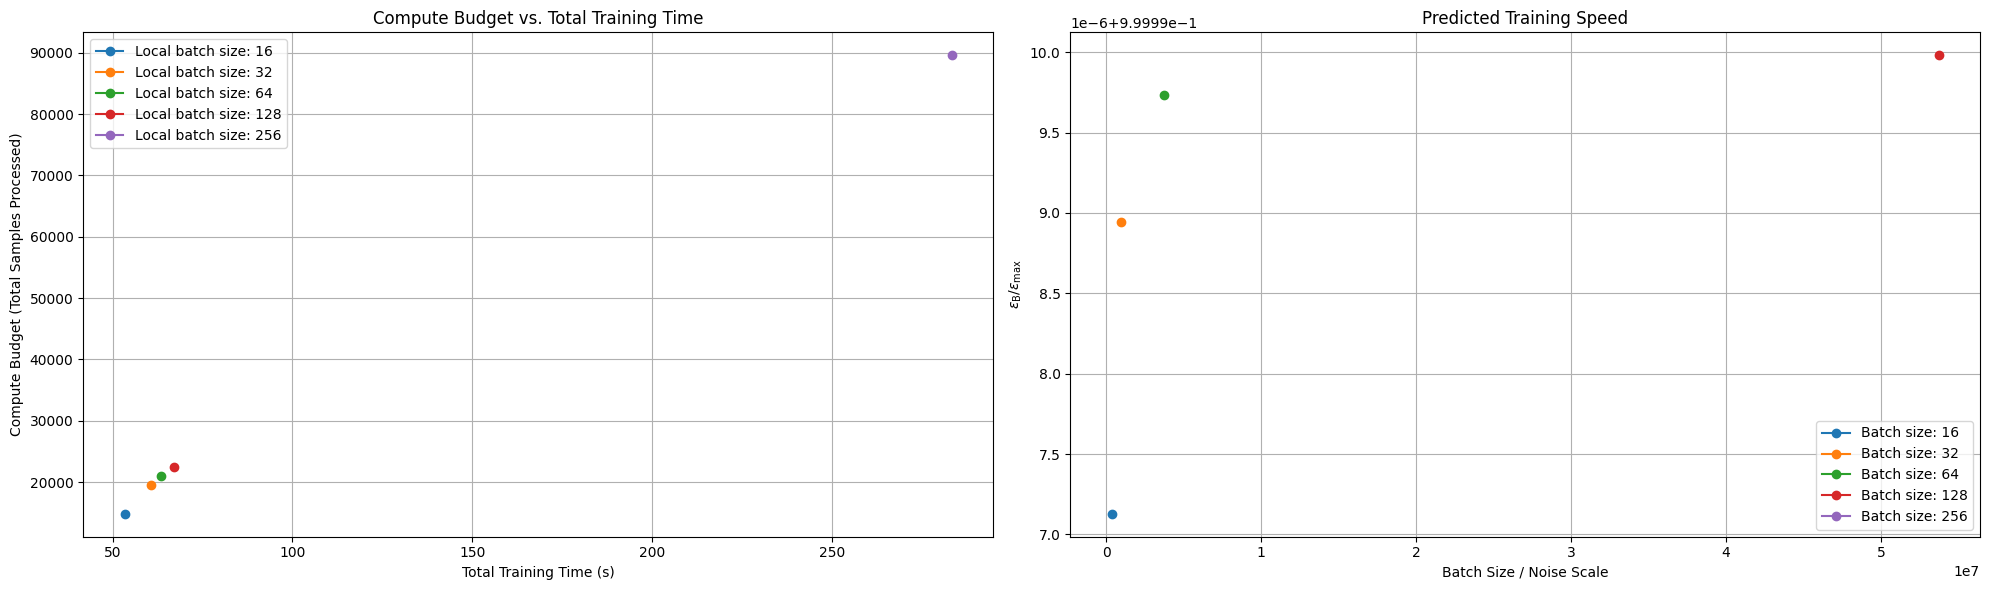

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Bottom-left: Compute Budget vs Training Time
for batch_size, params, hist in total_batch_results:
    times = []
    samples = []
    for round_idx, round_metrics in hist.metrics_distributed_fit['training_time']:
        round_times = [t for _, t in round_metrics['all']]
        times.append(np.mean(round_times))
        
    for round_idx, round_metrics in hist.metrics_distributed_fit['samples_processed']:
        round_samples = [s for _, s in round_metrics['all']]
        samples.append(np.sum(round_samples))
    
    cumulative_time = np.sum(times)
    total_samples = np.sum(samples)
    axes[0].plot(cumulative_time, total_samples, marker='o', label=f"Local batch size: {batch_size}")

axes[0].set_xlabel("Total Training Time (s)")
axes[0].set_ylabel("Compute Budget (Total Samples Processed)")
axes[0].set_title("Compute Budget vs. Total Training Time")
axes[0].legend()
axes[0].grid(True)

# Bottom-right: Noise Scale Analysis
for batch_size, params, hist in total_batch_results:
    noise_scales = []
    for round_idx, round_metrics in hist.metrics_distributed_fit['noise_scale']:
        round_noise_scales = [ns for _, ns in round_metrics['all']]
        noise_scale = np.mean(round_noise_scales)
        noise_scales.append(noise_scale)
    
    avg_noise_scale = np.mean(noise_scales)
    x_axis = batch_size / (avg_noise_scale + 1e-10)
    y_axis = 1 / (1 + (avg_noise_scale / batch_size))
    
    axes[1].plot(x_axis, y_axis, marker='o', label=f"Batch size: {batch_size}")

axes[1].set_xlabel("Batch Size / Noise Scale")
axes[1].set_ylabel(fr"${{\epsilon_\text{{B}}}} / {{\epsilon_\text{{max}}}}$")
axes[1].set_title("Predicted Training Speed")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [15]:
for batch_size, params, hist in total_batch_results:
    print("Batch size: ", batch_size)

    noise_scales = hist.metrics_distributed_fit['noise_scale']

    crit_batches = []
    for round, round_noise_scales in noise_scales:
        actual_noise_scales = [val for _, val in round_noise_scales['all']]
        crit_batch = compute_critical_batch(actual_noise_scales, .001)
        print("---", crit_batch)
        crit_batches.append(crit_batch)
    print(np.mean(crit_batches)) 

Batch size:  16
--- 18.766865656216236
--- 34.7384149865418
--- 28.32672378663889
--- 30.214032438810214
--- 25.944803104863674
--- 16.109365755568458
--- 19.466641673954822
--- 15.3266701695093
23.611689696512926
Batch size:  32
--- 12.131491711033153
--- 50.59698187707439
--- 36.635506870885614
--- 52.74169707497669
--- 31.445206875725138
--- 31.306328481935015
--- 56.772839696596826
--- 45.189769895607625
--- 18.116236141728173
--- 36.68147396023154
--- 26.377297174617276
36.1813481600374
Batch size:  64
--- 35.44498545169905
--- 42.80678347151838
--- 58.84106296249989
--- 107.22854271335508
--- 95.66838743283228
--- 76.5662563892989
--- 77.54001378637857
--- 49.73289699987921
--- 74.99998024996974
--- 44.87090357399485
--- 63.99211962603712
--- 44.11127459690443
--- 68.60168029221713
64.64652981127574
Batch size:  128
--- 97.20765465660982
--- 100000.0
--- 5256.221896363433
--- 1442.509586349392
--- 301.7798953006922
--- 334.9810312935573
--- 684.3617380513921
--- 686.1176414473465

When running FL experiments with multiple batch sizes, we do observe that there must be something as "critical" batch size.

However, we must investigate how to identify it.

## **Running FL with varying cohort sizes**

In [16]:
total_cohort_results = []

for cohort_size in cohort_sizes:
    train_cfg = federated_train_config.copy()
    ratio = np.sqrt(cohort_size / 100)
    train_cfg["client_learning_rate"] = ratio * 0.01

    test_cfg = federated_test_config.copy()

    parameters_for_each_round, hist = run_simulation(
        num_rounds = num_rounds,
        num_total_clients = num_total_clients,
        num_clients_per_round = cohort_size,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = cohort_size,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        )

    total_cohort_results.append((cohort_size, parameters_for_each_round, hist))

INFO flwr 2025-02-28 01:25:51,512 | experiments_simulation.py:165 | FL will execute for 10 rounds


INFO flwr 2025-02-28 01:25:51,514 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-28 01:25:51,515 | server_returns_parameters.py:81 | Initializing global parameters


INFO flwr 2025-02-28 01:25:51,515 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-28 01:25:51,517 | server_returns_parameters.py:84 | Evaluating initial parameters



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▍                                                                                                               | 19/891 [00:00<00:04, 189.39it/s]


  4%|████▊                                                                                                             | 38/891 [00:00<00:08, 103.12it/s]


  6%|██████▌                                                                                                            | 51/891 [00:00<00:09, 93.07it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:09, 88.38it/s]


  8%|█████████▎                                                                                                         | 72/891 [00:00<00:09, 85.49it/s]


  9%|██████████▍                                                                                                        | 81/891 [00:00<00:09, 83.46it/s]


 10%|███████████▌                                                                                                       | 90/891 [00:00<00:09, 83.38it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:09, 82.63it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 88.43it/s]


INFO flwr 2025-02-28 01:25:52,798 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}


INFO flwr 2025-02-28 01:25:52,798 | server_returns_parameters.py:97 | FL starting


DEBUG flwr 2025-02-28 01:25:52,799 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-28 01:25:52,800 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:25:52,802 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:25:52,803 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:25:52,808 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:25:52,811 | flwr_core.py:105 | cid: 1287


DEBUG flwr 2025-02-28 01:25:56,165 | server_returns_parameters.py:237 | fit_round 1 received 5 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 202.05it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:07, 113.73it/s]


  6%|███████▏                                                                                                          | 56/891 [00:00<00:08, 100.85it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:09, 89.76it/s]


  9%|██████████                                                                                                         | 78/891 [00:00<00:09, 85.55it/s]


 10%|███████████▏                                                                                                       | 87/891 [00:00<00:09, 83.33it/s]


 11%|████████████▍                                                                                                      | 96/891 [00:01<00:09, 82.18it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 90.51it/s]


INFO flwr 2025-02-28 01:25:57,413 | server_returns_parameters.py:120 | fit progress: (1, 370.5446116924286, {'accuracy': 0.1209375}, 4.613652497995645)


INFO flwr 2025-02-28 01:25:57,413 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-28 01:25:57,414 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-28 01:25:57,415 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:25:57,418 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:25:57,420 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:25:57,423 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:25:57,426 | flwr_core.py:105 | cid: 2782


DEBUG flwr 2025-02-28 01:26:01,125 | server_returns_parameters.py:237 | fit_round 2 received 5 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▊                                                                                                               | 22/891 [00:00<00:03, 219.55it/s]


  5%|█████▋                                                                                                            | 44/891 [00:00<00:07, 109.95it/s]


  7%|███████▍                                                                                                          | 58/891 [00:00<00:08, 100.54it/s]


  8%|█████████                                                                                                          | 70/891 [00:00<00:08, 97.01it/s]


  9%|██████████▍                                                                                                        | 81/891 [00:00<00:09, 88.90it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:00<00:09, 88.43it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 96.10it/s]


INFO flwr 2025-02-28 01:26:02,310 | server_returns_parameters.py:120 | fit progress: (2, 307.95208263397217, {'accuracy': 0.21375}, 9.51070132793393)


INFO flwr 2025-02-28 01:26:02,310 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-28 01:26:02,311 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-28 01:26:02,311 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:26:02,314 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:26:02,315 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:26:02,317 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:26:02,318 | flwr_core.py:105 | cid: 275


DEBUG flwr 2025-02-28 01:26:05,780 | server_returns_parameters.py:237 | fit_round 3 received 5 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▎                                                                                                               | 18/891 [00:00<00:04, 177.72it/s]


  4%|████▌                                                                                                             | 36/891 [00:00<00:06, 122.47it/s]


  6%|██████▍                                                                                                           | 50/891 [00:00<00:08, 104.15it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:08, 96.92it/s]


  8%|█████████▍                                                                                                         | 73/891 [00:00<00:08, 94.29it/s]


  9%|██████████▋                                                                                                        | 83/891 [00:00<00:08, 92.98it/s]


 10%|████████████                                                                                                       | 93/891 [00:00<00:08, 91.96it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 97.84it/s]

INFO flwr 2025-02-28 01:26:06,944 | server_returns_parameters.py:120 | fit progress: (3, 280.22183549404144, {'accuracy': 0.3178125}, 14.145226084976457)


INFO flwr 2025-02-28 01:26:06,945 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-28 01:26:06,946 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-28 01:26:06,947 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:26:06,950 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:26:06,953 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:26:06,955 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:26:06,957 | flwr_core.py:105 | cid: 2471


DEBUG flwr 2025-02-28 01:26:09,384 | server_returns_parameters.py:237 | fit_round 4 received 5 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 202.89it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:07, 109.57it/s]


  6%|███████▏                                                                                                           | 56/891 [00:00<00:08, 97.68it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:08, 93.73it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:00<00:08, 92.31it/s]


 10%|███████████▏                                                                                                       | 87/891 [00:00<00:08, 90.72it/s]


 11%|████████████▌                                                                                                      | 97/891 [00:01<00:08, 88.36it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 94.52it/s]


INFO flwr 2025-02-28 01:26:10,585 | server_returns_parameters.py:120 | fit progress: (4, 244.85200786590576, {'accuracy': 0.42125}, 17.786514865932986)


INFO flwr 2025-02-28 01:26:10,586 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-28 01:26:10,586 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-28 01:26:10,587 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:26:10,589 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:26:10,590 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:26:10,592 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:26:10,596 | flwr_core.py:105 | cid: 3175


DEBUG flwr 2025-02-28 01:26:13,771 | server_returns_parameters.py:237 | fit_round 5 received 5 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 206.77it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:07, 113.94it/s]


  6%|███████▏                                                                                                          | 56/891 [00:00<00:08, 102.43it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:08, 94.60it/s]


  9%|██████████▏                                                                                                        | 79/891 [00:00<00:08, 91.53it/s]


 10%|███████████▍                                                                                                       | 89/891 [00:00<00:09, 88.68it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:09, 87.23it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 95.28it/s]


INFO flwr 2025-02-28 01:26:14,975 | server_returns_parameters.py:120 | fit progress: (5, 253.71549332141876, {'accuracy': 0.396875}, 22.176160353934392)


INFO flwr 2025-02-28 01:26:14,976 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-28 01:26:14,977 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-28 01:26:14,978 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:26:14,980 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:26:14,981 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:26:14,982 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:26:14,985 | flwr_core.py:105 | cid: 2614


DEBUG flwr 2025-02-28 01:26:17,352 | server_returns_parameters.py:237 | fit_round 6 received 5 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▊                                                                                                               | 22/891 [00:00<00:04, 214.81it/s]


  5%|█████▋                                                                                                            | 44/891 [00:00<00:07, 108.11it/s]


  7%|███████▍                                                                                                           | 58/891 [00:00<00:08, 97.24it/s]


  8%|█████████                                                                                                          | 70/891 [00:00<00:08, 92.35it/s]


  9%|██████████▎                                                                                                        | 80/891 [00:00<00:09, 89.78it/s]


 10%|███████████▌                                                                                                       | 90/891 [00:00<00:09, 88.60it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 87.43it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 94.25it/s]


INFO flwr 2025-02-28 01:26:18,555 | server_returns_parameters.py:120 | fit progress: (6, 241.68832159042358, {'accuracy': 0.4465625}, 25.75616056099534)


INFO flwr 2025-02-28 01:26:18,555 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-28 01:26:18,556 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-28 01:26:18,557 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:26:18,559 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:26:18,562 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:26:18,564 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:26:18,566 | flwr_core.py:105 | cid: 2907


DEBUG flwr 2025-02-28 01:26:21,539 | server_returns_parameters.py:237 | fit_round 7 received 5 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 203.43it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:07, 117.40it/s]


  6%|███████▏                                                                                                          | 56/891 [00:00<00:08, 102.47it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:08, 95.27it/s]


  9%|██████████▏                                                                                                        | 79/891 [00:00<00:08, 91.81it/s]


 10%|███████████▍                                                                                                       | 89/891 [00:00<00:09, 88.69it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:09, 86.94it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 95.51it/s]


INFO flwr 2025-02-28 01:26:22,734 | server_returns_parameters.py:120 | fit progress: (7, 243.47910976409912, {'accuracy': 0.445}, 29.93494233302772)


INFO flwr 2025-02-28 01:26:22,734 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-28 01:26:22,735 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-28 01:26:22,736 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:26:22,737 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:26:22,739 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:26:22,741 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:26:22,742 | flwr_core.py:105 | cid: 3020


DEBUG flwr 2025-02-28 01:26:24,871 | server_returns_parameters.py:237 | fit_round 8 received 5 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 205.21it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:07, 111.55it/s]


  6%|███████▏                                                                                                           | 56/891 [00:00<00:08, 95.99it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:09, 89.12it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:00<00:09, 88.25it/s]


 10%|███████████▏                                                                                                       | 87/891 [00:00<00:09, 87.18it/s]


 11%|████████████▌                                                                                                      | 97/891 [00:01<00:08, 89.01it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 94.08it/s]


INFO flwr 2025-02-28 01:26:26,076 | server_returns_parameters.py:120 | fit progress: (8, 207.76125359535217, {'accuracy': 0.49375}, 33.27668500493746)


INFO flwr 2025-02-28 01:26:26,077 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-28 01:26:26,078 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-28 01:26:26,079 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:26:26,082 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:26:26,084 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:26:26,086 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:26:26,089 | flwr_core.py:105 | cid: 1770


DEBUG flwr 2025-02-28 01:26:29,109 | server_returns_parameters.py:237 | fit_round 9 received 5 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 201.15it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:07, 109.36it/s]


  6%|███████▏                                                                                                          | 56/891 [00:00<00:08, 100.35it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:08, 95.74it/s]


  9%|██████████▏                                                                                                        | 79/891 [00:00<00:08, 92.68it/s]


 10%|███████████▍                                                                                                       | 89/891 [00:00<00:08, 91.43it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:08, 88.77it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 95.87it/s]


INFO flwr 2025-02-28 01:26:30,298 | server_returns_parameters.py:120 | fit progress: (9, 262.97781920433044, {'accuracy': 0.3915625}, 37.49870338791516)


INFO flwr 2025-02-28 01:26:30,298 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-28 01:26:30,299 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-28 01:26:30,299 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:26:30,301 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:26:30,303 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:26:30,305 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:26:30,308 | flwr_core.py:105 | cid: 1852


DEBUG flwr 2025-02-28 01:26:32,076 | server_returns_parameters.py:237 | fit_round 10 received 5 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 206.79it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:07, 109.43it/s]


  6%|███████▏                                                                                                           | 56/891 [00:00<00:08, 97.86it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:08, 92.27it/s]


  9%|██████████                                                                                                         | 78/891 [00:00<00:09, 89.49it/s]


 10%|███████████▎                                                                                                       | 88/891 [00:00<00:09, 86.43it/s]


 11%|████████████▌                                                                                                      | 97/891 [00:01<00:09, 85.02it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 92.55it/s]


INFO flwr 2025-02-28 01:26:33,303 | server_returns_parameters.py:120 | fit progress: (10, 207.17345088720322, {'accuracy': 0.5090625}, 40.50399627292063)


INFO flwr 2025-02-28 01:26:33,303 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


INFO flwr 2025-02-28 01:26:33,304 | server_returns_parameters.py:150 | FL finished in 40.50480121001601


INFO flwr 2025-02-28 01:26:33,304 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-28 01:26:33,305 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.10565958748902043, 'all': [(4, 0.09818555228412151), (8, 0.10823167115449905), (4, 0.10628992132842541), (8, 0.10429108515381813), (7, 0.10819475246327263)]}), (2, {'avg': 0.07234205757126663, 'all': [(5, 0.0818282887339592), (8, 0.06826606905087829), (4, 0.09276132471859455), (5, 0.0843994900584221), (11, 0.05808865041895346)]}), (3, {'avg': 0.05348719707266851, 'all': [(10, 0.04792364537715912), (7, 0.06478514788406235), (8, 0.042618337320163846), (4, 0.049445112235844135), (4, 0.07340446673333645)]}), (4, {'avg': 0.037775887599722904, 'all': [(4, 0.04703175462782383), (5, 0.03852110877633095), (4, 0.035851589404046535), (4, 0.03539664810523391), (5, 0.033068802952766416)]}), (5, {'avg': 0.034203497258325416, 'all': [(8, 0.035097850020974874), (4, 0.03121413988992572), (10, 0.034966851212084295), (4, 0.033641007263213396), (4, 0.03405825421214104)]}), (6, {'avg': 0.02889404

INFO flwr 2025-02-28 01:26:33,305 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-28 01:26:33,305 | app.py:253 | app_fit: losses_centralized [(0, 413.6843070983887), (1, 370.5446116924286), (2, 307.95208263397217), (3, 280.22183549404144), (4, 244.85200786590576), (5, 253.71549332141876), (6, 241.68832159042358), (7, 243.47910976409912), (8, 207.76125359535217), (9, 262.97781920433044), (10, 207.17345088720322)]


INFO flwr 2025-02-28 01:26:33,305 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.0065625), (1, 0.1209375), (2, 0.21375), (3, 0.3178125), (4, 0.42125), (5, 0.396875), (6, 0.4465625), (7, 0.445), (8, 0.49375), (9, 0.3915625), (10, 0.5090625)]}


INFO flwr 2025-02-28 01:26:33,317 | experiments_simulation.py:165 | FL will execute for 10 rounds


INFO flwr 2025-02-28 01:26:33,319 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-28 01:26:33,320 | server_returns_parameters.py:81 | Initializing global parameters


INFO flwr 2025-02-28 01:26:33,321 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-28 01:26:33,322 | server_returns_parameters.py:84 | Evaluating initial parameters



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▍                                                                                                               | 19/891 [00:00<00:04, 187.32it/s]


  4%|████▊                                                                                                             | 38/891 [00:00<00:07, 115.44it/s]


  6%|██████▋                                                                                                           | 52/891 [00:00<00:08, 100.67it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:08, 95.14it/s]


  8%|█████████▍                                                                                                         | 73/891 [00:00<00:09, 90.20it/s]


  9%|██████████▋                                                                                                        | 83/891 [00:00<00:08, 90.11it/s]


 10%|████████████                                                                                                       | 93/891 [00:00<00:09, 88.26it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 93.86it/s]


INFO flwr 2025-02-28 01:26:34,548 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}


INFO flwr 2025-02-28 01:26:34,549 | server_returns_parameters.py:97 | FL starting


DEBUG flwr 2025-02-28 01:26:34,549 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:26:34,550 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:26:34,553 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:26:34,555 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:26:34,556 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:26:34,559 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:26:34,561 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:26:34,564 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:26:34,567 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:26:34,569 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:26:34,570 | flwr_core.py:105 | cid: 2782


DEBUG flwr 2025-02-28 01:26:42,387 | server_returns_parameters.py:237 | fit_round 1 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▏                                                                                                               | 17/891 [00:00<00:05, 165.55it/s]


  4%|████▎                                                                                                             | 34/891 [00:00<00:07, 113.20it/s]


  5%|██████                                                                                                             | 47/891 [00:00<00:08, 95.48it/s]


  7%|███████▍                                                                                                           | 58/891 [00:00<00:09, 90.87it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:09, 86.30it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:00<00:09, 84.51it/s]


 10%|███████████                                                                                                        | 86/891 [00:00<00:09, 82.69it/s]


 11%|████████████▎                                                                                                      | 95/891 [00:01<00:09, 82.26it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:08, 88.29it/s]


INFO flwr 2025-02-28 01:26:43,694 | server_returns_parameters.py:120 | fit progress: (1, 374.5705215930939, {'accuracy': 0.071875}, 9.145026962971315)


INFO flwr 2025-02-28 01:26:43,694 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-28 01:26:43,695 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:26:43,696 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:26:43,698 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:26:43,699 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:26:43,701 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:26:43,708 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:26:43,710 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:26:43,715 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:26:43,718 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:26:43,723 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:26:43,727 | flwr_core.py:105 | cid: 1260


DEBUG flwr 2025-02-28 01:26:50,863 | server_returns_parameters.py:237 | fit_round 2 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▍                                                                                                               | 19/891 [00:00<00:04, 186.58it/s]


  4%|████▊                                                                                                             | 38/891 [00:00<00:08, 103.86it/s]


  6%|██████▌                                                                                                            | 51/891 [00:00<00:09, 91.95it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:10, 82.48it/s]


  8%|█████████▏                                                                                                         | 71/891 [00:00<00:10, 79.63it/s]


  9%|██████████▎                                                                                                        | 80/891 [00:00<00:10, 78.05it/s]


 10%|███████████▍                                                                                                       | 89/891 [00:01<00:10, 78.94it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:10, 78.34it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 83.73it/s]


INFO flwr 2025-02-28 01:26:52,211 | server_returns_parameters.py:120 | fit progress: (2, 302.92192554473877, {'accuracy': 0.2990625}, 17.66253783099819)


INFO flwr 2025-02-28 01:26:52,212 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-28 01:26:52,213 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:26:52,214 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:26:52,216 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:26:52,219 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:26:52,222 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:26:52,223 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:26:52,227 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:26:52,232 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:26:52,233 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:26:52,238 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:26:52,246 | flwr_core.py:105 | cid: 1009


DEBUG flwr 2025-02-28 01:26:58,552 | server_returns_parameters.py:237 | fit_round 3 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|█▊                                                                                                                | 14/891 [00:00<00:06, 131.90it/s]


  3%|███▌                                                                                                              | 28/891 [00:00<00:07, 114.77it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:08, 94.83it/s]


  6%|██████▍                                                                                                            | 50/891 [00:00<00:09, 91.11it/s]


  7%|███████▋                                                                                                           | 60/891 [00:00<00:10, 82.96it/s]


  8%|████████▉                                                                                                          | 69/891 [00:00<00:11, 73.45it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:00<00:11, 70.89it/s]


 10%|██████████▉                                                                                                        | 85/891 [00:01<00:11, 71.35it/s]


 10%|████████████                                                                                                       | 93/891 [00:01<00:10, 73.42it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 79.28it/s]


INFO flwr 2025-02-28 01:27:00,047 | server_returns_parameters.py:120 | fit progress: (3, 244.5242544412613, {'accuracy': 0.4221875}, 25.49845913297031)


INFO flwr 2025-02-28 01:27:00,048 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-28 01:27:00,049 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:27:00,049 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:27:00,052 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:27:00,055 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:27:00,059 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:27:00,063 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:27:00,066 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:27:00,069 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:27:00,071 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:27:00,075 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:27:00,080 | flwr_core.py:105 | cid: 1258


DEBUG flwr 2025-02-28 01:27:06,120 | server_returns_parameters.py:237 | fit_round 4 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 204.27it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:05, 159.92it/s]


  7%|███████▊                                                                                                          | 61/891 [00:00<00:04, 169.02it/s]


  9%|██████████▎                                                                                                       | 81/891 [00:00<00:04, 178.86it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:04, 178.08it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:04, 173.73it/s]


INFO flwr 2025-02-28 01:27:06,874 | server_returns_parameters.py:120 | fit progress: (4, 254.24587786197662, {'accuracy': 0.428125}, 32.325544487917796)


INFO flwr 2025-02-28 01:27:06,875 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-28 01:27:06,876 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:27:06,876 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:27:06,877 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:27:06,879 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:27:06,882 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:27:06,884 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:27:06,886 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:27:06,887 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:27:06,889 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:27:06,891 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:27:06,895 | flwr_core.py:105 | cid: 937


DEBUG flwr 2025-02-28 01:27:12,961 | server_returns_parameters.py:237 | fit_round 5 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 83.68it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 85.91it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 85.86it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:09, 85.92it/s]


  5%|█████▊                                                                                                             | 45/891 [00:00<00:09, 85.57it/s]


  6%|██████▉                                                                                                            | 54/891 [00:00<00:09, 86.09it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:09, 83.22it/s]


  8%|█████████▎                                                                                                         | 72/891 [00:00<00:09, 83.26it/s]


  9%|██████████▍                                                                                                        | 81/891 [00:00<00:09, 84.46it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:09, 87.76it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 86.52it/s]


INFO flwr 2025-02-28 01:27:14,266 | server_returns_parameters.py:120 | fit progress: (5, 269.7255879640579, {'accuracy': 0.3634375}, 39.716819916968234)


INFO flwr 2025-02-28 01:27:14,266 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-28 01:27:14,268 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:27:14,269 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:27:14,271 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:27:14,274 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:27:14,275 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:27:14,279 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:27:14,282 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:27:14,287 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:27:14,289 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:27:14,293 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:27:14,295 | flwr_core.py:105 | cid: 2907


DEBUG flwr 2025-02-28 01:27:20,845 | server_returns_parameters.py:237 | fit_round 6 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▍                                                                                                                | 11/891 [00:00<00:08, 103.53it/s]


  2%|██▊                                                                                                                | 22/891 [00:00<00:09, 96.21it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:09, 89.32it/s]


  5%|█████▍                                                                                                             | 42/891 [00:00<00:09, 90.31it/s]


  6%|██████▋                                                                                                            | 52/891 [00:00<00:09, 89.89it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:09, 85.37it/s]


  8%|█████████▏                                                                                                         | 71/891 [00:00<00:09, 86.42it/s]


  9%|██████████▎                                                                                                        | 80/891 [00:00<00:09, 86.24it/s]


 10%|███████████▍                                                                                                       | 89/891 [00:01<00:09, 85.26it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:09, 86.05it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 87.02it/s]


INFO flwr 2025-02-28 01:27:22,230 | server_returns_parameters.py:120 | fit progress: (6, 237.57622200250626, {'accuracy': 0.50375}, 47.68074532796163)


INFO flwr 2025-02-28 01:27:22,230 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-28 01:27:22,231 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:27:22,231 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:27:22,234 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:27:22,237 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:27:22,240 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:27:22,241 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:27:22,243 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:27:22,245 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:27:22,246 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:27:22,247 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:27:22,250 | flwr_core.py:105 | cid: 2343


DEBUG flwr 2025-02-28 01:27:29,546 | server_returns_parameters.py:237 | fit_round 7 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▌                                                                                                                | 12/891 [00:00<00:08, 106.46it/s]


  3%|██▉                                                                                                                | 23/891 [00:00<00:09, 89.58it/s]


  4%|████▍                                                                                                              | 34/891 [00:00<00:08, 97.29it/s]


  5%|██████▏                                                                                                           | 48/891 [00:00<00:07, 110.21it/s]


  7%|███████▉                                                                                                          | 62/891 [00:00<00:07, 117.89it/s]


  9%|█████████▋                                                                                                        | 76/891 [00:00<00:06, 122.63it/s]


 10%|███████████▌                                                                                                      | 90/891 [00:00<00:06, 126.41it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:06, 117.10it/s]


INFO flwr 2025-02-28 01:27:30,633 | server_returns_parameters.py:120 | fit progress: (7, 228.08820521831512, {'accuracy': 0.4759375}, 56.08434921002481)


INFO flwr 2025-02-28 01:27:30,634 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-28 01:27:30,635 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:27:30,636 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:27:30,638 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:27:30,640 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:27:30,642 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:27:30,645 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:27:30,647 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:27:30,649 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:27:30,653 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:27:30,658 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:27:30,660 | flwr_core.py:105 | cid: 3178


DEBUG flwr 2025-02-28 01:27:36,281 | server_returns_parameters.py:237 | fit_round 8 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▋                                                                                                               | 21/891 [00:00<00:04, 204.69it/s]


  5%|█████▎                                                                                                            | 42/891 [00:00<00:04, 203.79it/s]


  7%|████████                                                                                                          | 63/891 [00:00<00:04, 201.64it/s]


  9%|██████████▋                                                                                                       | 84/891 [00:00<00:03, 202.07it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:03, 203.83it/s]


INFO flwr 2025-02-28 01:27:36,918 | server_returns_parameters.py:120 | fit progress: (8, 189.27203091979027, {'accuracy': 0.5678125}, 62.369278236990795)


INFO flwr 2025-02-28 01:27:36,919 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-28 01:27:36,919 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:27:36,920 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:27:36,921 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:27:36,923 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:27:36,927 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:27:36,930 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:27:36,932 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:27:36,933 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:27:36,936 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:27:36,942 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:27:36,948 | flwr_core.py:105 | cid: 70


DEBUG flwr 2025-02-28 01:27:43,680 | server_returns_parameters.py:237 | fit_round 9 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 85.77it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:09, 88.02it/s]


  3%|███▌                                                                                                               | 28/891 [00:00<00:09, 91.94it/s]


  4%|████▉                                                                                                              | 38/891 [00:00<00:09, 90.86it/s]


  5%|██████▏                                                                                                            | 48/891 [00:00<00:09, 92.36it/s]


  7%|███████▍                                                                                                           | 58/891 [00:00<00:09, 92.48it/s]


  8%|█████████                                                                                                          | 70/891 [00:00<00:08, 99.49it/s]


  9%|██████████▍                                                                                                       | 82/891 [00:00<00:07, 104.34it/s]


 11%|████████████                                                                                                      | 94/891 [00:00<00:07, 108.07it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:07, 98.91it/s]


INFO flwr 2025-02-28 01:27:44,868 | server_returns_parameters.py:120 | fit progress: (9, 213.14875066280365, {'accuracy': 0.535}, 70.3189174629515)


INFO flwr 2025-02-28 01:27:44,868 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-28 01:27:44,869 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-28 01:27:44,870 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:27:44,872 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:27:44,875 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:27:44,878 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:27:44,880 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:27:44,883 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:27:44,884 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:27:44,885 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:27:44,887 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:27:44,889 | flwr_core.py:105 | cid: 2274


DEBUG flwr 2025-02-28 01:27:51,667 | server_returns_parameters.py:237 | fit_round 10 received 10 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▍                                                                                                                | 11/891 [00:00<00:08, 106.44it/s]


  3%|██▉                                                                                                               | 23/891 [00:00<00:07, 112.16it/s]


  4%|████▍                                                                                                             | 35/891 [00:00<00:07, 111.92it/s]


  5%|██████                                                                                                            | 47/891 [00:00<00:07, 109.66it/s]


  7%|███████▍                                                                                                          | 58/891 [00:00<00:07, 108.53it/s]


  8%|████████▊                                                                                                         | 69/891 [00:00<00:07, 108.59it/s]


  9%|██████████▎                                                                                                       | 81/891 [00:00<00:07, 111.83it/s]


 10%|███████████▉                                                                                                      | 93/891 [00:00<00:07, 113.92it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:07, 110.18it/s]


INFO flwr 2025-02-28 01:27:52,736 | server_returns_parameters.py:120 | fit progress: (10, 227.2877472639084, {'accuracy': 0.491875}, 78.18683011492249)


INFO flwr 2025-02-28 01:27:52,736 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


INFO flwr 2025-02-28 01:27:52,737 | server_returns_parameters.py:150 | FL finished in 78.18782845302485


INFO flwr 2025-02-28 01:27:52,737 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-28 01:27:52,738 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.10129949066322297, 'all': [(8, 0.0904895169660449), (11, 0.09691431441090324), (8, 0.10983669944107533), (4, 0.1009509451687336), (4, 0.09970851615071297), (4, 0.10603524185717106), (8, 0.10630209371447563), (5, 0.09935470521450043), (7, 0.10580879236970629), (5, 0.09997391551733018)]}), (2, {'avg': 0.07291004326889071, 'all': [(4, 0.08352193422615528), (8, 0.05947327567264438), (4, 0.09323608130216599), (4, 0.08395145833492279), (8, 0.07031656429171562), (5, 0.0748570553958416), (10, 0.05457763746380806), (4, 0.08866654150187969), (5, 0.08128833770751953), (7, 0.07705234736204147)]}), (3, {'avg': 0.03706152185511131, 'all': [(5, 0.029597285389900207), (4, 0.04337553400546312), (10, 0.035603902861475946), (5, 0.0373326264321804), (8, 0.027282089926302433), (4, 0.04589029308408499), (4, 0.03944742400199175), (4, 0.0420087780803442), (4, 0.04155659396201372), (4, 0.042284834198

INFO flwr 2025-02-28 01:27:52,738 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-28 01:27:52,739 | app.py:253 | app_fit: losses_centralized [(0, 413.6843070983887), (1, 374.5705215930939), (2, 302.92192554473877), (3, 244.5242544412613), (4, 254.24587786197662), (5, 269.7255879640579), (6, 237.57622200250626), (7, 228.08820521831512), (8, 189.27203091979027), (9, 213.14875066280365), (10, 227.2877472639084)]


INFO flwr 2025-02-28 01:27:52,739 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.0065625), (1, 0.071875), (2, 0.2990625), (3, 0.4221875), (4, 0.428125), (5, 0.3634375), (6, 0.50375), (7, 0.4759375), (8, 0.5678125), (9, 0.535), (10, 0.491875)]}


INFO flwr 2025-02-28 01:27:52,750 | experiments_simulation.py:165 | FL will execute for 10 rounds


INFO flwr 2025-02-28 01:27:52,755 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-28 01:27:52,755 | server_returns_parameters.py:81 | Initializing global parameters


INFO flwr 2025-02-28 01:27:52,756 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-28 01:27:52,757 | server_returns_parameters.py:84 | Evaluating initial parameters



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▌                                                                                                               | 20/891 [00:00<00:04, 190.48it/s]


  4%|█████                                                                                                             | 40/891 [00:00<00:04, 190.67it/s]


  7%|███████▊                                                                                                          | 61/891 [00:00<00:04, 196.48it/s]


  9%|██████████▍                                                                                                       | 82/891 [00:00<00:04, 199.87it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:04, 197.34it/s]


INFO flwr 2025-02-28 01:27:53,409 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}


INFO flwr 2025-02-28 01:27:53,409 | server_returns_parameters.py:97 | FL starting


DEBUG flwr 2025-02-28 01:27:53,410 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-28 01:27:53,411 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:27:53,412 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:27:53,415 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:27:53,421 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:27:53,424 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:27:53,425 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:27:53,427 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:27:53,428 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:27:53,431 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:27:53,431 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:27:53,435 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:27:53,436 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:27:53,439 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:27:53,442 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:27:53,444 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:27:53,450 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:27:53,453 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:27:53,455 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:27:53,466 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:27:53,473 | flwr_core.py:105 | cid: 2364


DEBUG flwr 2025-02-28 01:28:08,348 | server_returns_parameters.py:237 | fit_round 1 received 20 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██▎                                                                                                               | 18/891 [00:00<00:04, 179.72it/s]


  4%|████▊                                                                                                             | 38/891 [00:00<00:04, 189.56it/s]


  6%|███████▎                                                                                                          | 57/891 [00:00<00:04, 184.89it/s]


  9%|█████████▋                                                                                                        | 76/891 [00:00<00:05, 158.56it/s]


 11%|████████████                                                                                                      | 94/891 [00:00<00:04, 164.99it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:04, 168.30it/s]


INFO flwr 2025-02-28 01:28:09,127 | server_returns_parameters.py:120 | fit progress: (1, 380.9852383136749, {'accuracy': 0.075}, 15.717945000971667)


INFO flwr 2025-02-28 01:28:09,128 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-28 01:28:09,129 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-28 01:28:09,130 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:28:09,132 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:28:09,135 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:28:09,139 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:28:09,140 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:28:09,144 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:28:09,148 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:28:09,151 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:28:09,156 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:28:09,159 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:28:09,164 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:28:09,166 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:28:09,168 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:28:09,172 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:28:09,174 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:28:09,176 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:28:09,179 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:28:09,180 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:28:09,189 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:28:09,190 | flwr_core.py:105 | cid: 2504


DEBUG flwr 2025-02-28 01:28:21,312 | server_returns_parameters.py:237 | fit_round 2 received 20 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|█▉                                                                                                                | 15/891 [00:00<00:06, 144.12it/s]


  3%|███▊                                                                                                              | 30/891 [00:00<00:06, 134.19it/s]


  5%|██████▏                                                                                                           | 48/891 [00:00<00:05, 152.18it/s]


  7%|████████▏                                                                                                         | 64/891 [00:00<00:06, 129.73it/s]


  9%|██████████▍                                                                                                       | 82/891 [00:00<00:05, 144.42it/s]


 11%|████████████▋                                                                                                    | 100/891 [00:00<00:05, 149.46it/s]


INFO flwr 2025-02-28 01:28:22,162 | server_returns_parameters.py:120 | fit progress: (2, 296.6401159763336, {'accuracy': 0.3071875}, 28.752492042956874)


INFO flwr 2025-02-28 01:28:22,162 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-28 01:28:22,163 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-28 01:28:22,164 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:28:22,165 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:28:22,167 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:28:22,170 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:28:22,174 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:28:22,178 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:28:22,181 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:28:22,184 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:28:22,186 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:28:22,188 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:28:22,191 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:28:22,194 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:28:22,197 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:28:22,201 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:28:22,205 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:28:22,210 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:28:22,213 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:28:22,218 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:28:22,220 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:28:22,224 | flwr_core.py:105 | cid: 2434


DEBUG flwr 2025-02-28 01:28:35,075 | server_returns_parameters.py:237 | fit_round 3 received 20 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 78.41it/s]


  2%|██▏                                                                                                                | 17/891 [00:00<00:10, 80.65it/s]


  3%|███▎                                                                                                               | 26/891 [00:00<00:10, 79.48it/s]


  4%|████▍                                                                                                              | 34/891 [00:00<00:10, 78.76it/s]


  5%|█████▍                                                                                                             | 42/891 [00:00<00:10, 78.25it/s]


  6%|██████▌                                                                                                            | 51/891 [00:00<00:10, 79.59it/s]


  7%|███████▋                                                                                                           | 60/891 [00:00<00:10, 79.94it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:10, 76.83it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:00<00:10, 77.56it/s]


 10%|██████████▉                                                                                                        | 85/891 [00:01<00:10, 78.92it/s]


 11%|████████████▏                                                                                                      | 94/891 [00:01<00:09, 81.06it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 78.84it/s]


INFO flwr 2025-02-28 01:28:36,527 | server_returns_parameters.py:120 | fit progress: (3, 249.713276386261, {'accuracy': 0.405625}, 43.11730407795403)


INFO flwr 2025-02-28 01:28:36,527 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-28 01:28:36,528 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-28 01:28:36,529 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:28:36,529 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:28:36,531 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:28:36,534 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:28:36,537 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:28:36,538 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:28:36,542 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:28:36,548 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:28:36,553 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:28:36,555 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:28:36,557 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:28:36,564 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:28:36,572 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:28:36,576 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:28:36,583 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:28:36,596 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:28:36,601 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:28:36,607 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:28:36,617 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:28:36,618 | flwr_core.py:105 | cid: 1633


DEBUG flwr 2025-02-28 01:28:48,845 | server_returns_parameters.py:237 | fit_round 4 received 20 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:12, 72.23it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:12, 71.71it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:11, 74.28it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:11, 76.26it/s]


  5%|█████▎                                                                                                             | 41/891 [00:00<00:10, 80.68it/s]


  6%|██████▍                                                                                                            | 50/891 [00:00<00:10, 81.04it/s]


  7%|███████▌                                                                                                           | 59/891 [00:00<00:11, 75.63it/s]


  8%|████████▉                                                                                                          | 69/891 [00:00<00:10, 80.80it/s]


  9%|██████████                                                                                                         | 78/891 [00:00<00:09, 82.76it/s]


 10%|███████████▏                                                                                                       | 87/891 [00:01<00:09, 82.57it/s]


 11%|████████████▍                                                                                                      | 96/891 [00:01<00:09, 83.74it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 79.90it/s]


INFO flwr 2025-02-28 01:28:50,335 | server_returns_parameters.py:120 | fit progress: (4, 228.829780459404, {'accuracy': 0.48125}, 56.92576526897028)


INFO flwr 2025-02-28 01:28:50,336 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-28 01:28:50,337 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-28 01:28:50,338 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:28:50,340 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:28:50,343 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:28:50,346 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:28:50,350 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:28:50,354 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:28:50,359 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:28:50,364 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:28:50,366 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:28:50,367 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:28:50,368 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:28:50,369 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:28:50,371 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:28:50,373 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:28:50,375 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:28:50,379 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:28:50,380 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:28:50,381 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:28:50,400 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:28:50,407 | flwr_core.py:105 | cid: 3068


DEBUG flwr 2025-02-28 01:29:04,629 | server_returns_parameters.py:237 | fit_round 5 received 20 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▍                                                                                                                | 11/891 [00:00<00:08, 108.92it/s]


  2%|██▊                                                                                                                | 22/891 [00:00<00:10, 85.76it/s]


  3%|████                                                                                                               | 31/891 [00:00<00:10, 82.87it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:10, 84.93it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:09, 85.12it/s]


  7%|███████▍                                                                                                           | 58/891 [00:00<00:10, 82.88it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:09, 82.88it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:00<00:09, 83.08it/s]


 10%|██████████▉                                                                                                        | 85/891 [00:01<00:09, 81.68it/s]


 11%|████████████▏                                                                                                      | 94/891 [00:01<00:10, 78.60it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 81.64it/s]


INFO flwr 2025-02-28 01:29:06,089 | server_returns_parameters.py:120 | fit progress: (5, 239.24020373821259, {'accuracy': 0.4975}, 72.67951826797798)


INFO flwr 2025-02-28 01:29:06,089 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-28 01:29:06,090 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-28 01:29:06,091 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:29:06,093 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:29:06,096 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:29:06,098 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:29:06,100 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:29:06,103 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:29:06,104 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:29:06,106 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:29:06,108 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:29:06,109 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:29:06,110 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:29:06,113 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:29:06,116 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:29:06,118 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:29:06,121 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:29:06,125 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:29:06,126 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:29:06,129 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:29:06,130 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:29:06,131 | flwr_core.py:105 | cid: 1770


DEBUG flwr 2025-02-28 01:29:18,729 | server_returns_parameters.py:237 | fit_round 6 received 20 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:13, 65.91it/s]


  2%|█▊                                                                                                                 | 14/891 [00:00<00:12, 68.05it/s]


  2%|██▋                                                                                                                | 21/891 [00:00<00:13, 64.33it/s]


  3%|███▊                                                                                                               | 30/891 [00:00<00:11, 71.99it/s]


  4%|█████                                                                                                              | 39/891 [00:00<00:11, 76.82it/s]


  5%|██████▏                                                                                                            | 48/891 [00:00<00:10, 80.03it/s]


  6%|███████▎                                                                                                           | 57/891 [00:00<00:10, 78.78it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:09, 82.73it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:00<00:09, 83.41it/s]


 10%|██████████▉                                                                                                        | 85/891 [00:01<00:10, 79.58it/s]


 11%|████████████▏                                                                                                      | 94/891 [00:01<00:10, 79.00it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 76.87it/s]


INFO flwr 2025-02-28 01:29:20,215 | server_returns_parameters.py:120 | fit progress: (6, 209.01029872894287, {'accuracy': 0.5596875}, 86.80560382292606)


INFO flwr 2025-02-28 01:29:20,216 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-28 01:29:20,217 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-28 01:29:20,218 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:29:20,220 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:29:20,221 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:29:20,223 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:29:20,225 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:29:20,229 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:29:20,233 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:29:20,235 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:29:20,238 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:29:20,240 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:29:20,242 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:29:20,244 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:29:20,247 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:29:20,249 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:29:20,252 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:29:20,254 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:29:20,257 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:29:20,259 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:29:20,265 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:29:20,266 | flwr_core.py:105 | cid: 2736


DEBUG flwr 2025-02-28 01:29:32,793 | server_returns_parameters.py:237 | fit_round 7 received 20 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▋                                                                                                                | 13/891 [00:00<00:06, 127.20it/s]


  3%|███▎                                                                                                               | 26/891 [00:00<00:09, 87.10it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:10, 82.93it/s]


  5%|█████▊                                                                                                             | 45/891 [00:00<00:11, 76.86it/s]


  6%|██████▊                                                                                                            | 53/891 [00:00<00:11, 75.17it/s]


  7%|███████▊                                                                                                           | 61/891 [00:00<00:11, 73.45it/s]


  8%|████████▉                                                                                                          | 69/891 [00:00<00:11, 72.33it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:01<00:11, 71.68it/s]


 10%|██████████▉                                                                                                        | 85/891 [00:01<00:11, 71.74it/s]


 10%|████████████                                                                                                       | 93/891 [00:01<00:11, 67.88it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 73.63it/s]


INFO flwr 2025-02-28 01:29:34,389 | server_returns_parameters.py:120 | fit progress: (7, 189.37704241275787, {'accuracy': 0.6025}, 100.97928480897099)


INFO flwr 2025-02-28 01:29:34,390 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-28 01:29:34,391 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-28 01:29:34,392 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:29:34,394 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:29:34,396 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:29:34,397 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:29:34,400 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:29:34,402 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:29:34,404 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:29:34,408 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:29:34,413 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:29:34,415 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:29:34,420 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:29:34,427 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:29:34,428 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:29:34,430 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:29:34,437 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:29:34,438 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:29:34,442 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:29:34,446 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:29:34,454 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:29:34,460 | flwr_core.py:105 | cid: 2399


DEBUG flwr 2025-02-28 01:29:49,997 | server_returns_parameters.py:237 | fit_round 8 received 20 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▎                                                                                                                 | 10/891 [00:00<00:09, 92.08it/s]


  2%|██▌                                                                                                                | 20/891 [00:00<00:10, 81.18it/s]


  3%|███▋                                                                                                               | 29/891 [00:00<00:12, 69.18it/s]


  4%|████▊                                                                                                              | 37/891 [00:00<00:11, 71.26it/s]


  5%|█████▉                                                                                                             | 46/891 [00:00<00:11, 75.06it/s]


  6%|███████▏                                                                                                           | 56/891 [00:00<00:10, 80.14it/s]


  7%|████████▍                                                                                                          | 65/891 [00:00<00:10, 81.92it/s]


  8%|█████████▌                                                                                                         | 74/891 [00:00<00:09, 83.01it/s]


  9%|██████████▋                                                                                                        | 83/891 [00:01<00:10, 78.44it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:10, 75.68it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:10, 73.85it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 75.68it/s]


INFO flwr 2025-02-28 01:29:51,556 | server_returns_parameters.py:120 | fit progress: (8, 189.81800997257233, {'accuracy': 0.55125}, 118.14658000296913)


INFO flwr 2025-02-28 01:29:51,557 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-28 01:29:51,558 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-28 01:29:51,559 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:29:51,561 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:29:51,564 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:29:51,567 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:29:51,570 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:29:51,574 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:29:51,577 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:29:51,580 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:29:51,585 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:29:51,589 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:29:51,593 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:29:51,596 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:29:51,598 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:29:51,600 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:29:51,604 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:29:51,610 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:29:51,616 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:29:51,619 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:29:51,626 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:29:51,629 | flwr_core.py:105 | cid: 1446


DEBUG flwr 2025-02-28 01:30:07,966 | server_returns_parameters.py:237 | fit_round 9 received 20 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 82.43it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 81.10it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 79.22it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:11, 77.29it/s]


  5%|█████▋                                                                                                             | 44/891 [00:00<00:10, 78.16it/s]


  6%|██████▋                                                                                                            | 52/891 [00:00<00:10, 77.81it/s]


  7%|███████▋                                                                                                           | 60/891 [00:00<00:11, 70.27it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:11, 69.86it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:01<00:11, 69.74it/s]


  9%|██████████▊                                                                                                        | 84/891 [00:01<00:11, 71.52it/s]


 10%|███████████▊                                                                                                       | 92/891 [00:01<00:10, 72.91it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 73.18it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 73.16it/s]


INFO flwr 2025-02-28 01:30:09,486 | server_returns_parameters.py:120 | fit progress: (9, 228.11440533399582, {'accuracy': 0.5196875}, 136.0764339719899)


INFO flwr 2025-02-28 01:30:09,486 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-28 01:30:09,488 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-28 01:30:09,488 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:30:09,491 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:30:09,492 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:30:09,494 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:30:09,495 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:30:09,497 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:30:09,499 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:30:09,499 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:30:09,502 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:30:09,510 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:30:09,512 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:30:09,514 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:30:09,517 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:30:09,517 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:30:09,519 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:30:09,520 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:30:09,523 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:30:09,528 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:30:09,532 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:30:09,536 | flwr_core.py:105 | cid: 2070


DEBUG flwr 2025-02-28 01:30:22,353 | server_returns_parameters.py:237 | fit_round 10 received 20 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:12, 73.47it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:12, 68.96it/s]


  3%|██▉                                                                                                                | 23/891 [00:00<00:12, 68.90it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:11, 73.70it/s]


  5%|█████▎                                                                                                             | 41/891 [00:00<00:11, 76.37it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:11, 71.59it/s]


  6%|███████▎                                                                                                           | 57/891 [00:00<00:11, 72.49it/s]


  7%|████████▍                                                                                                          | 65/891 [00:00<00:11, 71.89it/s]


  8%|█████████▍                                                                                                         | 73/891 [00:01<00:11, 73.14it/s]


  9%|██████████▍                                                                                                        | 81/891 [00:01<00:11, 72.79it/s]


 10%|███████████▍                                                                                                       | 89/891 [00:01<00:11, 71.39it/s]


 11%|████████████▌                                                                                                      | 97/891 [00:01<00:11, 71.04it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 71.18it/s]


INFO flwr 2025-02-28 01:30:23,997 | server_returns_parameters.py:120 | fit progress: (10, 158.79541974514723, {'accuracy': 0.6440625}, 150.58747476898134)


INFO flwr 2025-02-28 01:30:23,997 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


INFO flwr 2025-02-28 01:30:23,998 | server_returns_parameters.py:150 | FL finished in 150.58832020696718


INFO flwr 2025-02-28 01:30:23,998 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-28 01:30:24,000 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.0976862457951879, 'all': [(11, 0.07520389624617317), (8, 0.10044711176306009), (5, 0.10068731755018234), (8, 0.08837016299366951), (4, 0.10472254268825054), (4, 0.1042949128895998), (10, 0.10824742391705514), (8, 0.10765150561928749), (5, 0.08854234367609023), (8, 0.08679637592285872), (4, 0.09905605763196945), (4, 0.097114322707057), (5, 0.08095661997795105), (8, 0.09828589484095573), (7, 0.10084123483725957), (7, 0.11247254482337407), (4, 0.10257120616734028), (4, 0.10377048887312412), (5, 0.10540826469659806), (4, 0.108998853713274)]}), (2, {'avg': 0.07316534514132056, 'all': [(3, 0.0964211995402972), (4, 0.08054487034678459), (4, 0.07739421352744102), (5, 0.059289582818746564), (4, 0.09360180608928204), (9, 0.04799200801385774), (10, 0.062186865136027336), (8, 0.05343833891674876), (5, 0.0723593458533287), (4, 0.08729777298867702), (5, 0.07911192029714584), (3, 0.09304696

INFO flwr 2025-02-28 01:30:24,000 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-28 01:30:24,001 | app.py:253 | app_fit: losses_centralized [(0, 413.6843070983887), (1, 380.9852383136749), (2, 296.6401159763336), (3, 249.713276386261), (4, 228.829780459404), (5, 239.24020373821259), (6, 209.01029872894287), (7, 189.37704241275787), (8, 189.81800997257233), (9, 228.11440533399582), (10, 158.79541974514723)]


INFO flwr 2025-02-28 01:30:24,001 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.0065625), (1, 0.075), (2, 0.3071875), (3, 0.405625), (4, 0.48125), (5, 0.4975), (6, 0.5596875), (7, 0.6025), (8, 0.55125), (9, 0.5196875), (10, 0.6440625)]}


INFO flwr 2025-02-28 01:30:24,017 | experiments_simulation.py:165 | FL will execute for 10 rounds


INFO flwr 2025-02-28 01:30:24,022 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-28 01:30:24,022 | server_returns_parameters.py:81 | Initializing global parameters


INFO flwr 2025-02-28 01:30:24,023 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-28 01:30:24,024 | server_returns_parameters.py:84 | Evaluating initial parameters



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  2%|██                                                                                                                | 16/891 [00:00<00:05, 150.47it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:10, 83.61it/s]


  5%|█████▍                                                                                                             | 42/891 [00:00<00:10, 80.93it/s]


  6%|██████▌                                                                                                            | 51/891 [00:00<00:10, 79.46it/s]


  7%|███████▋                                                                                                           | 60/891 [00:00<00:10, 75.83it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:11, 73.10it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:00<00:11, 70.20it/s]


  9%|██████████▊                                                                                                        | 84/891 [00:01<00:11, 68.37it/s]


 10%|████████████                                                                                                       | 93/891 [00:01<00:11, 71.67it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 75.60it/s]


INFO flwr 2025-02-28 01:30:25,521 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}


INFO flwr 2025-02-28 01:30:25,522 | server_returns_parameters.py:97 | FL starting


DEBUG flwr 2025-02-28 01:30:25,524 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-28 01:30:25,524 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:30:25,527 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:30:25,531 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:30:25,535 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:30:25,537 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:30:25,540 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:30:25,543 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:30:25,547 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:30:25,548 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:30:25,550 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:30:25,552 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:30:25,555 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:30:25,560 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:30:25,563 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:30:25,566 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:30:25,568 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:30:25,570 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:30:25,573 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:30:25,574 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:30:25,582 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:30:25,587 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:30:25,588 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:30:25,592 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:30:25,593 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:30:25,596 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:30:25,603 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:30:25,608 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:30:25,609 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:30:25,613 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:30:25,615 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:30:25,627 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:30:25,638 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:30:37,851 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:30:39,440 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:30:39,554 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:30:40,136 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:30:40,312 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:30:40,999 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:30:42,908 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:30:43,089 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:30:43,625 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:30:44,311 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:30:45,204 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:30:46,212 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:30:46,215 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:30:46,218 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:30:46,323 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:30:46,424 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:30:46,712 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:30:46,792 | flwr_core.py:105 | cid: 2184


DEBUG flwr 2025-02-28 01:31:03,543 | server_returns_parameters.py:237 | fit_round 1 received 50 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:12, 73.21it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:11, 73.19it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:11, 74.94it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:11, 75.38it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:11, 71.93it/s]


  5%|██████▏                                                                                                            | 48/891 [00:00<00:12, 66.94it/s]


  6%|███████                                                                                                            | 55/891 [00:00<00:12, 65.68it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:12, 65.47it/s]


  8%|████████▉                                                                                                          | 69/891 [00:01<00:12, 65.16it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:01<00:11, 68.20it/s]


  9%|██████████▊                                                                                                        | 84/891 [00:01<00:12, 67.07it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:12, 65.30it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:11, 68.70it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 68.02it/s]


INFO flwr 2025-02-28 01:31:05,217 | server_returns_parameters.py:120 | fit progress: (1, 382.7437262535095, {'accuracy': 0.074375}, 39.694707117043436)


INFO flwr 2025-02-28 01:31:05,218 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-28 01:31:05,219 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-28 01:31:05,220 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:31:05,223 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:31:05,226 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:31:05,228 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:31:05,229 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:31:05,231 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:31:05,233 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:31:05,237 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:31:05,240 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:31:05,244 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:31:05,248 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:31:05,251 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:31:05,252 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:31:05,253 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:31:05,256 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:31:05,258 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:31:05,263 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:31:05,267 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:31:05,271 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:31:05,271 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:31:05,274 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:31:05,278 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:31:05,290 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:31:05,294 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:31:05,297 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:31:05,307 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:31:05,309 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:31:05,311 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:31:05,315 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:31:05,326 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:31:05,328 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:31:05,340 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:31:10,805 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:31:19,225 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:31:19,554 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:31:19,646 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:31:21,583 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:31:21,625 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:31:22,828 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:31:22,939 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:31:24,734 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:31:24,909 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:31:24,948 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:31:25,240 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:31:25,636 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:31:26,372 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:31:26,727 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:31:26,793 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:31:27,237 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:31:27,238 | flwr_core.py:105 | cid: 1446


DEBUG flwr 2025-02-28 01:31:43,738 | server_returns_parameters.py:237 | fit_round 2 received 50 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 78.42it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:12, 71.58it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:11, 73.15it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:11, 73.09it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:11, 73.17it/s]


  5%|██████▏                                                                                                            | 48/891 [00:00<00:14, 58.48it/s]


  6%|███████                                                                                                            | 55/891 [00:00<00:13, 60.77it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:13, 62.03it/s]


  8%|████████▉                                                                                                          | 69/891 [00:01<00:13, 62.89it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:01<00:12, 63.54it/s]


  9%|██████████▋                                                                                                        | 83/891 [00:01<00:12, 63.97it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:12, 66.12it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:12, 63.97it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:12, 64.58it/s]


INFO flwr 2025-02-28 01:31:45,490 | server_returns_parameters.py:120 | fit progress: (2, 328.6231825351715, {'accuracy': 0.158125}, 79.96707976597827)


INFO flwr 2025-02-28 01:31:45,490 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-28 01:31:45,492 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-28 01:31:45,493 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:31:45,496 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:31:45,498 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:31:45,504 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:31:45,505 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:31:45,507 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:31:45,511 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:31:45,515 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:31:45,520 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:31:45,527 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:31:45,529 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:31:45,530 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:31:45,532 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:31:45,538 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:31:45,541 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:31:45,545 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:31:45,547 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:31:45,556 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:31:45,557 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:31:45,563 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:31:45,574 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:31:45,578 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:31:45,583 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:31:45,586 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:31:45,589 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:31:45,594 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:31:45,598 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:31:45,608 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:31:45,610 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:31:45,613 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:31:45,617 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:31:45,620 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:31:50,647 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:31:59,033 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:31:59,121 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:32:00,898 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:32:00,900 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:32:00,940 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:32:01,282 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:32:01,744 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:32:02,618 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:32:02,816 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:32:03,000 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:32:03,792 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:32:04,377 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:32:04,751 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:32:04,891 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:32:05,748 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:32:05,748 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:32:05,777 | flwr_core.py:105 | cid: 2070


DEBUG flwr 2025-02-28 01:32:22,155 | server_returns_parameters.py:237 | fit_round 3 received 50 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 74.84it/s]


  2%|██▏                                                                                                                | 17/891 [00:00<00:11, 79.11it/s]


  3%|███▎                                                                                                               | 26/891 [00:00<00:10, 81.88it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:10, 79.85it/s]


  5%|█████▌                                                                                                             | 43/891 [00:00<00:10, 77.59it/s]


  6%|██████▋                                                                                                            | 52/891 [00:00<00:10, 79.06it/s]


  7%|███████▊                                                                                                           | 61/891 [00:00<00:10, 78.66it/s]


  8%|████████▉                                                                                                          | 69/891 [00:00<00:10, 78.80it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:00<00:10, 75.03it/s]


 10%|██████████▉                                                                                                        | 85/891 [00:01<00:10, 76.12it/s]


 10%|████████████                                                                                                       | 93/891 [00:01<00:10, 76.26it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 76.68it/s]


INFO flwr 2025-02-28 01:32:23,624 | server_returns_parameters.py:120 | fit progress: (3, 257.0891089439392, {'accuracy': 0.4115625}, 118.10095414100215)


INFO flwr 2025-02-28 01:32:23,624 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-28 01:32:23,625 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-28 01:32:23,626 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:32:23,628 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:32:23,633 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:32:23,635 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:32:23,636 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:32:23,638 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:32:23,639 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:32:23,644 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:32:23,646 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:32:23,652 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:32:23,659 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:32:23,661 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:32:23,662 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:32:23,664 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:32:23,669 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:32:23,670 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:32:23,672 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:32:23,680 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:32:23,683 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:32:23,688 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:32:23,691 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:32:23,692 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:32:23,695 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:32:23,701 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:32:23,712 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:32:23,715 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:32:23,722 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:32:23,733 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:32:23,737 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:32:23,738 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:32:23,747 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:32:23,764 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:32:36,857 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:32:37,048 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:32:38,915 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:32:39,238 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:32:39,257 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:32:39,356 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:32:39,759 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:32:40,869 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:32:41,527 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:32:41,966 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:32:41,968 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:32:41,976 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:32:42,073 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:32:42,800 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:32:42,860 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:32:42,878 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:32:43,305 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:32:43,814 | flwr_core.py:105 | cid: 1285


DEBUG flwr 2025-02-28 01:33:00,217 | server_returns_parameters.py:237 | fit_round 4 received 50 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 84.23it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 83.31it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:11, 77.35it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:11, 73.94it/s]


  5%|█████▌                                                                                                             | 43/891 [00:00<00:11, 74.35it/s]


  6%|██████▌                                                                                                            | 51/891 [00:00<00:11, 74.28it/s]


  7%|███████▌                                                                                                           | 59/891 [00:00<00:12, 68.95it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:11, 69.49it/s]


  8%|█████████▋                                                                                                         | 75/891 [00:01<00:11, 70.72it/s]


  9%|██████████▊                                                                                                        | 84/891 [00:01<00:10, 75.70it/s]


 11%|████████████▏                                                                                                      | 94/891 [00:01<00:09, 81.12it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 75.37it/s]


INFO flwr 2025-02-28 01:33:01,714 | server_returns_parameters.py:120 | fit progress: (4, 239.1710320711136, {'accuracy': 0.5178125}, 156.19128097896464)


INFO flwr 2025-02-28 01:33:01,715 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-28 01:33:01,716 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-28 01:33:01,717 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:33:01,720 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:33:01,723 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:33:01,726 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:33:01,728 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:33:01,729 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:33:01,735 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:33:01,738 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:33:01,739 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:33:01,741 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:33:01,743 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:33:01,744 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:33:01,749 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:33:01,750 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:33:01,752 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:33:01,753 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:33:01,754 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:33:01,758 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:33:01,761 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:33:01,764 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:33:01,767 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:33:01,768 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:33:01,780 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:33:01,792 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:33:01,803 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:33:01,808 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:33:01,819 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:33:01,821 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:33:01,825 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:33:01,827 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:33:01,830 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:33:01,831 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:33:15,343 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:33:16,987 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:33:17,103 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:33:17,305 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:33:17,422 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:33:17,472 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:33:17,804 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:33:17,869 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:33:18,175 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:33:18,288 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:33:18,989 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:33:19,450 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:33:20,302 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:33:21,181 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:33:21,184 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:33:21,185 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:33:21,197 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:33:21,652 | flwr_core.py:105 | cid: 2828


DEBUG flwr 2025-02-28 01:33:37,993 | server_returns_parameters.py:237 | fit_round 5 received 50 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 77.81it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:11, 77.41it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:11, 76.45it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:11, 76.35it/s]


  5%|█████▎                                                                                                             | 41/891 [00:00<00:10, 78.24it/s]


  6%|██████▍                                                                                                            | 50/891 [00:00<00:10, 78.89it/s]


  7%|███████▌                                                                                                           | 59/891 [00:00<00:10, 79.37it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:10, 76.94it/s]


  8%|█████████▋                                                                                                         | 75/891 [00:00<00:10, 76.18it/s]


  9%|██████████▋                                                                                                        | 83/891 [00:01<00:10, 75.87it/s]


 10%|███████████▊                                                                                                       | 92/891 [00:01<00:10, 78.92it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 77.47it/s]


INFO flwr 2025-02-28 01:33:39,449 | server_returns_parameters.py:120 | fit progress: (5, 222.47248277068138, {'accuracy': 0.53625}, 193.92595599696506)


INFO flwr 2025-02-28 01:33:39,449 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-28 01:33:39,451 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-28 01:33:39,452 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:33:39,454 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:33:39,457 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:33:39,460 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:33:39,463 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:33:39,464 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:33:39,469 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:33:39,472 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:33:39,474 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:33:39,475 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:33:39,476 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:33:39,478 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:33:39,484 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:33:39,485 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:33:39,487 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:33:39,488 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:33:39,492 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:33:39,494 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:33:39,505 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:33:39,506 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:33:39,507 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:33:39,518 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:33:39,523 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:33:39,530 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:33:39,531 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:33:39,541 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:33:39,544 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:33:39,547 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:33:39,557 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:33:39,562 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:33:39,564 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:33:39,567 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:33:53,540 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:33:54,033 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:33:55,696 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:33:55,764 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:33:55,841 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:33:55,846 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:33:55,939 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:33:56,012 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:33:56,040 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:33:56,041 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:33:56,233 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:33:56,734 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:33:56,930 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:33:58,063 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:33:58,179 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:33:58,720 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:33:58,890 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:33:59,233 | flwr_core.py:105 | cid: 1009


DEBUG flwr 2025-02-28 01:34:14,865 | server_returns_parameters.py:237 | fit_round 6 received 50 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 82.37it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 80.03it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 81.13it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:10, 80.65it/s]


  5%|█████▊                                                                                                             | 45/891 [00:00<00:11, 75.79it/s]


  6%|██████▊                                                                                                            | 53/891 [00:00<00:11, 75.76it/s]


  7%|███████▊                                                                                                           | 61/891 [00:00<00:10, 76.90it/s]


  8%|█████████                                                                                                          | 70/891 [00:00<00:10, 78.04it/s]


  9%|██████████▏                                                                                                        | 79/891 [00:01<00:10, 79.24it/s]


 10%|███████████▎                                                                                                       | 88/891 [00:01<00:09, 81.20it/s]


 11%|████████████▌                                                                                                      | 97/891 [00:01<00:09, 82.22it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 79.24it/s]


INFO flwr 2025-02-28 01:34:16,291 | server_returns_parameters.py:120 | fit progress: (6, 201.4255982041359, {'accuracy': 0.570625}, 230.76808365201578)


INFO flwr 2025-02-28 01:34:16,291 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-28 01:34:16,293 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-28 01:34:16,293 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:34:16,296 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:34:16,301 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:34:16,302 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:34:16,303 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:34:16,304 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:34:16,305 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:34:16,306 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:34:16,309 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:34:16,311 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:34:16,313 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:34:16,317 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:34:16,318 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:34:16,319 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:34:16,322 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:34:16,328 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:34:16,329 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:34:16,330 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:34:16,332 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:34:16,333 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:34:16,336 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:34:16,340 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:34:16,343 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:34:16,348 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:34:16,350 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:34:16,354 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:34:16,356 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:34:16,360 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:34:16,368 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:34:16,372 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:34:16,375 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:34:16,378 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:34:21,472 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:34:30,544 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:34:30,557 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:34:31,079 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:34:31,790 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:34:32,595 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:34:33,334 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:34:33,413 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:34:33,821 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:34:34,231 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:34:36,035 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:34:36,071 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:34:36,299 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:34:36,300 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:34:36,487 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:34:36,512 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:34:36,562 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:34:37,381 | flwr_core.py:105 | cid: 1498


DEBUG flwr 2025-02-28 01:34:53,563 | server_returns_parameters.py:237 | fit_round 7 received 50 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 83.01it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 84.04it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 83.75it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:10, 82.24it/s]


  5%|█████▊                                                                                                             | 45/891 [00:00<00:10, 82.54it/s]


  6%|██████▉                                                                                                            | 54/891 [00:00<00:10, 78.90it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:10, 77.92it/s]


  8%|█████████▏                                                                                                         | 71/891 [00:00<00:10, 79.87it/s]


  9%|██████████▎                                                                                                        | 80/891 [00:01<00:10, 76.11it/s]


 10%|███████████▎                                                                                                       | 88/891 [00:01<00:10, 76.28it/s]


 11%|████████████▍                                                                                                      | 96/891 [00:01<00:10, 76.94it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 77.31it/s]


INFO flwr 2025-02-28 01:34:55,024 | server_returns_parameters.py:120 | fit progress: (7, 186.2060626745224, {'accuracy': 0.5875}, 269.50083196000196)


INFO flwr 2025-02-28 01:34:55,024 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-28 01:34:55,026 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-28 01:34:55,027 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:34:55,029 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:34:55,032 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:34:55,034 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:34:55,035 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:34:55,041 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:34:55,044 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:34:55,048 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:34:55,052 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:34:55,055 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:34:55,057 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:34:55,060 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:34:55,060 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:34:55,073 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:34:55,077 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:34:55,081 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:34:55,082 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:34:55,087 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:34:55,097 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:34:55,100 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:34:55,103 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:34:55,111 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:34:55,117 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:34:55,119 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:34:55,124 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:34:55,127 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:34:55,128 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:34:55,133 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:34:55,142 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:34:55,148 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:34:55,150 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:34:55,152 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:35:08,246 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:35:08,366 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:35:09,575 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:35:09,622 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:35:10,281 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:35:10,341 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:35:10,760 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:35:12,326 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:35:12,474 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:35:14,530 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:35:15,106 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:35:15,312 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:35:15,486 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:35:15,502 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:35:15,603 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:35:15,614 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:35:15,619 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:35:15,625 | flwr_core.py:105 | cid: 73


DEBUG flwr 2025-02-28 01:35:32,465 | server_returns_parameters.py:237 | fit_round 8 received 50 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 81.92it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 85.68it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 86.11it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:11, 77.12it/s]


  5%|█████▋                                                                                                             | 44/891 [00:00<00:11, 74.66it/s]


  6%|██████▉                                                                                                            | 54/891 [00:00<00:10, 80.65it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:10, 81.37it/s]


  8%|█████████▎                                                                                                         | 72/891 [00:00<00:10, 81.32it/s]


  9%|██████████▍                                                                                                        | 81/891 [00:01<00:10, 80.50it/s]


 10%|███████████▌                                                                                                       | 90/891 [00:01<00:10, 78.42it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:10, 73.58it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 77.21it/s]


INFO flwr 2025-02-28 01:35:33,943 | server_returns_parameters.py:120 | fit progress: (8, 182.71829864382744, {'accuracy': 0.57875}, 308.42077303596307)


INFO flwr 2025-02-28 01:35:33,944 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-28 01:35:33,946 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-28 01:35:33,947 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:35:33,949 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:35:33,951 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:35:33,954 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:35:33,956 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:35:33,963 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:35:33,964 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:35:33,967 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:35:33,968 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:35:33,971 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:35:33,972 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:35:33,974 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:35:33,975 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:35:33,981 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:35:33,983 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:35:33,985 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:35:33,988 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:35:33,990 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:35:33,992 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:35:33,996 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:35:34,000 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:35:34,002 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:35:34,004 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:35:34,011 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:35:34,014 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:35:34,017 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:35:34,026 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:35:34,032 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:35:34,034 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:35:34,041 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:35:34,045 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:35:34,048 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:35:49,451 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:35:49,742 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:35:49,929 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:35:50,051 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:35:50,099 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:35:50,137 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:35:51,054 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:35:51,989 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:35:52,714 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:35:52,812 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:35:53,215 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:35:53,610 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:35:53,615 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:35:54,033 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:35:54,584 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:35:54,598 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:35:55,640 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:35:56,118 | flwr_core.py:105 | cid: 2476


DEBUG flwr 2025-02-28 01:36:09,815 | server_returns_parameters.py:237 | fit_round 9 received 50 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:09, 89.47it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 80.08it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:11, 76.54it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:11, 73.50it/s]


  5%|█████▌                                                                                                             | 43/891 [00:00<00:11, 72.40it/s]


  6%|██████▌                                                                                                            | 51/891 [00:00<00:11, 73.80it/s]


  7%|███████▌                                                                                                           | 59/891 [00:00<00:11, 74.58it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:13, 61.65it/s]


  8%|█████████▋                                                                                                         | 75/891 [00:01<00:12, 64.34it/s]


  9%|██████████▌                                                                                                        | 82/891 [00:01<00:12, 65.18it/s]


 10%|███████████▌                                                                                                       | 90/891 [00:01<00:11, 66.97it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:11, 68.27it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 69.20it/s]


INFO flwr 2025-02-28 01:36:11,431 | server_returns_parameters.py:120 | fit progress: (9, 155.23769548535347, {'accuracy': 0.6328125}, 345.9083663020283)


INFO flwr 2025-02-28 01:36:11,432 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-28 01:36:11,433 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-28 01:36:11,434 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:36:11,437 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:36:11,439 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:36:11,442 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:36:11,444 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:36:11,450 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:36:11,452 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:36:11,454 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:36:11,457 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:36:11,460 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:36:11,462 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:36:11,465 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:36:11,469 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:36:11,478 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:36:11,480 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:36:11,493 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:36:11,495 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:36:11,495 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:36:11,500 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:36:11,504 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:36:11,507 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:36:11,509 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:36:11,511 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:36:11,512 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:36:11,516 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:36:11,517 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:36:11,521 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:36:11,536 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:36:11,540 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:36:11,546 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:36:11,566 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:36:11,567 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:36:27,018 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:36:27,558 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:36:27,937 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:36:28,048 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:36:28,746 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:36:28,905 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:36:28,951 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:36:29,585 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:36:30,624 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:36:30,746 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:36:31,053 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:36:31,057 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:36:31,058 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:36:31,222 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:36:31,794 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:36:31,840 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:36:33,062 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:36:33,459 | flwr_core.py:105 | cid: 2718


DEBUG flwr 2025-02-28 01:36:52,216 | server_returns_parameters.py:237 | fit_round 10 received 50 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:14, 62.94it/s]


  2%|█▊                                                                                                                 | 14/891 [00:00<00:13, 64.86it/s]


  2%|██▋                                                                                                                | 21/891 [00:00<00:13, 64.74it/s]


  3%|███▌                                                                                                               | 28/891 [00:00<00:13, 64.76it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:13, 65.17it/s]


  5%|█████▍                                                                                                             | 42/891 [00:00<00:12, 65.68it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:12, 65.43it/s]


  6%|███████▏                                                                                                           | 56/891 [00:00<00:12, 64.98it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:12, 63.99it/s]


  8%|█████████▏                                                                                                         | 71/891 [00:01<00:12, 66.21it/s]


  9%|██████████▏                                                                                                        | 79/891 [00:01<00:11, 68.33it/s]


 10%|███████████▏                                                                                                       | 87/891 [00:01<00:11, 69.53it/s]


 11%|████████████▎                                                                                                      | 95/891 [00:01<00:11, 70.23it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 66.50it/s]


INFO flwr 2025-02-28 01:36:54,000 | server_returns_parameters.py:120 | fit progress: (10, 158.55736845731735, {'accuracy': 0.6171875}, 388.47713088896126)


INFO flwr 2025-02-28 01:36:54,000 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


INFO flwr 2025-02-28 01:36:54,001 | server_returns_parameters.py:150 | FL finished in 388.47810244804714


INFO flwr 2025-02-28 01:36:54,002 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-28 01:36:54,006 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.0983941397989971, 'all': [(8, 0.08604878932237625), (10, 0.11275131553411484), (6, 0.11341898888349533), (8, 0.10769318602979183), (4, 0.1030345931649208), (7, 0.11525861493178777), (5, 0.10390994548797608), (5, 0.09672436118125916), (4, 0.10481556691229343), (4, 0.1018547285348177), (4, 0.10363535955548286), (3, 0.1069667786359787), (4, 0.10475006513297558), (4, 0.10138184018433094), (8, 0.10911540314555168), (4, 0.1017822865396738), (7, 0.10720880436045784), (5, 0.10563895702362061), (4, 0.10928851179778576), (5, 0.09415903836488723), (8, 0.11081261467188597), (8, 0.07390772830694914), (4, 0.09664331749081612), (3, 0.09755987425645192), (11, 0.06487963585691019), (4, 0.1018957793712616), (11, 0.05218801613558422), (4, 0.10504991374909878), (4, 0.09036086685955524), (5, 0.0934071883559227), (4, 0.10124216787517071), (4, 0.1059431117027998), (4, 0.09774148464202881), (4, 0.10

INFO flwr 2025-02-28 01:36:54,007 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-28 01:36:54,007 | app.py:253 | app_fit: losses_centralized [(0, 413.6843070983887), (1, 382.7437262535095), (2, 328.6231825351715), (3, 257.0891089439392), (4, 239.1710320711136), (5, 222.47248277068138), (6, 201.4255982041359), (7, 186.2060626745224), (8, 182.71829864382744), (9, 155.23769548535347), (10, 158.55736845731735)]


INFO flwr 2025-02-28 01:36:54,007 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.0065625), (1, 0.074375), (2, 0.158125), (3, 0.4115625), (4, 0.5178125), (5, 0.53625), (6, 0.570625), (7, 0.5875), (8, 0.57875), (9, 0.6328125), (10, 0.6171875)]}


INFO flwr 2025-02-28 01:36:54,037 | experiments_simulation.py:165 | FL will execute for 10 rounds


INFO flwr 2025-02-28 01:36:54,043 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-28 01:36:54,044 | server_returns_parameters.py:81 | Initializing global parameters


INFO flwr 2025-02-28 01:36:54,045 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-28 01:36:54,047 | server_returns_parameters.py:84 | Evaluating initial parameters



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:13, 66.48it/s]


  2%|█▊                                                                                                                 | 14/891 [00:00<00:13, 64.18it/s]


  2%|██▋                                                                                                                | 21/891 [00:00<00:13, 63.60it/s]


  3%|███▌                                                                                                               | 28/891 [00:00<00:13, 63.17it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:13, 63.37it/s]


  5%|█████▍                                                                                                             | 42/891 [00:00<00:13, 64.24it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:13, 64.29it/s]


  6%|███████▏                                                                                                           | 56/891 [00:00<00:12, 64.24it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:13, 63.52it/s]


  8%|█████████▎                                                                                                         | 72/891 [00:01<00:11, 70.04it/s]


  9%|██████████▌                                                                                                        | 82/891 [00:01<00:10, 77.63it/s]


 10%|████████████                                                                                                       | 93/891 [00:01<00:09, 86.76it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 74.40it/s]


INFO flwr 2025-02-28 01:36:55,773 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}


INFO flwr 2025-02-28 01:36:55,773 | server_returns_parameters.py:97 | FL starting


DEBUG flwr 2025-02-28 01:36:55,775 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-28 01:36:55,776 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:36:55,779 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:36:55,781 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:36:55,783 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:36:55,786 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:36:55,792 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:36:55,794 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:36:55,800 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:36:55,805 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:36:55,809 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:36:55,809 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:36:55,810 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:36:55,816 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:36:55,817 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:36:55,818 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:36:55,829 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:36:55,836 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:36:55,838 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:36:55,854 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:36:55,859 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:36:55,864 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:36:55,866 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:36:55,867 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:36:55,871 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:36:55,877 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:36:55,880 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:36:55,891 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:36:55,893 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:36:55,899 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:36:55,906 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:36:55,915 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:36:55,923 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:37:10,002 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:37:10,264 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:37:10,595 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:37:11,482 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:37:12,136 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:37:12,220 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:37:12,517 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:37:12,767 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:37:14,765 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:37:15,192 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:37:15,192 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:37:15,565 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:37:15,600 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:37:16,496 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:37:16,499 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:37:16,510 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:37:16,515 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:37:17,250 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:37:17,891 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:37:21,604 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:37:21,667 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:37:22,945 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:37:24,182 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:37:26,120 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:37:27,654 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:37:28,407 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:37:29,312 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:37:29,408 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:37:29,824 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:37:30,799 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:37:33,261 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:37:33,587 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:37:33,958 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:37:34,366 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:37:34,893 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:37:35,035 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:37:35,167 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:37:35,335 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:37:35,775 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:37:35,888 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:37:35,907 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:37:36,030 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:37:37,275 | flwr_core.py:105 | cid: 1887


DEBUG flwr 2025-02-28 01:37:51,582 | server_returns_parameters.py:237 | fit_round 1 received 75 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 79.94it/s]


  2%|██▏                                                                                                                | 17/891 [00:00<00:11, 78.97it/s]


  3%|███▏                                                                                                               | 25/891 [00:00<00:11, 73.73it/s]


  4%|████▎                                                                                                              | 33/891 [00:00<00:11, 71.79it/s]


  5%|█████▎                                                                                                             | 41/891 [00:00<00:12, 67.44it/s]


  6%|██████▍                                                                                                            | 50/891 [00:00<00:11, 72.37it/s]


  7%|███████▌                                                                                                           | 59/891 [00:00<00:10, 75.66it/s]


  8%|████████▉                                                                                                          | 69/891 [00:00<00:10, 80.96it/s]


  9%|██████████                                                                                                         | 78/891 [00:01<00:09, 83.05it/s]


 10%|███████████▏                                                                                                       | 87/891 [00:01<00:09, 80.94it/s]


 11%|████████████▌                                                                                                      | 97/891 [00:01<00:09, 84.38it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 78.30it/s]


INFO flwr 2025-02-28 01:37:53,035 | server_returns_parameters.py:120 | fit progress: (1, 385.4937210083008, {'accuracy': 0.074375}, 57.26149496703874)


INFO flwr 2025-02-28 01:37:53,036 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-28 01:37:53,038 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-28 01:37:53,038 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:37:53,041 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:37:53,044 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:37:53,047 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:37:53,048 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:37:53,054 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:37:53,061 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:37:53,063 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:37:53,066 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:37:53,068 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:37:53,075 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:37:53,076 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:37:53,077 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:37:53,082 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:37:53,085 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:37:53,090 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:37:53,091 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:37:53,103 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:37:53,107 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:37:53,110 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:37:53,112 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:37:53,116 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:37:53,124 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:37:53,134 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:37:53,137 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:37:53,146 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:37:53,151 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:37:53,155 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:37:53,164 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:37:53,167 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:37:53,171 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:37:53,179 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:38:03,940 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:38:07,969 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:38:08,628 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:38:08,937 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:38:10,037 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:38:10,550 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:38:11,063 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:38:11,133 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:38:11,407 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:38:11,955 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:38:12,501 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:38:12,625 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:38:12,633 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:38:12,876 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:38:13,097 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:38:13,432 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:38:13,711 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:38:13,877 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:38:13,900 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:38:13,901 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:38:14,068 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:38:14,878 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:38:15,070 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:38:15,728 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:38:18,618 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:38:21,367 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:38:21,369 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:38:25,469 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:38:26,303 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:38:28,095 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:38:28,255 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:38:28,632 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:38:28,660 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:38:29,254 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:38:29,341 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:38:29,496 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:38:30,324 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:38:30,697 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:38:30,802 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:38:30,840 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:38:31,045 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:38:31,557 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:38:31,674 | flwr_core.py:105 | cid: 3020


DEBUG flwr 2025-02-28 01:38:46,957 | server_returns_parameters.py:237 | fit_round 2 received 75 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:12, 68.56it/s]


  2%|█▊                                                                                                                 | 14/891 [00:00<00:13, 67.32it/s]


  2%|██▋                                                                                                                | 21/891 [00:00<00:13, 66.51it/s]


  3%|███▌                                                                                                               | 28/891 [00:00<00:13, 65.20it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:13, 64.74it/s]


  5%|█████▍                                                                                                             | 42/891 [00:00<00:12, 65.51it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:13, 64.54it/s]


  6%|███████▏                                                                                                           | 56/891 [00:00<00:13, 63.13it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:12, 63.93it/s]


  8%|█████████                                                                                                          | 70/891 [00:01<00:13, 63.03it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:01<00:13, 61.91it/s]


  9%|██████████▊                                                                                                        | 84/891 [00:01<00:12, 62.91it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:12, 64.49it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:12, 65.34it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:12, 63.97it/s]


INFO flwr 2025-02-28 01:38:48,831 | server_returns_parameters.py:120 | fit progress: (2, 332.94088315963745, {'accuracy': 0.1465625}, 113.05754742398858)


INFO flwr 2025-02-28 01:38:48,832 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-28 01:38:48,834 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-28 01:38:48,835 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:38:48,838 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:38:48,840 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:38:48,843 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:38:48,846 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:38:48,849 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:38:48,851 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:38:48,852 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:38:48,853 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:38:48,857 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:38:48,860 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:38:48,865 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:38:48,866 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:38:48,870 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:38:48,873 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:38:48,874 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:38:48,884 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:38:48,887 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:38:48,889 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:38:48,890 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:38:48,900 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:38:48,909 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:38:48,912 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:38:48,914 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:38:48,917 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:38:48,920 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:38:48,923 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:38:48,924 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:38:48,931 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:38:48,938 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:38:48,948 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:38:48,950 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:39:03,233 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:39:03,946 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:39:04,108 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:39:04,940 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:39:05,177 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:39:05,768 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:39:05,850 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:39:05,908 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:39:06,806 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:39:07,006 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:39:08,105 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:39:08,197 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:39:09,035 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:39:09,049 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:39:09,155 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:39:09,169 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:39:09,321 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:39:10,522 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:39:10,584 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:39:13,152 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:39:13,444 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:39:13,481 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:39:13,772 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:39:13,961 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:39:17,676 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:39:18,095 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:39:20,992 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:39:21,809 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:39:21,835 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:39:22,461 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:39:22,684 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:39:22,840 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:39:23,182 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:39:26,070 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:39:26,230 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:39:27,189 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:39:27,557 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:39:27,906 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:39:28,353 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:39:29,777 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:39:30,973 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:39:31,289 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:39:31,552 | flwr_core.py:105 | cid: 2736


DEBUG flwr 2025-02-28 01:39:44,985 | server_returns_parameters.py:237 | fit_round 3 received 75 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:13, 66.88it/s]


  2%|█▊                                                                                                                 | 14/891 [00:00<00:12, 67.53it/s]


  2%|██▋                                                                                                                | 21/891 [00:00<00:13, 66.82it/s]


  3%|███▌                                                                                                               | 28/891 [00:00<00:12, 67.03it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:12, 66.19it/s]


  5%|█████▍                                                                                                             | 42/891 [00:00<00:13, 64.84it/s]


  6%|██████▍                                                                                                            | 50/891 [00:00<00:12, 66.56it/s]


  7%|███████▍                                                                                                           | 58/891 [00:00<00:12, 69.01it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:11, 73.47it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:01<00:10, 76.51it/s]


 10%|██████████▉                                                                                                        | 85/891 [00:01<00:10, 79.02it/s]


 11%|████████████▏                                                                                                      | 94/891 [00:01<00:09, 80.51it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 72.59it/s]


INFO flwr 2025-02-28 01:39:46,632 | server_returns_parameters.py:120 | fit progress: (3, 268.76944303512573, {'accuracy': 0.3175}, 170.85796003905125)


INFO flwr 2025-02-28 01:39:46,632 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-28 01:39:46,634 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-28 01:39:46,635 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:39:46,637 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:39:46,640 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:39:46,641 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:39:46,644 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:39:46,647 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:39:46,649 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:39:46,652 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:39:46,655 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:39:46,657 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:39:46,658 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:39:46,658 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:39:46,665 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:39:46,667 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:39:46,669 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:39:46,680 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:39:46,684 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:39:46,688 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:39:46,698 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:39:46,707 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:39:46,710 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:39:46,714 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:39:46,715 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:39:46,716 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:39:46,720 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:39:46,726 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:39:46,730 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:39:46,735 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:39:46,736 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:39:46,740 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:39:46,741 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:39:46,743 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:40:00,760 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:40:01,198 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:40:01,235 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:40:01,300 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:40:01,750 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:40:02,907 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:40:02,991 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:40:03,021 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:40:04,113 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:40:04,296 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:40:04,308 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:40:04,428 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:40:05,827 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:40:05,839 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:40:06,253 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:40:06,522 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:40:06,533 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:40:06,561 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:40:06,961 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:40:07,001 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:40:07,136 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:40:09,977 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:40:11,072 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:40:11,076 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:40:18,135 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:40:18,364 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:40:18,488 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:40:18,738 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:40:19,526 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:40:20,507 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:40:20,513 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:40:21,959 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:40:22,975 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:40:23,634 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:40:23,676 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:40:24,024 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:40:25,028 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:40:25,933 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:40:25,943 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:40:29,302 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:40:29,438 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:40:29,546 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:40:29,816 | flwr_core.py:105 | cid: 2471


DEBUG flwr 2025-02-28 01:40:41,740 | server_returns_parameters.py:237 | fit_round 4 received 75 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:12, 68.72it/s]


  2%|█▉                                                                                                                 | 15/891 [00:00<00:12, 70.03it/s]


  2%|██▊                                                                                                                | 22/891 [00:00<00:12, 68.93it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:10, 78.36it/s]


  5%|█████▎                                                                                                             | 41/891 [00:00<00:10, 81.97it/s]


  6%|██████▍                                                                                                            | 50/891 [00:00<00:10, 77.58it/s]


  7%|███████▌                                                                                                           | 59/891 [00:00<00:10, 78.97it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:10, 79.16it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:00<00:10, 76.58it/s]


  9%|██████████▊                                                                                                        | 84/891 [00:01<00:10, 77.09it/s]


 10%|███████████▊                                                                                                       | 92/891 [00:01<00:10, 75.12it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 75.69it/s]


INFO flwr 2025-02-28 01:40:43,242 | server_returns_parameters.py:120 | fit progress: (4, 250.02129328250885, {'accuracy': 0.449375}, 227.46832217101473)


INFO flwr 2025-02-28 01:40:43,243 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-28 01:40:43,245 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-28 01:40:43,246 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:40:43,247 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:40:43,249 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:40:43,251 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:40:43,253 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:40:43,257 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:40:43,261 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:40:43,261 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:40:43,263 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:40:43,265 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:40:43,268 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:40:43,271 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:40:43,276 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:40:43,277 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:40:43,280 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:40:43,281 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:40:43,283 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:40:43,286 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:40:43,287 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:40:43,294 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:40:43,299 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:40:43,301 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:40:43,308 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:40:43,309 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:40:43,313 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:40:43,317 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:40:43,321 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:40:43,325 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:40:43,333 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:40:43,337 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:40:43,341 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:40:43,346 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:40:56,737 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:40:58,630 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:40:59,633 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:40:59,740 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:40:59,973 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:41:00,043 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:41:00,387 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:41:00,439 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:41:00,548 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:41:00,983 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:41:00,999 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:41:01,342 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:41:01,423 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:41:01,454 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:41:02,295 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:41:02,389 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:41:02,616 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:41:02,690 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:41:02,803 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:41:04,041 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:41:05,786 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:41:05,898 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:41:06,771 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:41:06,964 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:41:06,994 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:41:13,732 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:41:13,841 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:41:14,093 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:41:15,621 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:41:17,580 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:41:17,802 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:41:18,478 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:41:18,729 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:41:19,289 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:41:19,353 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:41:19,795 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:41:21,221 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:41:21,464 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:41:21,532 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:41:22,227 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:41:24,226 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:41:24,938 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:41:26,328 | flwr_core.py:105 | cid: 2688


DEBUG flwr 2025-02-28 01:41:39,421 | server_returns_parameters.py:237 | fit_round 5 received 75 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 81.91it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 83.06it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:11, 75.21it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:11, 71.46it/s]


  5%|█████▌                                                                                                             | 43/891 [00:00<00:12, 69.80it/s]


  6%|██████▌                                                                                                            | 51/891 [00:00<00:12, 69.06it/s]


  7%|███████▍                                                                                                           | 58/891 [00:00<00:12, 68.12it/s]


  7%|████████▍                                                                                                          | 65/891 [00:00<00:12, 66.26it/s]


  8%|█████████▎                                                                                                         | 72/891 [00:01<00:12, 65.69it/s]


  9%|██████████▏                                                                                                        | 79/891 [00:01<00:12, 63.05it/s]


 10%|███████████                                                                                                        | 86/891 [00:01<00:12, 64.50it/s]


 11%|████████████▏                                                                                                      | 94/891 [00:01<00:12, 66.17it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 67.67it/s]


INFO flwr 2025-02-28 01:41:41,098 | server_returns_parameters.py:120 | fit progress: (5, 226.20819455385208, {'accuracy': 0.514375}, 285.3240198319545)


INFO flwr 2025-02-28 01:41:41,098 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-28 01:41:41,101 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-28 01:41:41,101 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:41:41,103 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:41:41,105 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:41:41,108 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:41:41,110 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:41:41,113 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:41:41,115 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:41:41,116 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:41:41,121 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:41:41,122 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:41:41,134 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:41:41,137 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:41:41,141 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:41:41,147 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:41:41,153 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:41:41,155 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:41:41,157 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:41:41,170 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:41:41,176 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:41:41,180 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:41:41,185 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:41:41,188 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:41:41,191 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:41:41,200 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:41:41,208 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:41:41,214 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:41:41,218 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:41:41,222 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:41:41,225 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:41:41,240 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:41:41,242 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:41:41,250 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:41:54,168 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:41:55,811 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:41:55,853 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:41:56,398 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:41:56,528 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:41:57,153 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:41:57,846 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:41:57,854 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:41:58,510 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:41:58,701 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:41:59,407 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:42:00,146 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:42:01,264 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:42:01,276 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:42:01,593 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:42:01,774 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:42:01,786 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:42:01,981 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:42:01,989 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:42:04,520 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:42:05,167 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:42:08,879 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:42:11,799 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:42:13,328 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:42:14,075 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:42:14,091 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:42:14,859 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:42:15,112 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:42:15,407 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:42:15,792 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:42:16,511 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:42:17,549 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:42:17,788 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:42:17,858 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:42:18,497 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:42:18,643 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:42:19,739 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:42:20,085 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:42:20,875 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:42:21,181 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:42:21,325 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:42:24,560 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:42:25,701 | flwr_core.py:105 | cid: 1887


DEBUG flwr 2025-02-28 01:42:37,316 | server_returns_parameters.py:237 | fit_round 6 received 75 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 77.68it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:11, 76.46it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:11, 75.72it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:12, 71.54it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:12, 69.42it/s]


  5%|██████                                                                                                             | 47/891 [00:00<00:13, 64.27it/s]


  6%|██████▉                                                                                                            | 54/891 [00:00<00:12, 65.51it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:12, 67.44it/s]


  8%|████████▉                                                                                                          | 69/891 [00:01<00:12, 67.21it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:01<00:12, 65.92it/s]


  9%|██████████▋                                                                                                        | 83/891 [00:01<00:12, 66.34it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:11, 68.93it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:11, 69.81it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 68.12it/s]


INFO flwr 2025-02-28 01:42:39,045 | server_returns_parameters.py:120 | fit progress: (6, 197.75374841690063, {'accuracy': 0.5584375}, 343.2713961689733)


INFO flwr 2025-02-28 01:42:39,046 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-28 01:42:39,048 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-28 01:42:39,049 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:42:39,052 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:42:39,055 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:42:39,056 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:42:39,058 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:42:39,060 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:42:39,062 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:42:39,063 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:42:39,064 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:42:39,071 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:42:39,073 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:42:39,079 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:42:39,085 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:42:39,086 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:42:39,089 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:42:39,099 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:42:39,102 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:42:39,107 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:42:39,121 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:42:39,122 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:42:39,124 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:42:39,125 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:42:39,134 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:42:39,136 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:42:39,141 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:42:39,153 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:42:39,158 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:42:39,163 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:42:39,169 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:42:39,172 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:42:39,174 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:42:39,183 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:42:53,540 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:42:53,810 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:42:54,204 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:42:54,539 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:42:55,019 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:42:55,204 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:42:55,232 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:42:55,582 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:42:56,418 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:42:57,191 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:42:57,780 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:42:58,242 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:42:58,288 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:42:58,295 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:42:58,675 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:42:58,701 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:42:59,152 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:42:59,384 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:42:59,546 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:43:00,630 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:43:01,866 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:43:01,875 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:43:03,665 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:43:07,848 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:43:11,213 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:43:12,318 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:43:12,392 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:43:13,205 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:43:14,405 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:43:14,793 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:43:15,290 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:43:15,672 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:43:16,303 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:43:17,027 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:43:18,046 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:43:19,703 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:43:19,796 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:43:20,373 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:43:20,605 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:43:20,991 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:43:21,635 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:43:21,767 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:43:22,135 | flwr_core.py:105 | cid: 1633


DEBUG flwr 2025-02-28 01:43:35,560 | server_returns_parameters.py:237 | fit_round 7 received 75 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:11, 80.03it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:12, 71.82it/s]


  3%|███▎                                                                                                               | 26/891 [00:00<00:12, 68.60it/s]


  4%|████▎                                                                                                              | 33/891 [00:00<00:12, 67.00it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:12, 66.64it/s]


  5%|██████                                                                                                             | 47/891 [00:00<00:12, 66.31it/s]


  6%|██████▉                                                                                                            | 54/891 [00:00<00:12, 66.54it/s]


  7%|███████▊                                                                                                           | 61/891 [00:00<00:12, 65.86it/s]


  8%|████████▊                                                                                                          | 68/891 [00:01<00:12, 66.25it/s]


  8%|█████████▋                                                                                                         | 75/891 [00:01<00:12, 66.61it/s]


  9%|██████████▌                                                                                                        | 82/891 [00:01<00:13, 61.48it/s]


 10%|███████████▍                                                                                                       | 89/891 [00:01<00:12, 62.56it/s]


 11%|████████████▍                                                                                                      | 96/891 [00:01<00:12, 62.94it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:12, 64.79it/s]


INFO flwr 2025-02-28 01:43:37,290 | server_returns_parameters.py:120 | fit progress: (7, 179.44839689135551, {'accuracy': 0.601875}, 401.5159846859751)


INFO flwr 2025-02-28 01:43:37,290 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-28 01:43:37,293 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-28 01:43:37,294 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:43:37,297 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:43:37,298 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:43:37,300 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:43:37,301 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:43:37,306 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:43:37,308 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:43:37,309 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:43:37,310 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:43:37,312 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:43:37,314 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:43:37,319 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:43:37,323 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:43:37,325 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:43:37,326 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:43:37,331 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:43:37,332 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:43:37,334 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:43:37,342 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:43:37,346 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:43:37,352 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:43:37,358 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:43:37,370 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:43:37,374 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:43:37,386 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:43:37,392 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:43:37,395 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:43:37,397 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:43:37,414 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:43:37,417 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:43:37,420 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:43:37,422 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:43:50,646 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:43:50,660 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:43:50,775 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:43:51,316 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:43:51,707 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:43:52,070 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:43:54,100 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:43:54,480 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:43:54,763 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:43:54,937 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:43:54,948 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:43:55,405 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:43:55,536 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:43:55,700 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:43:56,273 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:43:56,596 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:43:56,655 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:43:56,905 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:43:56,934 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:43:59,135 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:43:59,548 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:44:00,036 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:44:01,527 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:44:03,398 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:44:06,150 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:44:06,204 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:44:06,642 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:44:07,181 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:44:07,466 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:44:08,605 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:44:08,946 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:44:08,964 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:44:09,391 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:44:10,912 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:44:11,022 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:44:11,318 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:44:11,577 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:44:12,777 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:44:13,579 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:44:13,651 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:44:13,968 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:44:14,466 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:44:15,499 | flwr_core.py:105 | cid: 2736


DEBUG flwr 2025-02-28 01:44:31,544 | server_returns_parameters.py:237 | fit_round 8 received 75 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:12, 72.84it/s]


  2%|██▏                                                                                                                | 17/891 [00:00<00:11, 79.04it/s]


  3%|███▎                                                                                                               | 26/891 [00:00<00:10, 80.41it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:10, 81.75it/s]


  5%|█████▋                                                                                                             | 44/891 [00:00<00:10, 82.27it/s]


  6%|██████▊                                                                                                            | 53/891 [00:00<00:10, 82.82it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:10, 81.03it/s]


  8%|█████████▏                                                                                                         | 71/891 [00:00<00:09, 82.37it/s]


  9%|██████████▎                                                                                                        | 80/891 [00:00<00:09, 83.03it/s]


 10%|███████████▍                                                                                                       | 89/891 [00:01<00:09, 83.02it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:10, 77.02it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 79.12it/s]


INFO flwr 2025-02-28 01:44:33,086 | server_returns_parameters.py:120 | fit progress: (8, 164.457440122962, {'accuracy': 0.6234375}, 457.3120706740301)


INFO flwr 2025-02-28 01:44:33,086 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-28 01:44:33,088 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-28 01:44:33,089 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:44:33,093 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:44:33,095 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:44:33,097 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:44:33,101 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:44:33,106 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:44:33,109 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:44:33,114 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:44:33,115 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:44:33,118 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:44:33,123 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:44:33,128 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:44:33,130 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:44:33,133 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:44:33,136 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:44:33,138 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:44:33,143 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:44:33,146 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:44:33,155 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:44:33,166 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:44:33,176 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:44:33,180 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:44:33,183 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:44:33,196 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:44:33,206 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:44:33,212 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:44:33,215 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:44:33,224 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:44:33,242 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:44:33,249 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:44:33,258 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:44:33,264 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:44:45,687 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:44:45,828 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:44:47,137 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:44:47,963 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:44:48,166 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:44:49,017 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:44:49,324 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:44:50,584 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:44:50,773 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:44:51,552 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:44:51,678 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:44:52,503 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:44:52,851 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:44:52,870 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:44:52,997 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:44:53,006 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:44:53,029 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:44:55,235 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:44:55,324 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:44:56,973 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:44:57,507 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:44:57,762 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:44:58,306 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:45:02,031 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:45:02,518 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:45:02,577 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:45:03,241 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:45:03,990 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:45:05,747 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:45:05,892 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:45:06,754 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:45:06,895 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:45:07,223 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:45:09,103 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:45:09,324 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:45:09,798 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:45:10,210 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:45:10,610 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:45:10,740 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:45:10,881 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:45:11,755 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:45:12,407 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:45:12,891 | flwr_core.py:105 | cid: 2070


DEBUG flwr 2025-02-28 01:45:25,806 | server_returns_parameters.py:237 | fit_round 9 received 75 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:12, 68.58it/s]


  2%|█▊                                                                                                                 | 14/891 [00:00<00:12, 69.28it/s]


  2%|██▋                                                                                                                | 21/891 [00:00<00:12, 69.28it/s]


  3%|███▌                                                                                                               | 28/891 [00:00<00:12, 69.26it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:12, 68.82it/s]


  5%|█████▍                                                                                                             | 42/891 [00:00<00:12, 65.62it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:12, 65.21it/s]


  6%|███████▏                                                                                                           | 56/891 [00:00<00:12, 64.48it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:12, 65.22it/s]


  8%|█████████▏                                                                                                         | 71/891 [00:01<00:12, 68.17it/s]


  9%|██████████                                                                                                         | 78/891 [00:01<00:11, 67.76it/s]


 10%|███████████                                                                                                        | 86/891 [00:01<00:11, 69.91it/s]


 10%|████████████                                                                                                       | 93/891 [00:01<00:11, 69.74it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 68.31it/s]


INFO flwr 2025-02-28 01:45:27,539 | server_returns_parameters.py:120 | fit progress: (9, 150.14001287519932, {'accuracy': 0.66}, 511.7646881790133)


INFO flwr 2025-02-28 01:45:27,539 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-28 01:45:27,541 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-28 01:45:27,542 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:45:27,543 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:45:27,545 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:45:27,549 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:45:27,552 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:45:27,556 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:45:27,559 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:45:27,568 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:45:27,574 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:45:27,576 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:45:27,577 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:45:27,580 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:45:27,583 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:45:27,586 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:45:27,594 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:45:27,600 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:45:27,603 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:45:27,608 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:45:27,617 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:45:27,619 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:45:27,621 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:45:27,622 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:45:27,625 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:45:27,628 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:45:27,636 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:45:27,638 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:45:27,642 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:45:27,662 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:45:27,676 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:45:27,679 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:45:27,683 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:45:27,688 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:45:37,495 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:45:39,434 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:45:40,237 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:45:42,889 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:45:42,961 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:45:44,579 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:45:44,581 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:45:44,891 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:45:45,404 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:45:45,526 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:45:47,405 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:45:47,475 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:45:47,644 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:45:47,708 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:45:47,717 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:45:47,719 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:45:47,731 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:45:48,114 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:45:48,502 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:45:49,832 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:45:50,681 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:45:50,710 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:45:53,691 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:45:55,767 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:45:57,324 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:45:58,383 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:46:00,160 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:46:01,416 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:46:01,609 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:46:02,261 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:46:03,102 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:46:03,273 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:46:03,360 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:46:03,399 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:46:03,429 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:46:04,783 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:46:05,063 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:46:05,330 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:46:05,589 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:46:05,964 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:46:06,021 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:46:06,069 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:46:06,476 | flwr_core.py:105 | cid: 2343


DEBUG flwr 2025-02-28 01:46:19,884 | server_returns_parameters.py:237 | fit_round 10 received 75 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▋                                                                                                                   | 5/891 [00:00<00:18, 48.83it/s]


  1%|█▌                                                                                                                 | 12/891 [00:00<00:14, 60.25it/s]


  2%|██▍                                                                                                                | 19/891 [00:00<00:13, 63.96it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:12, 69.50it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:12, 69.94it/s]


  5%|█████▌                                                                                                             | 43/891 [00:00<00:12, 70.46it/s]


  6%|██████▌                                                                                                            | 51/891 [00:00<00:11, 70.91it/s]


  7%|███████▌                                                                                                           | 59/891 [00:00<00:11, 71.69it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:11, 71.26it/s]


  8%|█████████▋                                                                                                         | 75/891 [00:01<00:11, 71.39it/s]


  9%|██████████▋                                                                                                        | 83/891 [00:01<00:11, 70.75it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:11, 69.19it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:11, 68.15it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 68.18it/s]


INFO flwr 2025-02-28 01:46:21,616 | server_returns_parameters.py:120 | fit progress: (10, 141.77363242954016, {'accuracy': 0.6703125}, 565.8422109989915)


INFO flwr 2025-02-28 01:46:21,617 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


INFO flwr 2025-02-28 01:46:21,617 | server_returns_parameters.py:150 | FL finished in 565.8430832229787


INFO flwr 2025-02-28 01:46:21,618 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-28 01:46:21,621 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.09844286456962968, 'all': [(7, 0.10294246886457716), (6, 0.08365106334288915), (4, 0.1010703444480896), (5, 0.08904009461402893), (4, 0.10054179653525352), (3, 0.10447472333908081), (4, 0.10175180248916149), (6, 0.09822872529427211), (4, 0.10828075930476189), (4, 0.10366345010697842), (5, 0.059147249162197116), (8, 0.10842861793935299), (8, 0.07260703667998314), (4, 0.10240601189434528), (4, 0.10735772736370564), (4, 0.10240902192890644), (8, 0.11488169059157372), (4, 0.10298778675496578), (4, 0.10610666684806347), (11, 0.09067151898687537), (5, 0.09494090974330902), (4, 0.09693974629044533), (11, 0.05312305993654511), (5, 0.10491816699504852), (4, 0.10193626396358013), (4, 0.10282230004668236), (7, 0.11425722390413284), (4, 0.10176876746118069), (3, 0.10288537293672562), (4, 0.10420314595103264), (4, 0.09842040203511715), (10, 0.10892269164323806), (4, 0.10320730693638325), 

INFO flwr 2025-02-28 01:46:21,622 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-28 01:46:21,622 | app.py:253 | app_fit: losses_centralized [(0, 413.6843070983887), (1, 385.4937210083008), (2, 332.94088315963745), (3, 268.76944303512573), (4, 250.02129328250885), (5, 226.20819455385208), (6, 197.75374841690063), (7, 179.44839689135551), (8, 164.457440122962), (9, 150.14001287519932), (10, 141.77363242954016)]


INFO flwr 2025-02-28 01:46:21,623 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.0065625), (1, 0.074375), (2, 0.1465625), (3, 0.3175), (4, 0.449375), (5, 0.514375), (6, 0.5584375), (7, 0.601875), (8, 0.6234375), (9, 0.66), (10, 0.6703125)]}


INFO flwr 2025-02-28 01:46:21,650 | experiments_simulation.py:165 | FL will execute for 10 rounds


INFO flwr 2025-02-28 01:46:21,655 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-28 01:46:21,656 | server_returns_parameters.py:81 | Initializing global parameters


INFO flwr 2025-02-28 01:46:21,657 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-28 01:46:21,658 | server_returns_parameters.py:84 | Evaluating initial parameters



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:12, 69.98it/s]


  2%|█▉                                                                                                                 | 15/891 [00:00<00:12, 69.74it/s]


  3%|██▉                                                                                                                | 23/891 [00:00<00:12, 71.16it/s]


  3%|████                                                                                                               | 31/891 [00:00<00:12, 70.60it/s]


  4%|█████                                                                                                              | 39/891 [00:00<00:12, 69.67it/s]


  5%|██████                                                                                                             | 47/891 [00:00<00:12, 70.25it/s]


  6%|███████                                                                                                            | 55/891 [00:00<00:11, 70.61it/s]


  7%|████████▏                                                                                                          | 63/891 [00:00<00:12, 68.40it/s]


  8%|█████████▏                                                                                                         | 71/891 [00:01<00:11, 69.89it/s]


  9%|██████████▏                                                                                                        | 79/891 [00:01<00:11, 72.13it/s]


 10%|███████████▏                                                                                                       | 87/891 [00:01<00:11, 72.89it/s]


 11%|████████████▎                                                                                                      | 95/891 [00:01<00:10, 73.71it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 70.90it/s]


INFO flwr 2025-02-28 01:46:23,295 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}


INFO flwr 2025-02-28 01:46:23,296 | server_returns_parameters.py:97 | FL starting


DEBUG flwr 2025-02-28 01:46:23,299 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 100 clients (out of 100)


INFO flwr 2025-02-28 01:46:23,300 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:46:23,302 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:46:23,306 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:46:23,309 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:46:23,312 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:46:23,318 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:46:23,321 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:46:23,323 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:46:23,327 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:46:23,330 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:46:23,332 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:46:23,339 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:46:23,340 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:46:23,341 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:46:23,345 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:46:23,348 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:46:23,353 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:46:23,354 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:46:23,364 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:46:23,387 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:46:23,394 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:46:23,402 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:46:23,406 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:46:23,412 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:46:23,414 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:46:23,420 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:46:23,431 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:46:23,440 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:46:23,449 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:46:23,453 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:46:23,458 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:46:23,476 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:46:36,774 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:46:37,518 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:46:38,005 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:46:38,232 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:46:38,361 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:46:38,797 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:46:39,016 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:46:39,178 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:46:40,660 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:46:42,156 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:46:43,267 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:46:43,386 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:46:43,405 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:46:43,528 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:46:43,648 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:46:43,649 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:46:43,649 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:46:43,668 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:46:45,903 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:46:46,958 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:46:48,129 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:46:50,102 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:46:50,395 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:46:52,040 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:46:52,223 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:46:54,083 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:46:54,736 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:46:55,045 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:46:55,323 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:46:56,162 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:47:00,533 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:47:00,907 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:47:00,936 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:47:01,289 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:47:01,800 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:47:01,820 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:47:01,823 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:47:02,476 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:47:02,675 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:47:02,845 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:47:02,849 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:47:02,851 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:47:04,009 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:47:04,518 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:47:05,443 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:47:06,064 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:47:07,849 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:47:08,681 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:47:09,705 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:47:10,161 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:47:10,348 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:47:12,251 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:47:12,332 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:47:13,375 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:47:13,735 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:47:14,989 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:47:16,908 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:47:17,495 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:47:17,806 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:47:18,771 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:47:19,800 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:47:20,044 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:47:20,732 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:47:20,745 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:47:20,747 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:47:21,724 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:47:21,751 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:47:22,091 | flwr_core.py:105 | cid: 2274


DEBUG flwr 2025-02-28 01:47:38,309 | server_returns_parameters.py:237 | fit_round 1 received 100 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 76.01it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:12, 71.45it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:12, 70.11it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:12, 70.19it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:12, 69.31it/s]


  5%|██████▏                                                                                                            | 48/891 [00:00<00:12, 69.55it/s]


  6%|███████                                                                                                            | 55/891 [00:00<00:12, 69.40it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:12, 68.89it/s]


  8%|████████▉                                                                                                          | 69/891 [00:00<00:11, 68.86it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:01<00:11, 68.70it/s]


  9%|██████████▋                                                                                                        | 83/891 [00:01<00:11, 68.38it/s]


 10%|███████████▌                                                                                                       | 90/891 [00:01<00:12, 64.26it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:11, 66.59it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 67.70it/s]


INFO flwr 2025-02-28 01:47:40,073 | server_returns_parameters.py:120 | fit progress: (1, 383.63331174850464, {'accuracy': 0.074375}, 76.77636060398072)


INFO flwr 2025-02-28 01:47:40,073 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-28 01:47:40,076 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 100 clients (out of 100)


INFO flwr 2025-02-28 01:47:40,077 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:47:40,079 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:47:40,081 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:47:40,085 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:47:40,088 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:47:40,092 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:47:40,097 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:47:40,098 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:47:40,101 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:47:40,103 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:47:40,105 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:47:40,107 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:47:40,111 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:47:40,116 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:47:40,120 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:47:40,121 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:47:40,124 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:47:40,135 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:47:40,136 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:47:40,141 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:47:40,143 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:47:40,148 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:47:40,158 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:47:40,160 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:47:40,161 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:47:40,165 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:47:40,171 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:47:40,183 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:47:40,186 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:47:40,195 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:47:40,202 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:47:40,209 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:47:45,484 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:47:53,708 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:47:53,910 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:47:54,050 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:47:54,951 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:47:56,450 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:47:57,819 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:47:57,863 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:47:59,461 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:47:59,891 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:48:00,286 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:48:01,336 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:48:01,432 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:48:01,442 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:48:01,445 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:48:01,544 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:48:01,769 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:48:01,774 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:48:01,786 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:48:01,804 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:48:04,792 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:48:05,877 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:48:06,013 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:48:06,431 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:48:06,612 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:48:07,354 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:48:10,591 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:48:10,732 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:48:11,577 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:48:13,323 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:48:14,296 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:48:15,644 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:48:16,284 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:48:16,583 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:48:17,134 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:48:17,607 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:48:18,781 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:48:19,396 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:48:20,173 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:48:20,479 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:48:20,922 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:48:21,613 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:48:22,666 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:48:22,996 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:48:24,789 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:48:25,335 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:48:26,434 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:48:28,553 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:48:30,069 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:48:31,462 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:48:32,538 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:48:33,979 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:48:34,254 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:48:34,887 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:48:35,477 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:48:35,852 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:48:36,539 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:48:36,612 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:48:36,993 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:48:37,733 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:48:38,164 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:48:38,845 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:48:39,399 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:48:39,801 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:48:40,356 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:48:40,378 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:48:40,746 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:48:41,314 | flwr_core.py:105 | cid: 1260


DEBUG flwr 2025-02-28 01:48:56,431 | server_returns_parameters.py:237 | fit_round 2 received 100 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:12, 71.64it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:11, 73.75it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:13, 65.34it/s]


  3%|████                                                                                                               | 31/891 [00:00<00:12, 66.64it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:11, 72.95it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:10, 76.63it/s]


  6%|███████▎                                                                                                           | 57/891 [00:00<00:11, 74.29it/s]


  7%|████████▍                                                                                                          | 65/891 [00:00<00:11, 72.54it/s]


  8%|█████████▍                                                                                                         | 73/891 [00:01<00:11, 71.84it/s]


  9%|██████████▌                                                                                                        | 82/891 [00:01<00:10, 75.73it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:10, 79.10it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 81.06it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 74.47it/s]


INFO flwr 2025-02-28 01:48:57,985 | server_returns_parameters.py:120 | fit progress: (2, 338.0910813808441, {'accuracy': 0.135}, 154.6885040489724)


INFO flwr 2025-02-28 01:48:57,985 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-28 01:48:57,988 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 100 clients (out of 100)


INFO flwr 2025-02-28 01:48:57,989 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:48:57,991 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:48:57,992 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:48:57,995 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:48:57,998 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:48:58,003 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:48:58,007 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:48:58,012 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:48:58,014 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:48:58,017 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:48:58,018 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:48:58,019 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:48:58,026 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:48:58,028 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:48:58,033 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:48:58,039 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:48:58,041 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:48:58,043 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:48:58,053 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:48:58,059 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:48:58,061 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:48:58,066 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:48:58,074 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:48:58,081 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:48:58,090 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:48:58,095 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:48:58,109 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:48:58,123 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:48:58,127 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:48:58,129 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:48:58,131 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:48:58,138 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:49:10,346 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:49:11,600 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:49:12,925 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:49:13,247 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:49:14,661 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:49:14,726 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:49:15,578 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:49:15,618 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:49:15,750 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:49:16,109 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:49:16,582 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:49:17,699 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:49:17,982 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:49:18,028 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:49:18,058 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:49:18,302 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:49:18,304 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:49:18,329 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:49:18,661 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:49:18,678 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:49:18,747 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:49:21,555 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:49:22,223 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:49:22,976 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:49:28,134 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:49:31,194 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:49:31,203 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:49:31,568 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:49:32,185 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:49:32,681 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:49:33,975 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:49:34,191 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:49:34,266 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:49:36,065 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:49:36,402 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:49:36,794 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:49:36,905 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:49:36,996 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:49:37,260 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:49:37,714 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:49:39,599 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:49:39,701 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:49:41,097 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:49:42,155 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:49:42,687 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:49:43,658 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:49:44,450 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:49:45,025 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:49:45,293 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:49:46,301 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:49:48,905 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:49:49,173 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:49:49,301 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:49:49,347 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:49:50,301 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:49:50,483 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:49:50,682 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:49:50,719 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:49:53,724 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:49:54,893 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:49:55,245 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:49:56,658 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:49:57,066 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:49:57,676 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:49:57,967 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:49:58,245 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:49:58,758 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:49:59,343 | flwr_core.py:105 | cid: 3057


DEBUG flwr 2025-02-28 01:50:13,852 | server_returns_parameters.py:237 | fit_round 3 received 100 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:13, 66.58it/s]


  2%|█▊                                                                                                                 | 14/891 [00:00<00:12, 68.14it/s]


  2%|██▋                                                                                                                | 21/891 [00:00<00:12, 68.37it/s]


  3%|███▌                                                                                                               | 28/891 [00:00<00:12, 67.42it/s]


  4%|████▌                                                                                                              | 35/891 [00:00<00:12, 66.97it/s]


  5%|█████▍                                                                                                             | 42/891 [00:00<00:12, 67.27it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:12, 67.30it/s]


  6%|███████▏                                                                                                           | 56/891 [00:00<00:12, 68.02it/s]


  7%|████████▎                                                                                                          | 64/891 [00:00<00:12, 68.82it/s]


  8%|█████████▏                                                                                                         | 71/891 [00:01<00:11, 68.95it/s]


  9%|██████████                                                                                                         | 78/891 [00:01<00:11, 67.84it/s]


 10%|██████████▉                                                                                                        | 85/891 [00:01<00:12, 64.39it/s]


 10%|████████████                                                                                                       | 93/891 [00:01<00:11, 67.48it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 68.15it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 67.01it/s]


INFO flwr 2025-02-28 01:50:15,625 | server_returns_parameters.py:120 | fit progress: (3, 261.486080288887, {'accuracy': 0.3459375}, 232.3285659600515)


INFO flwr 2025-02-28 01:50:15,625 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-28 01:50:15,629 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 100 clients (out of 100)


INFO flwr 2025-02-28 01:50:15,630 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:50:15,630 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:50:15,631 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:50:15,633 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:50:15,634 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:50:15,636 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:50:15,637 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:50:15,640 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:50:15,644 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:50:15,648 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:50:15,649 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:50:15,651 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:50:15,652 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:50:15,654 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:50:15,654 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:50:15,655 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:50:15,657 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:50:15,657 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:50:15,660 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:50:15,661 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:50:15,664 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:50:15,665 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:50:15,669 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:50:15,672 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:50:15,676 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:50:15,680 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:50:15,688 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:50:15,689 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:50:15,693 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:50:15,695 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:50:15,710 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:50:15,715 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:50:20,602 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:50:30,315 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:50:30,590 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:50:30,593 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:50:31,154 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:50:31,910 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:50:32,133 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:50:32,138 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:50:34,932 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:50:35,294 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:50:35,574 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:50:35,711 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:50:35,998 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:50:36,009 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:50:36,123 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:50:36,208 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:50:36,212 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:50:36,230 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:50:37,472 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:50:40,037 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:50:41,267 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:50:41,275 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:50:41,335 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:50:43,850 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:50:47,495 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:50:48,053 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:50:48,074 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:50:49,209 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:50:49,998 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:50:50,063 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:50:52,685 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:50:52,719 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:50:53,139 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:50:53,507 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:50:53,592 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:50:53,723 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:50:54,119 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:50:54,120 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:50:54,556 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:50:55,377 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:50:56,807 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:50:58,496 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:50:59,305 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:50:59,743 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:51:00,119 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:51:00,405 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:51:01,901 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:51:02,218 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:51:03,272 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:51:03,552 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:51:04,223 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:51:05,298 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:51:05,688 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:51:06,196 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:51:06,864 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:51:08,093 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:51:08,322 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:51:08,492 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:51:10,106 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:51:11,639 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:51:11,816 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:51:12,658 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:51:15,133 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:51:15,652 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:51:16,670 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:51:17,074 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:51:17,296 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:51:18,204 | flwr_core.py:105 | cid: 3119


DEBUG flwr 2025-02-28 01:51:31,787 | server_returns_parameters.py:237 | fit_round 4 received 100 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:12, 72.01it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:12, 72.53it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:11, 73.06it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:12, 67.57it/s]


  4%|█████                                                                                                              | 39/891 [00:00<00:12, 67.63it/s]


  5%|██████                                                                                                             | 47/891 [00:00<00:12, 68.51it/s]


  6%|███████                                                                                                            | 55/891 [00:00<00:12, 69.13it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:12, 67.89it/s]


  8%|████████▉                                                                                                          | 69/891 [00:01<00:12, 67.78it/s]


  9%|█████████▉                                                                                                         | 77/891 [00:01<00:11, 70.06it/s]


 10%|██████████▉                                                                                                        | 85/891 [00:01<00:11, 68.86it/s]


 10%|███████████▊                                                                                                       | 92/891 [00:01<00:11, 68.33it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:11, 68.15it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 68.16it/s]


INFO flwr 2025-02-28 01:51:33,535 | server_returns_parameters.py:120 | fit progress: (4, 232.48181408643723, {'accuracy': 0.4878125}, 310.23850451002363)


INFO flwr 2025-02-28 01:51:33,535 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-28 01:51:33,538 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 100 clients (out of 100)


INFO flwr 2025-02-28 01:51:33,539 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:51:33,540 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:51:33,542 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:51:33,543 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:51:33,546 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:51:33,549 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:51:33,552 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:51:33,557 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:51:33,559 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:51:33,559 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:51:33,563 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:51:33,564 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:51:33,567 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:51:33,574 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:51:33,577 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:51:33,580 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:51:33,582 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:51:33,589 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:51:33,591 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:51:33,593 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:51:33,599 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:51:33,600 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:51:33,601 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:51:33,605 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:51:33,609 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:51:33,614 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:51:33,615 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:51:33,629 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:51:33,641 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:51:33,645 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:51:33,649 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:51:33,654 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:51:43,638 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:51:47,138 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:51:47,487 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:51:47,620 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:51:49,000 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:51:49,004 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:51:49,872 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:51:50,780 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:51:52,909 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:51:53,626 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:51:54,362 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:51:54,477 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:51:54,484 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:51:54,492 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:51:54,494 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:51:54,494 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:51:54,517 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:51:54,521 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:51:54,527 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:51:59,082 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:51:59,390 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:51:59,669 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:52:00,999 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:52:02,495 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:52:02,553 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:52:02,706 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:52:03,062 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:52:06,886 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:52:07,427 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:52:08,483 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:52:08,753 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:52:10,506 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:52:11,016 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:52:11,152 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:52:13,260 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:52:13,733 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:52:13,747 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:52:13,768 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:52:14,212 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:52:14,223 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:52:15,513 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:52:16,010 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:52:17,031 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:52:17,564 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:52:18,811 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:52:19,042 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:52:19,097 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:52:20,418 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:52:20,845 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:52:21,327 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:52:24,804 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:52:25,223 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:52:26,335 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:52:26,632 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:52:29,080 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:52:29,318 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:52:29,347 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:52:29,515 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:52:29,715 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:52:29,816 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:52:31,453 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:52:32,610 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:52:33,215 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:52:33,811 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:52:33,895 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:52:34,042 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:52:34,771 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:52:35,656 | flwr_core.py:105 | cid: 2601


DEBUG flwr 2025-02-28 01:52:50,309 | server_returns_parameters.py:237 | fit_round 5 received 100 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:13, 66.05it/s]


  2%|█▊                                                                                                                 | 14/891 [00:00<00:13, 66.00it/s]


  2%|██▋                                                                                                                | 21/891 [00:00<00:13, 65.59it/s]


  3%|███▋                                                                                                               | 29/891 [00:00<00:12, 69.16it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:12, 68.92it/s]


  5%|█████▋                                                                                                             | 44/891 [00:00<00:11, 71.09it/s]


  6%|██████▋                                                                                                            | 52/891 [00:00<00:11, 73.04it/s]


  7%|███████▋                                                                                                           | 60/891 [00:00<00:11, 72.83it/s]


  8%|████████▊                                                                                                          | 68/891 [00:00<00:11, 74.37it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:01<00:10, 75.16it/s]


 10%|███████████                                                                                                        | 86/891 [00:01<00:10, 80.44it/s]


 11%|████████████▎                                                                                                      | 95/891 [00:01<00:10, 76.98it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 72.52it/s]


INFO flwr 2025-02-28 01:52:51,970 | server_returns_parameters.py:120 | fit progress: (5, 204.3732373714447, {'accuracy': 0.5540625}, 388.67356963898055)


INFO flwr 2025-02-28 01:52:51,970 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-28 01:52:51,973 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 100 clients (out of 100)


INFO flwr 2025-02-28 01:52:51,974 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:52:51,976 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:52:51,979 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:52:51,983 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:52:51,985 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:52:51,988 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:52:51,991 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:52:51,996 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:52:51,998 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:52:52,003 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:52:52,006 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:52:52,010 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:52:52,013 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:52:52,017 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:52:52,018 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:52:52,020 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:52:52,026 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:52:52,036 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:52:52,041 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:52:52,053 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:52:52,054 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:52:52,062 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:52:52,065 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:52:52,074 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:52:52,086 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:52:52,087 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:52:52,091 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:52:52,092 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:52:52,098 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:52:52,101 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:52:52,102 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:52:52,107 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:53:04,365 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:53:07,815 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:53:08,014 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:53:08,104 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:53:08,365 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:53:08,949 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:53:09,441 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:53:09,553 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:53:09,944 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:53:11,375 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:53:11,384 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:53:11,386 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:53:12,322 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:53:12,329 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:53:12,355 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:53:12,705 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:53:12,904 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:53:12,912 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:53:13,333 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:53:13,415 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:53:13,424 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:53:13,906 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:53:14,433 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:53:15,955 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:53:17,015 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:53:18,015 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:53:20,738 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:53:21,237 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:53:25,362 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:53:26,374 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:53:26,868 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:53:28,147 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:53:30,000 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:53:30,124 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:53:30,745 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:53:30,898 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:53:31,319 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:53:31,469 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:53:31,797 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:53:32,159 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:53:32,434 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:53:32,569 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:53:32,597 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:53:35,317 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:53:35,494 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:53:36,794 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:53:39,235 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:53:39,979 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:53:39,995 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:53:41,641 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:53:43,059 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:53:44,378 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:53:45,263 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:53:45,346 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:53:46,120 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:53:49,833 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:53:49,972 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:53:50,597 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:53:50,829 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:53:50,918 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:53:50,956 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:53:51,711 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:53:51,790 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:53:52,603 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:53:53,057 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:53:53,173 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:53:53,555 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:53:54,957 | flwr_core.py:105 | cid: 1473


DEBUG flwr 2025-02-28 01:54:09,126 | server_returns_parameters.py:237 | fit_round 6 received 100 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█▏                                                                                                                  | 9/891 [00:00<00:10, 80.72it/s]


  2%|██▎                                                                                                                | 18/891 [00:00<00:10, 83.40it/s]


  3%|███▍                                                                                                               | 27/891 [00:00<00:10, 83.20it/s]


  4%|████▋                                                                                                              | 36/891 [00:00<00:10, 80.00it/s]


  5%|█████▉                                                                                                             | 46/891 [00:00<00:09, 84.56it/s]


  6%|███████                                                                                                            | 55/891 [00:00<00:09, 84.03it/s]


  7%|████████▎                                                                                                          | 64/891 [00:00<00:09, 84.15it/s]


  8%|█████████▍                                                                                                         | 73/891 [00:00<00:09, 84.03it/s]


  9%|██████████▌                                                                                                        | 82/891 [00:00<00:09, 84.55it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:09, 84.14it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 80.07it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:09, 81.61it/s]


INFO flwr 2025-02-28 01:54:10,564 | server_returns_parameters.py:120 | fit progress: (6, 178.23076352477074, {'accuracy': 0.59875}, 467.2678075520089)


INFO flwr 2025-02-28 01:54:10,565 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-28 01:54:10,567 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 100 clients (out of 100)


INFO flwr 2025-02-28 01:54:10,568 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:54:10,571 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:54:10,574 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:54:10,577 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:54:10,580 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:54:10,583 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:54:10,588 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:54:10,591 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:54:10,594 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:54:10,598 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:54:10,601 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:54:10,602 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:54:10,602 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:54:10,605 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:54:10,610 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:54:10,613 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:54:10,615 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:54:10,620 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:54:10,622 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:54:10,624 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:54:10,626 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:54:10,637 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:54:10,638 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:54:10,640 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:54:10,641 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:54:10,642 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:54:10,644 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:54:10,654 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:54:10,656 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:54:10,662 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:54:10,667 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:54:10,672 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:54:23,736 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:54:26,153 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:54:26,160 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:54:28,501 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:54:28,505 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:54:28,890 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:54:29,977 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:54:30,048 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:54:30,153 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:54:30,346 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:54:30,587 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:54:30,960 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:54:31,475 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:54:31,486 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:54:31,488 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:54:31,490 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:54:31,490 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:54:33,767 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:54:34,588 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:54:35,915 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:54:36,513 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:54:36,538 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:54:45,272 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:54:45,338 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:54:45,993 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:54:46,245 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:54:46,309 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:54:46,341 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:54:47,376 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:54:47,632 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:54:48,204 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:54:48,325 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:54:48,521 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:54:48,956 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:54:49,440 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:54:49,991 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:54:50,750 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:54:50,898 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:54:51,223 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:54:52,353 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:54:52,592 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:54:52,803 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:54:53,810 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:54:53,862 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:54:55,281 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:54:55,293 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:54:55,466 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:54:56,768 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:54:56,904 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:54:57,063 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:54:59,947 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:55:01,531 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:55:02,129 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:55:03,639 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:55:04,299 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:55:05,151 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:55:05,253 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:55:06,271 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:55:08,084 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:55:08,719 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:55:08,725 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:55:08,862 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:55:08,992 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:55:09,320 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:55:09,602 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:55:09,900 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:55:10,029 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:55:10,602 | flwr_core.py:105 | cid: 823


DEBUG flwr 2025-02-28 01:55:25,903 | server_returns_parameters.py:237 | fit_round 7 received 100 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:12, 70.60it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:12, 68.25it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:12, 69.69it/s]


  3%|████                                                                                                               | 31/891 [00:00<00:12, 68.79it/s]


  4%|████▉                                                                                                              | 38/891 [00:00<00:12, 69.20it/s]


  5%|█████▉                                                                                                             | 46/891 [00:00<00:12, 70.16it/s]


  6%|██████▉                                                                                                            | 54/891 [00:00<00:11, 70.50it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:11, 72.58it/s]


  8%|█████████                                                                                                          | 70/891 [00:00<00:11, 74.01it/s]


  9%|██████████                                                                                                         | 78/891 [00:01<00:11, 71.59it/s]


 10%|███████████                                                                                                        | 86/891 [00:01<00:11, 69.75it/s]


 11%|████████████▏                                                                                                      | 94/891 [00:01<00:11, 68.90it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 68.82it/s]


INFO flwr 2025-02-28 01:55:27,636 | server_returns_parameters.py:120 | fit progress: (7, 161.42159597575665, {'accuracy': 0.634375}, 544.3393784459913)


INFO flwr 2025-02-28 01:55:27,636 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-28 01:55:27,639 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 100 clients (out of 100)


INFO flwr 2025-02-28 01:55:27,640 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:55:27,643 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:55:27,646 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:55:27,648 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:55:27,652 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:55:27,655 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:55:27,658 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:55:27,662 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:55:27,665 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:55:27,812 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:55:27,818 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:55:27,824 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:55:27,828 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:55:27,832 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:55:27,834 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:55:27,837 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:55:27,839 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:55:27,842 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:55:27,843 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:55:27,853 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:55:27,856 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:55:27,858 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:55:27,863 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:55:27,867 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:55:27,868 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:55:27,871 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:55:27,876 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:55:27,880 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:55:27,885 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:55:27,891 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:55:27,899 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:55:27,902 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:55:38,176 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:55:38,732 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:55:42,276 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:55:42,329 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:55:42,657 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:55:42,832 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:55:43,128 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:55:43,684 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:55:45,391 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:55:46,143 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:55:46,393 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:55:46,567 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:55:46,600 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:55:47,860 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:55:48,325 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:55:48,461 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:55:48,471 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:55:48,559 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:55:48,564 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:55:48,578 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:55:51,499 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:55:53,134 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:55:54,488 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:55:57,408 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:55:58,935 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:55:59,420 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:55:59,452 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:55:59,743 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:55:59,923 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:56:00,896 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:56:03,693 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:56:04,546 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:56:04,613 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:56:05,876 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:56:06,027 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:56:06,387 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:56:06,427 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:56:06,477 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:56:06,525 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:56:07,132 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:56:07,170 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:56:07,749 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:56:08,581 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:56:09,599 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:56:09,679 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:56:09,706 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:56:11,762 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:56:13,458 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:56:15,881 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:56:16,228 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:56:17,351 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:56:17,692 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:56:18,975 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:56:19,918 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:56:22,002 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:56:22,332 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:56:23,562 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:56:23,645 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:56:24,182 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:56:24,668 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:56:24,868 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:56:24,909 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:56:25,158 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:56:26,636 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:56:27,105 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:56:27,956 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:56:28,510 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:56:28,880 | flwr_core.py:105 | cid: 1652


DEBUG flwr 2025-02-28 01:56:42,863 | server_returns_parameters.py:237 | fit_round 8 received 100 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:11, 76.55it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:11, 78.24it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:11, 77.98it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:11, 75.84it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:11, 76.30it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:10, 78.24it/s]


  7%|███████▍                                                                                                           | 58/891 [00:00<00:10, 80.04it/s]


  8%|████████▋                                                                                                          | 67/891 [00:00<00:10, 79.23it/s]


  8%|█████████▋                                                                                                         | 75/891 [00:00<00:10, 75.04it/s]


  9%|██████████▋                                                                                                        | 83/891 [00:01<00:11, 72.09it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:11, 70.94it/s]


 11%|████████████▊                                                                                                      | 99/891 [00:01<00:11, 69.85it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 73.38it/s]


INFO flwr 2025-02-28 01:56:44,406 | server_returns_parameters.py:120 | fit progress: (8, 150.66999945044518, {'accuracy': 0.648125}, 621.1092078860383)


INFO flwr 2025-02-28 01:56:44,406 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-28 01:56:44,409 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 100 clients (out of 100)


INFO flwr 2025-02-28 01:56:44,410 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:56:44,413 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:56:44,416 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:56:44,418 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:56:44,421 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:56:44,424 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:56:44,428 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:56:44,433 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:56:44,439 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:56:44,442 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:56:44,444 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:56:44,446 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:56:44,450 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:56:44,451 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:56:44,458 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:56:44,461 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:56:44,465 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:56:44,467 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:56:44,469 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:56:44,473 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:56:44,477 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:56:44,477 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:56:44,479 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:56:44,486 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:56:44,490 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:56:44,495 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:56:44,498 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:56:44,516 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:56:44,532 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:56:44,536 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:56:44,542 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:56:44,545 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:56:58,664 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:56:59,007 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:56:59,449 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:57:01,596 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:57:02,533 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:57:02,623 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:57:04,220 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:57:04,485 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:57:04,630 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:57:04,829 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:57:05,060 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:57:05,076 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:57:05,093 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:57:05,222 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:57:05,223 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:57:06,033 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:57:07,946 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:57:09,458 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:57:09,601 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:57:09,885 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:57:11,840 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:57:12,091 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:57:16,158 | flwr_core.py:105 | cid: 2501


INFO flwr 2025-02-28 01:57:17,116 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:57:17,579 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:57:19,370 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:57:20,204 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:57:20,393 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:57:23,879 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:57:24,002 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:57:24,103 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:57:24,398 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:57:24,406 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:57:24,805 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:57:24,948 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:57:25,597 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:57:25,685 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:57:26,221 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:57:26,341 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:57:26,371 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:57:27,010 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:57:27,095 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:57:27,836 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:57:27,886 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:57:28,102 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:57:28,682 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:57:29,914 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:57:30,410 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:57:32,108 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:57:32,868 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:57:33,796 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:57:34,427 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:57:34,569 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:57:35,352 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:57:35,368 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:57:35,816 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:57:38,168 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:57:38,452 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:57:38,508 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:57:41,537 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:57:41,733 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:57:42,483 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:57:42,549 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:57:42,852 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:57:43,379 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:57:43,607 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:57:44,121 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:57:44,690 | flwr_core.py:105 | cid: 2338


DEBUG flwr 2025-02-28 01:57:59,810 | server_returns_parameters.py:237 | fit_round 9 received 100 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|▉                                                                                                                   | 7/891 [00:00<00:12, 69.72it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:11, 77.35it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:11, 76.65it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:11, 73.55it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:11, 74.39it/s]


  5%|██████▎                                                                                                            | 49/891 [00:00<00:10, 77.61it/s]


  6%|███████▎                                                                                                           | 57/891 [00:00<00:10, 77.09it/s]


  7%|████████▍                                                                                                          | 65/891 [00:00<00:11, 74.52it/s]


  8%|█████████▍                                                                                                         | 73/891 [00:00<00:11, 74.22it/s]


  9%|██████████▍                                                                                                        | 81/891 [00:01<00:10, 74.39it/s]


 10%|███████████▍                                                                                                       | 89/891 [00:01<00:11, 70.68it/s]


 11%|████████████▌                                                                                                      | 97/891 [00:01<00:11, 69.16it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:10, 72.66it/s]


INFO flwr 2025-02-28 01:58:01,367 | server_returns_parameters.py:120 | fit progress: (9, 142.94584520161152, {'accuracy': 0.665625}, 698.0710488250479)


INFO flwr 2025-02-28 01:58:01,368 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-28 01:58:01,370 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 100 clients (out of 100)


INFO flwr 2025-02-28 01:58:01,371 | flwr_core.py:105 | cid: 1852


INFO flwr 2025-02-28 01:58:01,373 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:58:01,376 | flwr_core.py:105 | cid: 701


INFO flwr 2025-02-28 01:58:01,380 | flwr_core.py:105 | cid: 220


INFO flwr 2025-02-28 01:58:01,381 | flwr_core.py:105 | cid: 1425


INFO flwr 2025-02-28 01:58:01,388 | flwr_core.py:105 | cid: 1770


INFO flwr 2025-02-28 01:58:01,390 | flwr_core.py:105 | cid: 1498


INFO flwr 2025-02-28 01:58:01,396 | flwr_core.py:105 | cid: 2530


INFO flwr 2025-02-28 01:58:01,398 | flwr_core.py:105 | cid: 839


INFO flwr 2025-02-28 01:58:01,401 | flwr_core.py:105 | cid: 1473


INFO flwr 2025-02-28 01:58:01,402 | flwr_core.py:105 | cid: 1872


INFO flwr 2025-02-28 01:58:01,406 | flwr_core.py:105 | cid: 2070


INFO flwr 2025-02-28 01:58:01,409 | flwr_core.py:105 | cid: 51


INFO flwr 2025-02-28 01:58:01,413 | flwr_core.py:105 | cid: 187


INFO flwr 2025-02-28 01:58:01,421 | flwr_core.py:105 | cid: 73


INFO flwr 2025-02-28 01:58:01,424 | flwr_core.py:105 | cid: 807


INFO flwr 2025-02-28 01:58:01,425 | flwr_core.py:105 | cid: 740


INFO flwr 2025-02-28 01:58:01,436 | flwr_core.py:105 | cid: 2251


INFO flwr 2025-02-28 01:58:01,438 | flwr_core.py:105 | cid: 2718


INFO flwr 2025-02-28 01:58:01,452 | flwr_core.py:105 | cid: 806


INFO flwr 2025-02-28 01:58:01,454 | flwr_core.py:105 | cid: 2614


INFO flwr 2025-02-28 01:58:01,455 | flwr_core.py:105 | cid: 805


INFO flwr 2025-02-28 01:58:01,462 | flwr_core.py:105 | cid: 2688


INFO flwr 2025-02-28 01:58:01,468 | flwr_core.py:105 | cid: 2882


INFO flwr 2025-02-28 01:58:01,476 | flwr_core.py:105 | cid: 2601


INFO flwr 2025-02-28 01:58:01,481 | flwr_core.py:105 | cid: 1258


INFO flwr 2025-02-28 01:58:01,489 | flwr_core.py:105 | cid: 2184


INFO flwr 2025-02-28 01:58:01,493 | flwr_core.py:105 | cid: 1653


INFO flwr 2025-02-28 01:58:01,495 | flwr_core.py:105 | cid: 2364


INFO flwr 2025-02-28 01:58:01,498 | flwr_core.py:105 | cid: 1167


INFO flwr 2025-02-28 01:58:01,501 | flwr_core.py:105 | cid: 1009


INFO flwr 2025-02-28 01:58:01,503 | flwr_core.py:105 | cid: 2907


INFO flwr 2025-02-28 01:58:06,708 | flwr_core.py:105 | cid: 2026


INFO flwr 2025-02-28 01:58:14,875 | flwr_core.py:105 | cid: 70


INFO flwr 2025-02-28 01:58:15,868 | flwr_core.py:105 | cid: 3168


INFO flwr 2025-02-28 01:58:15,935 | flwr_core.py:105 | cid: 3020


INFO flwr 2025-02-28 01:58:16,117 | flwr_core.py:105 | cid: 2476


INFO flwr 2025-02-28 01:58:16,218 | flwr_core.py:105 | cid: 1446


INFO flwr 2025-02-28 01:58:16,769 | flwr_core.py:105 | cid: 3057


INFO flwr 2025-02-28 01:58:17,375 | flwr_core.py:105 | cid: 2767


INFO flwr 2025-02-28 01:58:18,916 | flwr_core.py:105 | cid: 2863


INFO flwr 2025-02-28 01:58:18,943 | flwr_core.py:105 | cid: 2975


INFO flwr 2025-02-28 01:58:20,059 | flwr_core.py:105 | cid: 1742


INFO flwr 2025-02-28 01:58:20,222 | flwr_core.py:105 | cid: 1603


INFO flwr 2025-02-28 01:58:20,286 | flwr_core.py:105 | cid: 2538


INFO flwr 2025-02-28 01:58:20,540 | flwr_core.py:105 | cid: 447


INFO flwr 2025-02-28 01:58:21,202 | flwr_core.py:105 | cid: 2167


INFO flwr 2025-02-28 01:58:22,783 | flwr_core.py:105 | cid: 2338


INFO flwr 2025-02-28 01:58:22,887 | flwr_core.py:105 | cid: 2471


INFO flwr 2025-02-28 01:58:22,896 | flwr_core.py:105 | cid: 428


INFO flwr 2025-02-28 01:58:22,906 | flwr_core.py:105 | cid: 179


INFO flwr 2025-02-28 01:58:22,909 | flwr_core.py:105 | cid: 3068


INFO flwr 2025-02-28 01:58:24,765 | flwr_core.py:105 | cid: 2645


INFO flwr 2025-02-28 01:58:25,744 | flwr_core.py:105 | cid: 678


INFO flwr 2025-02-28 01:58:27,446 | flwr_core.py:105 | cid: 1084


INFO flwr 2025-02-28 01:58:27,603 | flwr_core.py:105 | cid: 2997


INFO flwr 2025-02-28 01:58:28,866 | flwr_core.py:105 | cid: 2674


INFO flwr 2025-02-28 01:58:33,263 | flwr_core.py:105 | cid: 2782


INFO flwr 2025-02-28 01:58:33,342 | flwr_core.py:105 | cid: 2399


INFO flwr 2025-02-28 01:58:33,406 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:58:33,900 | flwr_core.py:105 | cid: 1571


INFO flwr 2025-02-28 01:58:33,904 | flwr_core.py:105 | cid: 823


INFO flwr 2025-02-28 01:58:34,861 | flwr_core.py:105 | cid: 1366


INFO flwr 2025-02-28 01:58:36,686 | flwr_core.py:105 | cid: 2534


INFO flwr 2025-02-28 01:58:38,298 | flwr_core.py:105 | cid: 2855


INFO flwr 2025-02-28 01:58:38,574 | flwr_core.py:105 | cid: 2828


INFO flwr 2025-02-28 01:58:38,915 | flwr_core.py:105 | cid: 1260


INFO flwr 2025-02-28 01:58:39,112 | flwr_core.py:105 | cid: 267


INFO flwr 2025-02-28 01:58:39,766 | flwr_core.py:105 | cid: 937


INFO flwr 2025-02-28 01:58:40,765 | flwr_core.py:105 | cid: 2600


INFO flwr 2025-02-28 01:58:40,811 | flwr_core.py:105 | cid: 3119


INFO flwr 2025-02-28 01:58:40,898 | flwr_core.py:105 | cid: 1652


INFO flwr 2025-02-28 01:58:41,156 | flwr_core.py:105 | cid: 2714


INFO flwr 2025-02-28 01:58:41,617 | flwr_core.py:105 | cid: 1494


INFO flwr 2025-02-28 01:58:41,660 | flwr_core.py:105 | cid: 2343


INFO flwr 2025-02-28 01:58:42,473 | flwr_core.py:105 | cid: 1633


INFO flwr 2025-02-28 01:58:42,495 | flwr_core.py:105 | cid: 275


INFO flwr 2025-02-28 01:58:44,223 | flwr_core.py:105 | cid: 1363


INFO flwr 2025-02-28 01:58:46,070 | flwr_core.py:105 | cid: 2736


INFO flwr 2025-02-28 01:58:46,478 | flwr_core.py:105 | cid: 1887


INFO flwr 2025-02-28 01:58:47,127 | flwr_core.py:105 | cid: 3178


INFO flwr 2025-02-28 01:58:50,383 | flwr_core.py:105 | cid: 2504


INFO flwr 2025-02-28 01:58:50,951 | flwr_core.py:105 | cid: 485


INFO flwr 2025-02-28 01:58:51,026 | flwr_core.py:105 | cid: 1287


INFO flwr 2025-02-28 01:58:51,050 | flwr_core.py:105 | cid: 2329


INFO flwr 2025-02-28 01:58:52,026 | flwr_core.py:105 | cid: 1668


INFO flwr 2025-02-28 01:58:52,335 | flwr_core.py:105 | cid: 1273


INFO flwr 2025-02-28 01:58:52,388 | flwr_core.py:105 | cid: 295


INFO flwr 2025-02-28 01:58:52,616 | flwr_core.py:105 | cid: 2157


INFO flwr 2025-02-28 01:58:54,517 | flwr_core.py:105 | cid: 3175


INFO flwr 2025-02-28 01:58:54,714 | flwr_core.py:105 | cid: 2164


INFO flwr 2025-02-28 01:58:56,244 | flwr_core.py:105 | cid: 206


INFO flwr 2025-02-28 01:58:57,501 | flwr_core.py:105 | cid: 875


INFO flwr 2025-02-28 01:58:58,844 | flwr_core.py:105 | cid: 1285


INFO flwr 2025-02-28 01:58:59,842 | flwr_core.py:105 | cid: 2152


INFO flwr 2025-02-28 01:59:00,429 | flwr_core.py:105 | cid: 2274


INFO flwr 2025-02-28 01:59:00,521 | flwr_core.py:105 | cid: 2434


INFO flwr 2025-02-28 01:59:00,540 | flwr_core.py:105 | cid: 2243


INFO flwr 2025-02-28 01:59:00,595 | flwr_core.py:105 | cid: 757


INFO flwr 2025-02-28 01:59:02,007 | flwr_core.py:105 | cid: 2501


DEBUG flwr 2025-02-28 01:59:15,891 | server_returns_parameters.py:237 | fit_round 10 received 100 results and 0 failures



  0%|                                                                                                                            | 0/891 [00:00<?, ?it/s]


  1%|█                                                                                                                   | 8/891 [00:00<00:12, 68.78it/s]


  2%|██                                                                                                                 | 16/891 [00:00<00:12, 71.96it/s]


  3%|███                                                                                                                | 24/891 [00:00<00:11, 73.30it/s]


  4%|████▏                                                                                                              | 32/891 [00:00<00:12, 70.77it/s]


  4%|█████▏                                                                                                             | 40/891 [00:00<00:12, 70.07it/s]


  5%|██████▏                                                                                                            | 48/891 [00:00<00:12, 69.00it/s]


  6%|███████                                                                                                            | 55/891 [00:00<00:12, 68.57it/s]


  7%|████████                                                                                                           | 62/891 [00:00<00:12, 68.60it/s]


  8%|████████▉                                                                                                          | 69/891 [00:00<00:12, 68.12it/s]


  9%|█████████▊                                                                                                         | 76/891 [00:01<00:12, 67.70it/s]


  9%|██████████▋                                                                                                        | 83/891 [00:01<00:11, 67.69it/s]


 10%|███████████▋                                                                                                       | 91/891 [00:01<00:11, 68.68it/s]


 11%|████████████▋                                                                                                      | 98/891 [00:01<00:12, 65.86it/s]


 11%|████████████▊                                                                                                     | 100/891 [00:01<00:11, 67.74it/s]


INFO flwr 2025-02-28 01:59:17,548 | server_returns_parameters.py:120 | fit progress: (10, 140.60604121536016, {'accuracy': 0.6625}, 774.2517433139728)


INFO flwr 2025-02-28 01:59:17,549 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


INFO flwr 2025-02-28 01:59:17,549 | server_returns_parameters.py:150 | FL finished in 774.252611360047


INFO flwr 2025-02-28 01:59:17,550 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-28 01:59:17,554 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.09763008822951842, 'all': [(4, 0.10381501726806164), (5, 0.0979418233036995), (9, 0.07467599709828694), (4, 0.10270670987665653), (5, 0.1037151888012886), (4, 0.09240943938493729), (4, 0.10609198734164238), (5, 0.09580813199281693), (4, 0.08936139196157455), (10, 0.105062947422266), (5, 0.0891625553369522), (8, 0.11050670593976974), (1, 0.12272536009550095), (10, 0.09231018424034118), (5, 0.10550577938556671), (5, 0.10004290789365769), (4, 0.10024917870759964), (6, 0.09167457868655522), (8, 0.11115412972867489), (4, 0.07746278122067451), (4, 0.09585115127265453), (5, 0.055270245671272276), (4, 0.10576550289988518), (4, 0.10650817304849625), (4, 0.10234645567834377), (10, 0.11517224535346031), (4, 0.09499808959662914), (11, 0.11311014470728961), (4, 0.10388276726007462), (4, 0.0926385410130024), (4, 0.10398213379085064), (4, 0.10004302859306335), (4, 0.09301960840821266), (4, 

INFO flwr 2025-02-28 01:59:17,555 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-28 01:59:17,556 | app.py:253 | app_fit: losses_centralized [(0, 413.6843070983887), (1, 383.63331174850464), (2, 338.0910813808441), (3, 261.486080288887), (4, 232.48181408643723), (5, 204.3732373714447), (6, 178.23076352477074), (7, 161.42159597575665), (8, 150.66999945044518), (9, 142.94584520161152), (10, 140.60604121536016)]


INFO flwr 2025-02-28 01:59:17,557 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.0065625), (1, 0.074375), (2, 0.135), (3, 0.3459375), (4, 0.4878125), (5, 0.5540625), (6, 0.59875), (7, 0.634375), (8, 0.648125), (9, 0.665625), (10, 0.6625)]}


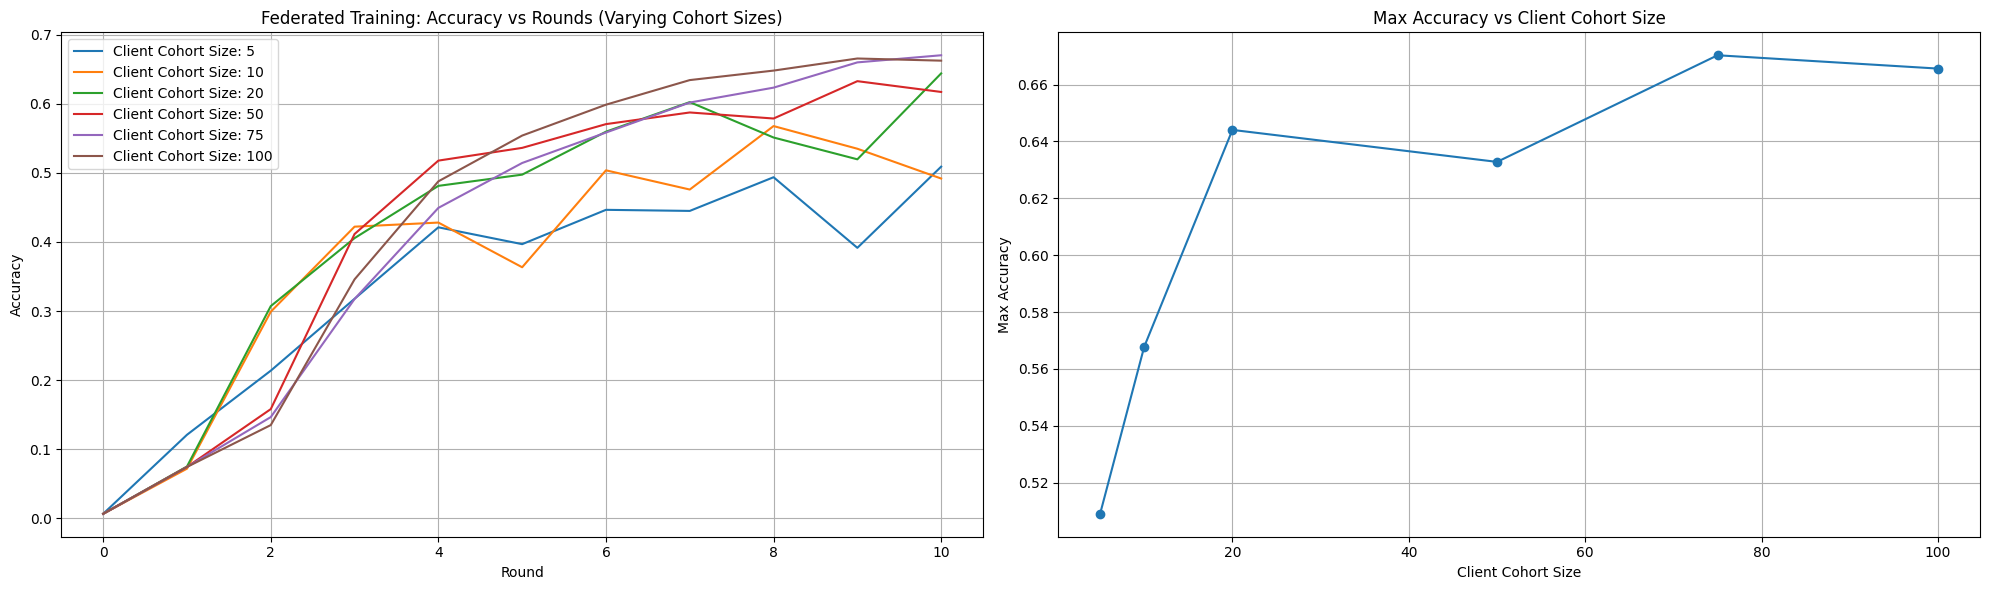

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Left subplot: Accuracy vs Rounds for each client cohort size
for cohort_size, params, hist in total_cohort_results:
    accuracies = get_centralized_acc_from_hist(hist)
    axes[0].plot(accuracies, label=f"Client Cohort Size: {cohort_size}")
axes[0].set_xlabel("Round")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Federated Training: Accuracy vs Rounds (Varying Cohort Sizes)")
axes[0].legend()
axes[0].grid(True)

# Right subplot: Max Accuracy vs Client Cohort Size
cohort_sizes = []
max_accuracies = []
for cohort_size, params, hist in total_cohort_results:
    accuracies = get_centralized_acc_from_hist(hist)
    if accuracies:
        cohort_sizes.append(cohort_size)
        max_accuracies.append(max(accuracies))
axes[1].plot(cohort_sizes, max_accuracies, marker='o')
axes[1].set_xlabel("Client Cohort Size")
axes[1].set_ylabel("Max Accuracy")
axes[1].set_title("Max Accuracy vs Client Cohort Size")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Bottom-left: Compute Budget vs Training Time
for cohort_size, params, hist in total_cohort_results:
    times = []
    samples = []
    for round_idx, round_metrics in hist.metrics_distributed_fit['training_time']:
        round_times = [t for _, t in round_metrics['all']]
        times.append(np.mean(round_times))
        
    for round_idx, round_metrics in hist.metrics_distributed_fit['samples_processed']:
        round_samples = [s for _, s in round_metrics['all']]
        samples.append(np.sum(round_samples))
    
    cumulative_time = np.sum(times)
    total_samples = np.sum(samples)
    axes[0].plot(cumulative_time, total_samples, marker='o', label=f"Local batch size: {cohort_size}")

axes[0].set_xlabel("Total Training Time (s)")
axes[0].set_ylabel("Compute Budget (Total Samples Processed)")
axes[0].set_title("Compute Budget vs. Total Training Time")
axes[0].legend()
axes[0].grid(True)

# Bottom-right: Noise Scale Analysis
for cohort_size, params, hist in total_cohort_results:
    noise_scales = []
    for round_idx, round_metrics in hist.metrics_distributed_fit['noise_scale']:
        round_noise_scales = [ns for _, ns in round_metrics['all']]
        noise_scale = np.mean(round_noise_scales)
        noise_scales.append(noise_scale)
    
    avg_noise_scale = np.mean(noise_scales)
    x_axis = cohort_size / (avg_noise_scale + 1e-10)
    y_axis = 1 / (1 + (avg_noise_scale / cohort_size))
    
    axes[1].plot(x_axis, y_axis, marker='o', label=f"Batch size: {cohort_size}")

axes[1].set_xlabel("Batch Size / Noise Scale")
axes[1].set_ylabel(fr"${{\epsilon_\text{{B}}}} / {{\epsilon_\text{{max}}}}$")
axes[1].set_title("Predicted Training Speed")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

When running experiment with varying client cohort sizes, we also observe that such thing as "ideal" client cohort number exists.

However, we have to investigate how to compute it.

**$\beta_\text{simple}$ integration into Federated Learning runs**


To implement the actual $\beta_\text{simple}$ ($\beta_\text{simple} \approx \beta_\text{crit}$) computation, we would need to change the client fit fn to return the gradients after training, and we would need to aggregate them in the server somehow.

In summary, we need to somehow get them to the hist or params object, and figure out a way to aggregate them.

This appears to give us a good estimate of the critical batch size. According to this estimates, the ideal batch size appears to be somewhere in the 16-64, and the optimal batch size we observe is actually 32, which is right in the middle of the range.

In [18]:
for cohort_size, params, hist in total_cohort_results:
    print("Cohort size: ", cohort_size)

    noise_scales = hist.metrics_distributed_fit['noise_scale']

    crit_batches = []
    for round, round_noise_scales in noise_scales:
        actual_noise_scales = [val for _, val in round_noise_scales['all']]
        crit_batch = compute_critical_batch(actual_noise_scales, .001)
        print("---", crit_batch)
        crit_batches.append(crit_batch)
    print(np.mean(crit_batches))       

Cohort size:  5
--- 7.80248109862773
--- 28.80863154453864
--- 39.44193792675061
--- 16.418522119491858
--- 23.587885257923954
--- 46.472020642722576
--- 40.36285129890818
--- 16.44736823714386
--- 31.703064266412596
--- 38.277821331084915
28.93225837236049
Cohort size:  10
--- 12.29627542722681
--- 37.292521723515044
--- 46.193840839889326
--- 46.5115799598944
--- 31.29319776640928
--- 29.693836110458605
--- 18.959104859880682
--- 17.364952357578915
--- 40.91810530871224
--- 24.80715343677625
30.533056779034162
Cohort size:  20
--- 19.739722384542738
--- 31.0173344759884
--- 61.60996143271221
--- 48.52486369235747
--- 42.70039113517227
--- 31.151749182291713
--- 23.104816825037688
--- 23.82753461729023
--- 24.241404597993846
--- 12.684978400571588
31.860275674395815
Cohort size:  50
--- 12.999255957051911
--- 26.08684070515001
--- 39.907745828544066
--- 38.793126851215376
--- 27.155395083408507
--- 26.436905285248503
--- 18.973436183056613
--- 16.92460797405611
--- 18.258250239373034
